# Tennis ATP data Exploration and Modeling

## 1. [Objectives](#Objectives)
## 2. [Tennis ATP data from internet](#Scrap_data)
## 3. [Analysis of Tennis data](#EDA)
## 4. [Data preparation and feature engineering ](#Feature)
## 5. [Model building and evaluation](#Model)
## 6. [Insight and Discussion](#Insight)

<a id='Contents'></a> 


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import os
#os.chdir(r'kaggle/working')

import string
    
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

 <a id='Objectives'></a>
 ##  1. [Objectives and Problem Definition](#Contents)

We are going to analyse the tennis competion data from https://github.com/JeffSackmann/tennis_atp. There are several goals

* To find out the statistics and understand what factors are correlated to the winning or losing of a game.
* To find out the performance change of players over his/her career, what are the game statistics of the player when competing with different opponents.
* To build a model try to predict the result of game, giving the information of the players, the match and others. 

 <a id='Scrap_data'></a>
 ##  2. [Tennis ATP data from internet](#Contents)

In [2]:
# download the data from  https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/
matrix = pd.DataFrame()

url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/"

year_range = np.arange(1980,2021)

for year in year_range:
    file_url = url+'atp_matches_'+str(year)+'.csv'
    # read csv from the file_url
    df = pd.read_csv(file_url,index_col=0,parse_dates=[0])
    
    if year==year_range[0]:
        cols = df.columns

    # concatenate the dataframe
    matrix = pd.concat([matrix, df], ignore_index=True, sort=False, keys=cols)



In [3]:
matrix.head()

tourney_name surface  draw_size tourney_level  tourney_date  match_num  \
0       Hobart    Hard       32.0             A    19791231.0        1.0   
1       Hobart    Hard       32.0             A    19791231.0        2.0   
2       Hobart    Hard       32.0             A    19791231.0        3.0   
3       Hobart    Hard       32.0             A    19791231.0        4.0   
4       Hobart    Hard       32.0             A    19791231.0        5.0   

   winner_id winner_seed winner_entry     winner_name winner_hand  winner_ht  \
0   100315.0           1          NaN    Hank Pfister           R      193.0   
1   100397.0         NaN          NaN  Terry Rocavert           R      180.0   
2   107328.0         NaN          NaN    Jeremy Cohen           R        NaN   
3   100121.0           6          NaN   Raymond Moore           R      183.0   
4   100337.0           4          NaN  Mark Edmondson           R      185.0   

  winner_ioc  winner_age  loser_id loser_seed loser_entry       loser_name  \
0        USA   26.225873  100713.0        NaN           Q  John Fitzgerald   
1        AUS   24.194387  100473.0        NaN         NaN   Glenn Petrovic   
2        USA         NaN  100265.0        NaN         NaN    Cliff Letcher   
3        RSA   33.352498  100550.0        NaN           Q        Brad Guan   
4        AUS   25.519507  100726.0        NaN         NaN  Greg Whitecross   

  loser_hand  loser_ht loser_ioc  loser_age        score  best_of round  \
0          R     183.0       AUS  19.006160  5-7 6-3 6-4      3.0   R32   
1          R       NaN       USA  22.828200      7-6 7-5      3.0   R32   
2          R       NaN       AUS  27.890486      6-2 6-3      3.0   R32   
3          R       NaN       AUS  21.475702  6-3 5-7 6-3      3.0   R32   
4          R     185.0       AUS  18.795346      6-3 6-3      3.0   R32   

   minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  \
0      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
1      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
2      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
3      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
4      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   

   w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  \
0        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
1        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
2        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
3        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
4        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   

   l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  \
0      NaN        NaN        NaN          NaN                 NaN         NaN   
1      NaN        NaN        NaN          NaN                 NaN         NaN   
2      NaN        NaN        NaN          NaN                 NaN         NaN   
3      NaN        NaN        NaN          NaN                 NaN         NaN   
4      NaN        NaN        NaN          NaN                 NaN         NaN   

   loser_rank_points  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

In [4]:
# see how many non-null data points for each feature
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135825 entries, 0 to 135824
Data columns (total 48 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_name        135825 non-null  object 
 1   surface             135680 non-null  object 
 2   draw_size           135825 non-null  float64
 3   tourney_level       135825 non-null  object 
 4   tourney_date        135825 non-null  float64
 5   match_num           135825 non-null  float64
 6   winner_id           135825 non-null  float64
 7   winner_seed         55782 non-null   object 
 8   winner_entry        14466 non-null   object 
 9   winner_name         135825 non-null  object 
 10  winner_hand         135805 non-null  object 
 11  winner_ht           127379 non-null  float64
 12  winner_ioc          135825 non-null  object 
 13  winner_age          135318 non-null  float64
 14  loser_id            135825 non-null  float64
 15  loser_seed          29407 non-null

In [5]:
# convert the date information to pd.datetime format
matrix['tourney_date'] = pd.to_datetime(matrix.tourney_date.round(), format='%Y%m%d', errors='ignore')

In [6]:
matrix['tourney_date']

0        1979-12-31
1        1979-12-31
2        1979-12-31
3        1979-12-31
4        1979-12-31
            ...    
135820   2020-03-06
135821   2020-03-06
135822   2020-03-06
135823   2020-03-06
135824   2020-03-06
Name: tourney_date, Length: 135825, dtype: datetime64[ns]

In [7]:
# extract information of date
matrix['year'] = matrix['tourney_date'].dt.year
matrix['month'] = matrix['tourney_date'].dt.month
matrix['day'] = matrix['tourney_date'].dt.day
matrix['day_week'] = matrix['tourney_date'].dt.dayofweek
matrix.head()

tourney_name surface  draw_size tourney_level tourney_date  match_num  \
0       Hobart    Hard       32.0             A   1979-12-31        1.0   
1       Hobart    Hard       32.0             A   1979-12-31        2.0   
2       Hobart    Hard       32.0             A   1979-12-31        3.0   
3       Hobart    Hard       32.0             A   1979-12-31        4.0   
4       Hobart    Hard       32.0             A   1979-12-31        5.0   

   winner_id winner_seed winner_entry     winner_name winner_hand  winner_ht  \
0   100315.0           1          NaN    Hank Pfister           R      193.0   
1   100397.0         NaN          NaN  Terry Rocavert           R      180.0   
2   107328.0         NaN          NaN    Jeremy Cohen           R        NaN   
3   100121.0           6          NaN   Raymond Moore           R      183.0   
4   100337.0           4          NaN  Mark Edmondson           R      185.0   

  winner_ioc  winner_age  loser_id loser_seed loser_entry       loser_name  \
0        USA   26.225873  100713.0        NaN           Q  John Fitzgerald   
1        AUS   24.194387  100473.0        NaN         NaN   Glenn Petrovic   
2        USA         NaN  100265.0        NaN         NaN    Cliff Letcher   
3        RSA   33.352498  100550.0        NaN           Q        Brad Guan   
4        AUS   25.519507  100726.0        NaN         NaN  Greg Whitecross   

  loser_hand  loser_ht loser_ioc  loser_age        score  best_of round  \
0          R     183.0       AUS  19.006160  5-7 6-3 6-4      3.0   R32   
1          R       NaN       USA  22.828200      7-6 7-5      3.0   R32   
2          R       NaN       AUS  27.890486      6-2 6-3      3.0   R32   
3          R       NaN       AUS  21.475702  6-3 5-7 6-3      3.0   R32   
4          R     185.0       AUS  18.795346      6-3 6-3      3.0   R32   

   minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  \
0      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
1      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
2      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
3      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
4      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   

   w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  \
0        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
1        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
2        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
3        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
4        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   

   l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  \
0      NaN        NaN        NaN          NaN                 NaN         NaN   
1      NaN        NaN        NaN          NaN                 NaN         NaN   
2      NaN        NaN        NaN          NaN                 NaN         NaN   
3      NaN        NaN        NaN          NaN                 NaN         NaN   
4      NaN        NaN        NaN          NaN                 NaN         NaN   

   loser_rank_points  year  month  day  day_week  
0                NaN  1979     12   31         0  
1                NaN  1979     12   31         0  
2                NaN  1979     12   31         0  
3                NaN  1979     12   31         0  
4                NaN  1979     12   31         0

See how many counts for different number of sets in the 'score' feature

In [8]:
matrix['split']=matrix['score'].str.split(' ')
matrix['split_len']=matrix['split'].map(lambda x: len(x), na_action='ignore')

In [9]:
matrix.groupby('split_len').agg({'split_len':'count'})

split_len
split_len           
1.0              499
2.0            69113
3.0            51387
4.0             9183
5.0             5554
6.0               67

Normally the maximal set number is 5, check what are there in the terms with split_len = 6

In [10]:
matrix[matrix.split_len == 6]['score'].unique()

array(['3-6 6-7 7-6 7-6 5-3 ABD', '6-8 6-8 1-1 Played and unfinished',
       '3-6 1-6 6-2 6-2 6-5 RET', '6-4 3-6 2-6 6-3 2-0 RET',
       '3-6 6-3 6-7 6-0 2-0 RET', '3-6 2-6 7-6 6-2 4-0 RET',
       '6-4 6-7 6-7 6-2 0-1 RET', '1-6 6-1 6-2 2-6 5-2 DEF',
       '4-6 6-8 8-6 6-1 4-3 RET', '7-5 6-4 3-6 4-6 3-2 RET',
       '4-6 1-6 6-4 6-0 4-2 RET', '9-11 1-6 6-2 6-1 3-1 RET',
       '3-6 6-3 4-6 6-2 0-1 RET', '4-6 4-6 6-3 7-5 1-0 RET',
       '6-1 5-7 3-2 Played and unfinished', '6-2 4-6 1-6 7-6(4) 4-1 RET',
       '2-6 4-6 6-3 7-6(11) 5-2 RET', '2-6 4-6 7-5 7-6(6) 3-2 RET',
       '1-6 6-4 2-6 7-5 1-0 RET', '4-6 6-3 0-6 6-2 1-0 RET',
       '6-4 3-6 6-7(6) 6-0 3-0 RET', '6-4 3-6 6-3 3-6 5-4 RET',
       '6-3 6-4 6-7(3) 2-6 3-1 RET', '6-4 4-6 2-6 6-2 2-1 RET',
       '6-7(9) 7-6(0) 4-6 6-3 6-6 RET', '6-7(5) 6-3 6-7(3) 6-4 4-1 RET',
       '2-6 7-6(5) 6-2 6-7(6) 3-0 RET', '6-4 6-2 3-6 6-7(7) 4-4 RET',
       '7-5 4-6 5-7 6-3 5-0 RET', '4-6 4-6 6-3 7-5 3-4 RET',
       '4-6 6-2 6-2 4-6 0-1

So the 6th split score is actually 'RET'.

In [12]:
# # extract information of score
# #matrix['score_split'] = 
# matrix['split']=matrix['score'].str.split(' ')
# # use na_action='ignore' to ignore the nan, otherwise it throws error
# matrix['set_1']=matrix['split'].map(lambda x: x[0].strip(), na_action='ignore')
# matrix['set_2']=matrix['split'].map(lambda x: x[1].strip() if len(x)>1 else np.nan, na_action='ignore')
# matrix['set_3']=matrix['split'].map(lambda x: x[2].strip() if len(x)>2 else np.nan, na_action='ignore')
# matrix['set_4']=matrix['split'].map(lambda x: x[3].strip() if len(x)>3 else np.nan, na_action='ignore')
# matrix['set_5']=matrix['split'].map(lambda x: x[4].strip() if len(x)>4 else np.nan, na_action='ignore')
# matrix['set_6']=matrix['split'].map(lambda x: x[5].strip() if len(x)>5 else np.nan, na_action='ignore')

Now split the scores  

In [11]:
# further split the set point to winner and loser


for i in range(1,7):
    
    matrix['split']=matrix['score'].str.split(' ')
    #column for set point
    col_set = 'set_'+str(i)  
    # use na_action='ignore' to ignore the nan, otherwise it throws error    
    matrix[col_set]=matrix['split'].map(lambda x: x[i-1].strip() if len(x)>i-1 else np.nan, na_action='ignore')    
    
    if i<=5:   # we use i<=5 because for i=6, matrix[set_6]=NaN, and it throws error when applying .str to it
        matrix['split']=matrix[col_set].str.split('-')
        # use na_action='ignore' to ignore the nan, otherwise it throws error
        matrix['winner_'+col_set]=matrix['split'].map(lambda x: x[0].strip(), na_action='ignore')
        matrix['loser_'+col_set]=matrix['split'].map(lambda x: x[1].strip() if len(x)>1 else np.nan, na_action='ignore')

In [12]:
matrix

tourney_name surface  draw_size tourney_level  \
0                             Hobart    Hard       32.0             A   
1                             Hobart    Hard       32.0             A   
2                             Hobart    Hard       32.0             A   
3                             Hobart    Hard       32.0             A   
4                             Hobart    Hard       32.0             A   
...                              ...     ...        ...           ...   
135820  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
135821  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
135822  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
135823  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
135824  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   

       tourney_date  match_num  winner_id winner_seed winner_entry  \
0        1979-12-31        1.0   100315.0           1          NaN   
1        1979-12-31        2.0   100397.0         NaN          NaN   
2        1979-12-31        3.0   107328.0         NaN          NaN   
3        1979-12-31        4.0   100121.0           6          NaN   
4        1979-12-31        5.0   100337.0           4          NaN   
...             ...        ...        ...         ...          ...   
135820   2020-03-06        2.0   105668.0         NaN          NaN   
135821   2020-03-06        4.0   209874.0         NaN          NaN   
135822   2020-03-06        1.0   208518.0         NaN          NaN   
135823   2020-03-06        2.0   111761.0         NaN          NaN   
135824   2020-03-06        4.0   111761.0         NaN          NaN   

             winner_name winner_hand  winner_ht winner_ioc  winner_age  \
0           Hank Pfister           R      193.0        USA   26.225873   
1         Terry Rocavert           R      180.0        AUS   24.194387   
2           Jeremy Cohen           R        NaN        USA         NaN   
3          Raymond Moore           R      183.0        RSA   33.352498   
4         Mark Edmondson           R      185.0        AUS   25.519507   
...                  ...         ...        ...        ...         ...   
135820    Jerzy Janowicz           R      203.0        POL   29.300479   
135821  Maks Kasnikowski         NaN        NaN        POL   16.657084   
135822         Hazem Naw           R        NaN        UNK   20.167009   
135823     Benjamin Lock           R        NaN        ZIM   26.995209   
135824     Benjamin Lock           R        NaN        ZIM   26.995209   

        loser_id loser_seed loser_entry                  loser_name  \
0       100713.0        NaN           Q             John Fitzgerald   
1       100473.0        NaN         NaN              Glenn Petrovic   
2       100265.0        NaN         NaN               Cliff Letcher   
3       100550.0        NaN           Q                   Brad Guan   
4       100726.0        NaN         NaN             Greg Whitecross   
...          ...        ...         ...                         ...   
135820  106388.0        NaN         NaN              Pak Long Yeung   
135821  207852.0        NaN         NaN                  Wai Yu Kai   
135822  200250.0        NaN         NaN  Mehluli Don Ayanda Sibanda   
135823  200181.0        NaN         NaN                   Amer Naow   
135824  208518.0        NaN         NaN                   Hazem Naw   

       loser_hand  loser_ht loser_ioc  loser_age           score  best_of  \
0               R     183.0       AUS  19.006160     5-7 6-3 6-4      3.0   
1               R       NaN       USA  22.828200         7-6 7-5      3.0   
2               R       NaN       AUS  27.890486         6-2 6-3      3.0   
3               R       NaN       AUS  21.475702     6-3 5-7 6-3      3.0   
4               R     185.0       AUS  18.795346         6-3 6-3      3.0   
...           ...       ...       ...        ...             ...      ...   
135820          U       N

In [15]:
print('Unique data in winner_set:')
print('')
print(matrix.winner_set_1.unique())
print(matrix.winner_set_2.unique())
print(matrix.winner_set_3.unique())
print(matrix.winner_set_4.unique())
print(matrix.winner_set_5.unique())

print('')
print('Unique data in loser_set:')
print('')
print(matrix.loser_set_1.unique())
print(matrix.loser_set_2.unique())
print(matrix.loser_set_3.unique())
print(matrix.loser_set_4.unique())
print(matrix.loser_set_5.unique())



Unique data in winner_set:

['5' '7' '6' '3' '1' '4' '2' nan '0' '12' '8' 'DEF' 'W/O' '10' '11' '14'
 '9' '' '16' 'RET' '13' '24' 'In' 'Apr' 'Walkover']
['6' '7' '5' '1' '3' '4' nan '2' '0' 'RET' '8' '13' 'ABD' '10' 'DEF' '9'
 '11' '14' 'Played' 'W/O' '12' '17' '15' '16' '30' 'Progress' 'Unfinished']
['6' nan '9' '7' '12' '8' '10' '11' '4' 'RET' '3' '1' '5' '2' '13' '14'
 'ABD' '0' '15' '64' 'and' '21' '16' '17' '19' 'Played' '22' 'DEF' '25' ''
 '[10' '[1' '[12' '[11' '[4' '[6' '[3']
[nan '6' '3' '10' '7' '8' 'DEF' 'RET' '13' '2' '15' '4' '1' '5' 'ABD' '0'
 '9' 'unfinished' 'NA' '12' 'Played' '11' 'and' '19' 'Default' 'abandoned'
 '' 'Def.']
[nan '6' '7' '9' '5' '11' '10' '8' '13' 'RET' '12' '1' 'and' '15' '2' '4'
 '14' '0' '17' 'unfinished' '3' '19' '16' 'DEF' '20' 'Default' '21'
 'abandoned' '70' '18' '' '22' '26']

Unique data in loser_set:

['7' '6' '2' '3' '4' '5' '1' nan '0' '10' '9' '8' '12' '6(2)' '11' '6(3)'
 '7(6)' '7(4)' '6(4)' '14' '6(7)' '6(5)' '16' '6(8)' '22' '6(6)' '6(1

Columns for set_6 does not have any useful information, just drop them

In [14]:
matrix.drop(['set_6'], axis=1, inplace = True)

* Data Cleansing

In [17]:
# fix the weird data points


for i in range(1,6):
    col_win_set = 'winner_'+'set_'+str(i)
    col_los_set = 'loser_'+'set_'+str(i)
    
    # first replace nonumerical features with nan 
    matrix[col_win_set] = matrix[col_win_set].map(lambda x:x if x not in
                                                  ['W/O','In','Walkover','RET','','abandoned','ABD','NA',
                                                   'DEF','Played','Progress','and','Default','Def.','unfinished','Unfinished']
                                                 else np.nan, na_action='ignore') 
    
    matrix[col_los_set] = matrix[col_los_set].map(lambda x:x if x not in
                                                  ['W/O','In','Walkover','RET','','abandoned',
                                                   'DEF','Played','Progress','and','Default','Def.','unfinished','Unfinished']
                                                 else np.nan, na_action='ignore') 
    
    # replace 'month' data with number
    matrix[col_win_set] = matrix[col_win_set].replace({'Jun': '6', 'Apr': '4','Feb':'2','00':'0'})
    matrix[col_los_set] = matrix[col_los_set].replace({'Jun': '6', 'Apr': '4','Feb':'2','00':'0'})
    
    #define a tiebreak point columns
    col_set_tb = 'set_'+str(i)+'_tb'
    
    # for winner columns, there is no tiebreak point with (), the only left over are the last game with [],
    # we can remove all the punctuation and only keep the number
    matrix[col_win_set] = matrix[col_win_set].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), na_action='ignore')
    matrix[col_win_set] = matrix[col_win_set].astype(np.float32)
    
    # for loser columns, there is a tiebreak point with (), we need to further seperate them out
    matrix['split']=matrix[col_los_set].str.split('(')
    # the first element before the '(' is the set point of loser, it could include point with ']'
    matrix[col_los_set] = matrix['split'].map(lambda x: x[0].strip(), na_action='ignore')    
    # remove the punctuation
    matrix[col_los_set] = matrix[col_los_set].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), na_action='ignore')
    matrix[col_los_set] = matrix[col_los_set].astype(np.float32)
    
    # the element after the ( is the tiebreak point, it could include ')' 
    matrix[col_set_tb] = matrix['split'].map(lambda x: x[1].strip() if len(x)>1 else np.nan, na_action='ignore')
    # remove the punctuation
    matrix[col_set_tb] = matrix[col_set_tb].map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), na_action='ignore')
    matrix[col_set_tb] = matrix[col_set_tb].astype(np.float32)
    

Now check one more time

In [18]:
print('Unique data in winner_set:')
print('')
print(matrix.winner_set_1.unique())
print(matrix.winner_set_2.unique())
print(matrix.winner_set_3.unique())
print(matrix.winner_set_4.unique())
print(matrix.winner_set_5.unique())

print('')
print('Unique data in loser_set:')
print('')
print(matrix.loser_set_1.unique())
print(matrix.loser_set_2.unique())
print(matrix.loser_set_3.unique())
print(matrix.loser_set_4.unique())
print(matrix.loser_set_5.unique())

print('')
print('Unique data in tb_set:')
print('')
print(matrix.set_1_tb.unique())
print(matrix.set_2_tb.unique())
print(matrix.set_3_tb.unique())
print(matrix.set_4_tb.unique())
print(matrix.set_5_tb.unique())


Unique data in winner_set:

[ 5.  7.  6.  3.  1.  4.  2. nan  0. 12.  8. 10. 11. 14.  9. 16. 13. 24.]
[ 6.  7.  5.  1.  3.  4. nan  2.  0.  8. 13. 10.  9. 11. 14. 12. 17. 15.
 16. 30.]
[ 6. nan  9.  7. 12.  8. 10. 11.  4.  3.  1.  5.  2. 13. 14.  0. 15. 64.
 21. 16. 17. 19. 22. 25.]
[nan  6.  3. 10.  7.  8. 13.  2. 15.  4.  1.  5.  0.  9. 12. 11. 19.]
[nan  6.  7.  9.  5. 11. 10.  8. 13. 12.  1. 15.  2.  4. 14.  0. 17.  3.
 19. 16. 20. 21. 70. 18. 22. 26.]

Unique data in loser_set:

[ 7.  6.  2.  3.  4.  5.  1. nan  0. 10.  9.  8. 12. 11. 14. 16. 22.]
[ 3.  5.  7.  2.  6.  4.  1.  0. nan 15.  8. 10.  9. 12. 13. 11. 16. 14.
 30.]
[  4.  nan   3.   2.   1.   0.   7.   5.  10.   6.   8.   9.  11.  12.
  13.  19. 412.  17. 715.  14.  15. 210.  20.  23.]
[nan  4.  3.  6.  2.  8.  1.  5. 11.  0. 13.  7.  9. 10. 12. 17.]
[ nan   4.   1.   5.   3.   2.   0.   7.   9.   8.   6.  11.  10.  19.
 311.  13. 210. 412.  12.  15.  17.  14.  18.  68.  16.  20.  24.]

Unique data in tb_set:

[nan  2.  

Note that we have already change the datatype of the above columns to float32

In [19]:
matrix.head(10)

tourney_name surface  draw_size tourney_level tourney_date  match_num  \
0       Hobart    Hard       32.0             A   1979-12-31        1.0   
1       Hobart    Hard       32.0             A   1979-12-31        2.0   
2       Hobart    Hard       32.0             A   1979-12-31        3.0   
3       Hobart    Hard       32.0             A   1979-12-31        4.0   
4       Hobart    Hard       32.0             A   1979-12-31        5.0   
5       Hobart    Hard       32.0             A   1979-12-31        6.0   
6       Hobart    Hard       32.0             A   1979-12-31        7.0   
7       Hobart    Hard       32.0             A   1979-12-31        8.0   
8       Hobart    Hard       32.0             A   1979-12-31        9.0   
9       Hobart    Hard       32.0             A   1979-12-31       10.0   

   winner_id winner_seed winner_entry        winner_name winner_hand  \
0   100315.0           1          NaN       Hank Pfister           R   
1   100397.0         NaN          NaN     Terry Rocavert           R   
2   107328.0         NaN          NaN       Jeremy Cohen           R   
3   100121.0           6          NaN      Raymond Moore           R   
4   100337.0           4          NaN     Mark Edmondson           R   
5   100515.0         NaN          NaN  Shlomo Glickstein           R   
6   100500.0         NaN          NaN        Rohun Beven           R   
7   100293.0           8          NaN         John Marks           R   
8   100488.0         NaN          NaN      Chris Delaney           R   
9   100592.0         NaN          NaN    Robert Vant Hof           R   

   winner_ht winner_ioc  winner_age  loser_id loser_seed loser_entry  \
0      193.0        USA   26.225873  100713.0        NaN           Q   
1      180.0        AUS   24.194387  100473.0        NaN         NaN   
2        NaN        USA         NaN  100265.0        NaN         NaN   
3      183.0        RSA   33.352498  100550.0        NaN           Q   
4      185.0        AUS   25.519507  100726.0        NaN         NaN   
5      188.0        ISR   21.982204  100224.0        NaN         NaN   
6        NaN        GBR   22.275154  100749.0        NaN         NaN   
7        NaN        AUS   27.058179  100464.0        NaN         NaN   
8        NaN        USA   22.458590  100551.0          5         NaN   
9      193.0        USA   20.725530  100334.0        NaN         NaN   

        loser_name loser_hand  loser_ht loser_ioc  loser_age        score  \
0  John Fitzgerald          R     183.0       AUS  19.006160  5-7 6-3 6-4   
1   Glenn Petrovic          R       NaN       USA  22.828200      7-6 7-5   
2    Cliff Letcher          R       NaN       AUS  27.890486      6-2 6-3   
3        Brad Guan          R       NaN       AUS  21.475702  6-3 5-7 6-3   
4  Greg Whitecross          R     185.0       AUS  18.795346      6-3 6-3   
5   Peter Campbell          R       NaN       AUS  29.138946      6-2 6-2   
6     Dave Siegler          R       NaN       USA  18.584531  6-2 1-6 6-2   
7     Warren Maher          R       NaN       AUS  22.956879      6-2 6-4   
8     Brad Drewett          L     185.0       AUS  21.451061  7-6 3-6 6-4   
9      Ernie Ewert          R       NaN       AUS  25.571526  3-6 6-1 6-2   

   best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  \
0      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
1      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
2      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
3      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
4      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
5      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
6      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
7      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
8      3.0   R32      NaN    Na

In [20]:
# we can remove redundant columns
matrix.drop(['split','split_len','set_1','set_2','set_3','set_4','set_5'],axis=1,inplace=True)

Now check if there is any abnormaly in other columns

In [22]:
matrix.columns[matrix.dtypes == np.object]

Index(['tourney_name', 'surface', 'tourney_level', 'winner_seed',
       'winner_entry', 'winner_name', 'winner_hand', 'winner_ioc',
       'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ioc',
       'score', 'round'],
      dtype='object')

In [21]:
# for columns with object type, we print the unique values 
for cols in matrix.columns:
    if matrix[cols].dtypes == np.object:
        print(cols)
        print(matrix[cols].unique())
        print('')

tourney_name
['Hobart' 'Auckland' 'Perth' ... 'Davis Cup WG2 PO: PHI vs GRE'
 'Davis Cup WG2 PO: POL vs HKG' 'Davis Cup WG2 PO: SYR vs ZIM']

surface
['Hard' 'Grass' 'Carpet' 'Clay' nan 'None']

tourney_level
['A' 'D' 'M' 'G' 'F' 'C']

winner_seed
[1.0 nan 6.0 4.0 8.0 3.0 7.0 5.0 2.0 16.0 14.0 13.0 12.0 11.0 10.0 9.0
 15.0 32.0 31.0 30.0 29.0 25.0 24.0 22.0 21.0 20.0 19.0 17.0 23.0 28.0
 26.0 18.0 27.0 33.0 35.0 '2' '4' '7' '5' '6' '8' '1' '3' 'WC' '25' '21'
 '15' '12' '23' '32' '29' '24' '16' '11' '28' '26' '22' '10' '14' 'Q' '19'
 '30' '20' '18' '27' '9' '13' '17' '31' '33']

winner_entry
[nan 'Q' 'LL' 'WC' 'PR' 'SE' 'ALT' 'Alt']

winner_name
['Hank Pfister' 'Terry Rocavert' 'Jeremy Cohen' ... 'Petros Tsitsipas'
 'Maks Kasnikowski' 'Hazem Naw']

winner_hand
['R' 'L' 'U' nan]

winner_ioc
['USA' 'AUS' 'RSA' 'ISR' 'GBR' 'NZL' 'AUT' 'FRA' 'HUN' 'ROU' 'POL' 'MEX'
 'IND' 'SUI' 'ARG' 'ESP' 'CHI' 'BEL' 'BUL' 'FIN' 'RUS' 'GER' 'SWE' 'ECU'
 'CZE' 'EGY' 'CAN' 'CRO' 'ITA' 'NED' 'IRL' 'BRA' 'PAR'

In [22]:
# fix the upper/lower case
matrix['winner_entry']= matrix['winner_entry'].str.upper()
matrix['loser_entry']=matrix['loser_entry'].str.upper()

In [23]:
# the winner/loser seed are object that mix numerics and strings. Convert the numerics to strings. use 'isinstance(x,float)' to check if the object is float
matrix['loser_seed'] = matrix['loser_seed'].map(lambda x: str(int(x)) if isinstance(x, float) else x, na_action = 'ignore')
matrix['winner_seed'] = matrix['winner_seed'].map(lambda x: str(int(x)) if isinstance(x, float) else x, na_action = 'ignore')

print(matrix['winner_seed'].unique())
print(matrix['loser_seed'].unique())

['1' nan '6' '4' '8' '3' '7' '5' '2' '16' '14' '13' '12' '11' '10' '9'
 '15' '32' '31' '30' '29' '25' '24' '22' '21' '20' '19' '17' '23' '28'
 '26' '18' '27' '33' '35' 'WC' 'Q']
[nan '5' '1' '4' '3' '6' '8' '7' '2' '15' '16' '14' '11' '9' '13' '12'
 '10' '28' '27' '26' '23' '30' '29' '25' '22' '24' '31' '32' '20' '21'
 '19' '17' '18' '34' '33' '35' 'Q' 'WC' 'LL']


 <a id='EDA'></a>
 ##  3. [Analysis of Tennis data](#Contents)

Some basic statistics:

In [24]:
matrix.describe(include='all')

tourney_name surface      draw_size tourney_level         tourney_date  \
count        135825  135680  135825.000000        135825               135825   
unique         3093       5            NaN             6                 1969   
top         US Open    Hard            NaN             A  1987-07-13 00:00:00   
freq           5081   60668            NaN         84217                  164   
first           NaN     NaN            NaN           NaN  1979-12-31 00:00:00   
last            NaN     NaN            NaN           NaN  2020-03-06 00:00:00   
mean            NaN     NaN      52.378855           NaN                  NaN   
std             NaN     NaN      36.934308           NaN                  NaN   
min             NaN     NaN       4.000000           NaN                  NaN   
25%             NaN     NaN      32.000000           NaN                  NaN   
50%             NaN     NaN      32.000000           NaN                  NaN   
75%             NaN     NaN      64.000000           NaN                  NaN   
max             NaN     NaN     128.000000           NaN                  NaN   

            match_num      winner_id winner_seed winner_entry    winner_name  \
count   135825.000000  135825.000000       55782        14466         135825   
unique            NaN            NaN          36            6           2989   
top               NaN            NaN           1            Q  Roger Federer   
freq              NaN            NaN        8002         8943           1250   
first             NaN            NaN         NaN          NaN            NaN   
last              NaN            NaN         NaN          NaN            NaN   
mean        54.593506  103089.361458         NaN          NaN            NaN   
std         90.168741    5656.293929         NaN          NaN            NaN   
min          1.000000  100016.000000         NaN          NaN            NaN   
25%          9.000000  101124.000000         NaN          NaN            NaN   
50%         22.000000  102247.000000         NaN          NaN            NaN   
75%         46.000000  104022.000000         NaN          NaN            NaN   
max       1701.000000  209874.000000         NaN          NaN            NaN   

       winner_hand      winner_ht winner_ioc     winner_age       loser_id  \
count       135805  127379.000000     135825  135318.000000  135825.000000   
unique           3            NaN        123            NaN            NaN   
top              R            NaN        USA            NaN            NaN   
freq        115175            NaN      24527            NaN            NaN   
first          NaN            NaN        NaN            NaN            NaN   
last           NaN            NaN        NaN            NaN            NaN   
mean           NaN     184.755533        NaN      25.394753  103305.940953   
std            NaN       6.657134        NaN       3.777501    6490.647223   
min            NaN     160.000000        NaN      14.351814  100010.000000   
25%            NaN     180.000000        NaN      22.614648  101124.000000   
50%            NaN     185.000000        NaN      25.103354  102271.000000   
75%            NaN     188.000000        NaN      27.931554  104122.000000   
max            NaN     208.000000        NaN      46.592745  209873.000000   

       loser_seed loser_entry       loser_name loser_hand       loser_ht  \
count       29407       24395           135825     135769  121664.000000   
unique         38           7             4479          3            NaN   
top             8           Q  Feliciano Lopez          R            NaN   
freq         2780       14703              451     114114            NaN   
first         NaN         NaN              NaN        NaN            NaN   
last          NaN         NaN              NaN        NaN            NaN   
mean          NaN         NaN              NaN        NaN     184.361586   
std           NaN         NaN              NaN    

In [25]:
len_col = len(matrix.columns)
print(len_col)


67


In [26]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135825 entries, 0 to 135824
Data columns (total 67 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   tourney_name        135825 non-null  object        
 1   surface             135680 non-null  object        
 2   draw_size           135825 non-null  float64       
 3   tourney_level       135825 non-null  object        
 4   tourney_date        135825 non-null  datetime64[ns]
 5   match_num           135825 non-null  float64       
 6   winner_id           135825 non-null  float64       
 7   winner_seed         55782 non-null   object        
 8   winner_entry        14466 non-null   object        
 9   winner_name         135825 non-null  object        
 10  winner_hand         135805 non-null  object        
 11  winner_ht           127379 non-null  float64       
 12  winner_ioc          135825 non-null  object        
 13  winner_age          135318 no

* #### Match information statistics

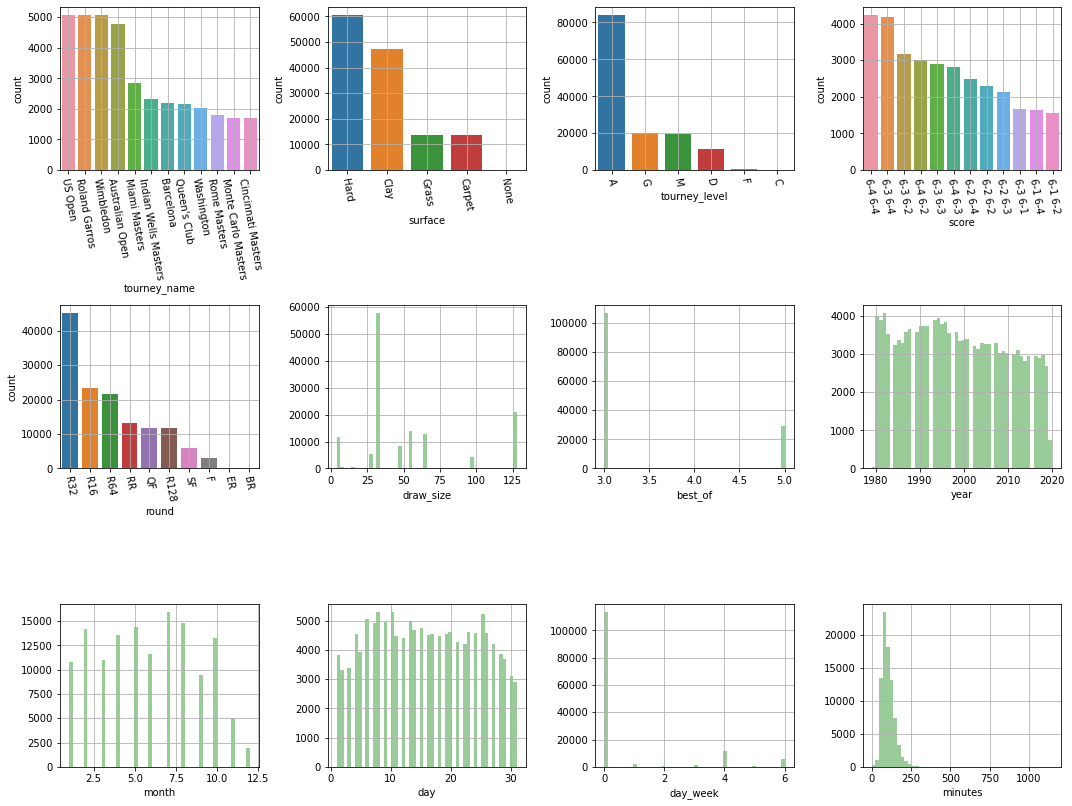

In [27]:
# 

col_match = ['tourney_name','surface','tourney_level','score','round','draw_size','best_of','year','month','day','day_week','minutes']


plt.figure(figsize=(15,15))
i=1
 
for col in col_match:
    
    if matrix[col].dtypes in (np.float64,np.int64):
        
        
        # if the column is numeric features, plot the distribution
        plt.subplot(4,4,i)
        sns.distplot(matrix[col],kde=False,hist=True,color='green',hist_kws={'align':'mid'})
        plt.grid()
        
    elif (matrix[col].dtypes == np.object):
        
        # if the column is categorical features, plot the number of the top 10 category
        group=matrix.groupby(col).agg({col:'count'})
        group.rename(columns = {col:'count'},inplace=True)
        group = group.sort_values(by='count',ascending = False)
        group = group.reset_index()
        
        plt.subplot(4,4,i)
        sns.barplot(x=col,y='count',data = group[0:12])
        plt.xticks(rotation = -80)
        plt.grid()
 
        
    i+=1

    
plt.tight_layout()    
        

Something weird in the 'minutes', there seems to have outliers

[Text(0.5, 0, '')]

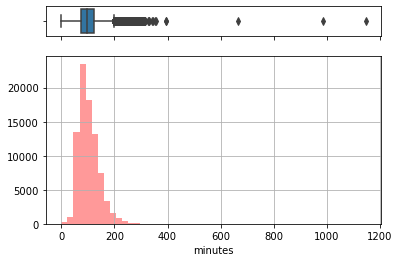

In [28]:
plt.figure

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(matrix["minutes"], ax=ax_box)

sns.distplot(matrix["minutes"], ax=ax_hist,kde=False,color='red')
plt.grid()
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')


Matches that last for more than 400 minuts

In [29]:
matrix[matrix.minutes>400]

tourney_name surface  draw_size tourney_level tourney_date  match_num  \
107468    Wimbledon   Grass      128.0             G   2010-06-21       60.0   
123713       Sydney    Hard       32.0             A   2016-01-11      294.0   
127779       Munich    Clay       32.0             A   2017-05-01      297.0   

        winner_id winner_seed winner_entry    winner_name winner_hand  \
107468   104545.0          23          NaN     John Isner           R   
123713   104180.0         NaN          NaN  Gilles Muller           L   
127779   111202.0         NaN          NaN    Hyeon Chung           R   

        winner_ht winner_ioc  winner_age  loser_id loser_seed loser_entry  \
107468      206.0        USA   25.152635  103917.0        NaN           Q   
123713      193.0        LUX   32.676249  104871.0          6         NaN   
127779        NaN        KOR   20.950034  105373.0        NaN         NaN   

           loser_name loser_hand  loser_ht loser_ioc  loser_age  \
107468  Nicolas Mahut          R     190.0       FRA  28.413415   
123713  Jeremy Chardy          R     188.0       FRA  28.911704   
127779  Martin Klizan          L     190.0       SVK  27.805613   

                              score  best_of round  minutes  w_ace  w_df  \
107468  6-4 3-6 6-7(7) 7-6(3) 70-68      5.0  R128    665.0  113.0  10.0   
123713                   7-6(5) 6-3      3.0    QF   1146.0   14.0   5.0   
127779                  6-4 3-6 6-2      3.0    QF    987.0    4.0   2.0   

        w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  \
107468   491.0    361.0     292.0      82.0     90.0        2.0        3.0   
123713    59.0     35.0      32.0      13.0     10.0        0.0        0.0   
127779    81.0     47.0      36.0      15.0     13.0        4.0        6.0   

        l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  \
107468  103.0  21.0   489.0    328.0     284.0     101.0     91.0       12.0   
123713    2.0   5.0    69.0     44.0      34.0      10.0     11.0        1.0   
127779    8.0   4.0    95.0     49.0      28.0      27.0     14.0        8.0   

        l_bpFaced  winner_rank  winner_rank_points  loser_rank  \
107468       14.0         19.0              1925.0       148.0   
123713        3.0         38.0              1105.0        31.0   
127779       12.0         78.0               659.0        53.0   

        loser_rank_points  year  month  day  day_week  winner_set_1  \
107468              339.0  2010      6   21         0           6.0   
123713             1255.0  2016      1   11         0           7.0   
127779              880.0  2017      5    1         0           6.0   

        loser_set_1  winner_set_2  loser_set_2  winner_set_3  loser_set_3  \
107468          4.0           3.0          6.0           6.0          7.0   
123713          6.0           6.0          3.0           NaN          NaN   
127779          4.0           3.0          6.0           6.0          2.0   

        winner_set_4  loser_set_4  winner_set_5  loser_set_5  set_1_tb  \
107468           7.0          6.0          70.0         68.0       NaN   
123713           NaN          NaN           NaN          NaN       5.0   
127779           NaN          NaN           NaN          NaN       NaN   

        set_2_tb  set_3_tb  set_4_tb  set_5_tb  
107468       NaN       7.0       3.0       NaN  
123713       NaN       NaN       NaN       NaN  
127779       NaN       NaN       NaN       NaN

* #### Winners vs Losers

In [30]:
# change id to string type
matrix['winner_id'] = matrix['winner_id'].map(lambda x:str(int(x)))
matrix['loser_id'] = matrix['loser_id'].map(lambda x:str(int(x)))
#matrix.drop('loser_seed0',axis=1,inplace=True)

In [31]:
matrix.dtypes

tourney_name                  object
surface                       object
draw_size                    float64
tourney_level                 object
tourney_date          datetime64[ns]
match_num                    float64
winner_id                     object
winner_seed                   object
winner_entry                  object
winner_name                   object
winner_hand                   object
winner_ht                    float64
winner_ioc                    object
winner_age                   float64
loser_id                      object
loser_seed                    object
loser_entry                   object
loser_name                    object
loser_hand                    object
loser_ht                     float64
loser_ioc                     object
loser_age                    float64
score                         object
best_of                      float64
round                         object
minutes                      float64
w_ace                        float64
w

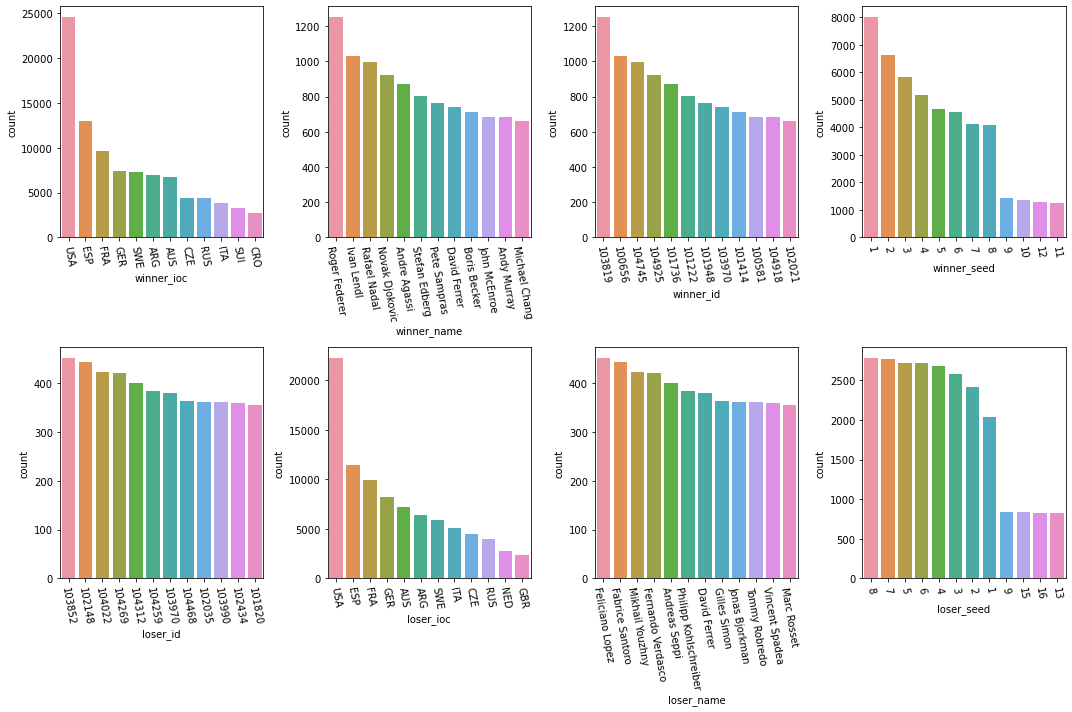

In [33]:
# player personal information

col_player_ps_1 = ['winner_ioc','winner_name','winner_id','winner_seed',
                 'loser_id','loser_ioc','loser_name','loser_seed',]


plt.figure(figsize=(15,10))
i=1
 
for col in col_player_ps_1:
    
    
    if matrix[col].dtypes in (np.float64,np.int64,np.float32):
        
        # if the column is numeric features, plot the distribution
        plt.subplot(2,4,i)
        sns.distplot(matrix[col],kde=False,color='red')
            
        
    elif (matrix[col].dtypes == np.object):
        
        # if the column is categorical features, plot the number of the top 10 category
        group=matrix.groupby(col).agg({col:'count'})
        group.rename(columns = {col:'count'},inplace=True)
        group = group.sort_values(by='count',ascending = False)
        group = group.reset_index()

        plt.subplot(2,4,i)
        sns.barplot(x=col,y='count',data = group[0:12],order=group.loc[0:11,col])
        plt.xticks(rotation = -80)           
        
    i+=1

    
plt.tight_layout()  

The name and id are one to one linked.   

Interestingly, the number of times a winner_seed winned a game pretty much follows the seed order from 1,2,3, ... to 12, and the number of wins have an abrupt drop from the 8th place. While the loser_seed pretty much follows an inverse order: from 8,7,... to 1, and an abrupt change also occurs at the 8th place. Basically, players with seed 1 to seed 8 dominate the top 8 number of winning or losing a game. It makes sense since the number of seed players is determine by the draw size (number of participants). For the most common one with a draw size of 32 (as shown above), there will be 8 seed players, and for draw size of 64, there will be 16 seed players.  

<Figure size 1080x504 with 0 Axes>

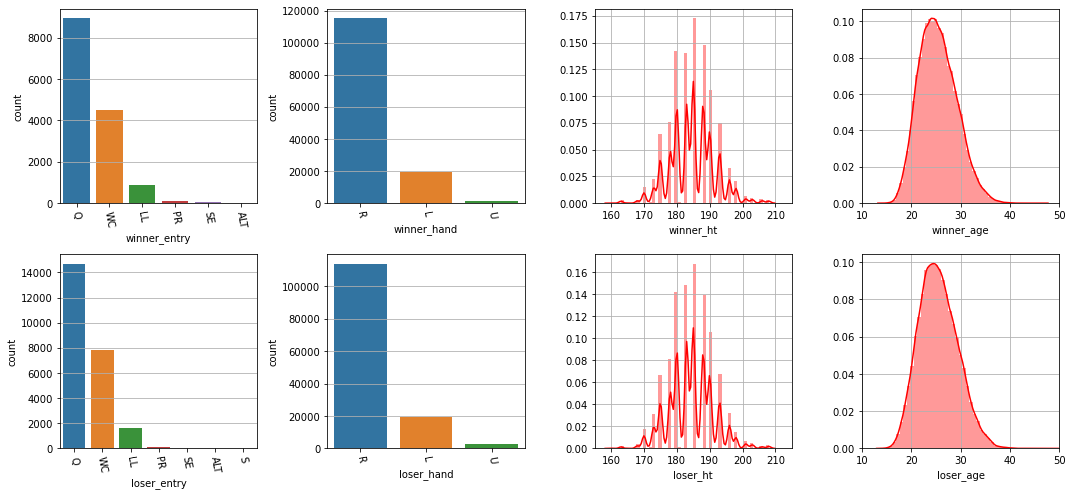

In [34]:
col_player_ps_2 = ['winner_entry','winner_hand','winner_ht','winner_age',
                 'loser_entry','loser_hand','loser_ht','loser_age']

plt.figure(figsize=(15,7))
fig,axes = plt.subplots(2,4, sharex='col',figsize=(15,7))

i=1
 
for col in col_player_ps_2:
    
    if matrix[col].dtypes in (np.float64,np.int64,np.float32):
        
        # if the column is numeric features, plot the distribution
         
        plt.subplot(2,4,i)
        plt.grid()
        axes[(i//5),i%4-1].grid()#.plot([0],[0])
        sns.distplot(matrix[col],kde=True,color='red')
        
        if i in [3,7]:
            plt.xlim(155, 215)
            
        if i in [4,8]:
            plt.xlim(10,50)
        
    elif (matrix[col].dtypes == np.object):
        
        # if the column is categorical features, plot the number of the top 10 category
        group=matrix.groupby(col).agg({col:'count'})
        group.rename(columns = {col:'count'},inplace=True)
        group = group.sort_values(by='count',ascending = False)
        group = group.reset_index()

        
        #plt.subplot(2,4,i)
        plt.subplot(2,4,i)
        plt.grid()
        axes[(i//5),i%4-1].grid()#.plot([0],[0])
        sns.barplot(x=col,y='count',data = group[0:12],order=group.loc[0:11,col])
        plt.xticks(rotation = -80)
        
        
    i+=1

plt.tight_layout() 


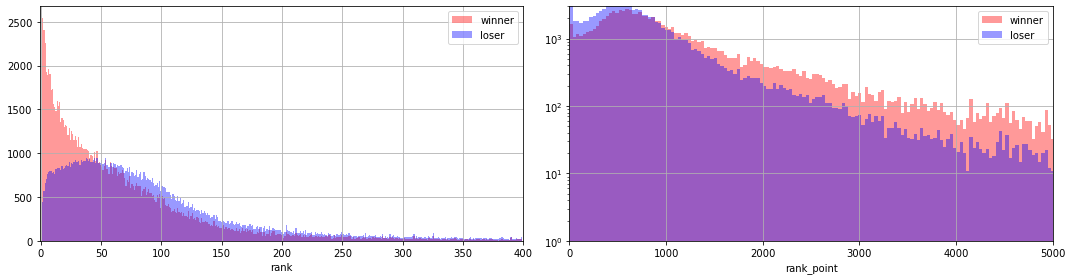

In [35]:
col_player_ps_3 = ['winner_rank','winner_rank_points','loser_rank','loser_rank_points']

plt.figure(figsize=(15,4))
#fig,axes = plt.subplots(2,4, sharex='col',figsize=(15,7))

plt.subplot(1,2,1)
plt.grid()
sns.distplot(matrix[col_player_ps_3[0]],kde=False,color='red',bins=range(1,400))
sns.distplot(matrix[col_player_ps_3[2]],kde=False,color='blue',bins=range(1,400))
plt.xlabel('rank')
plt.xlim(-1,400)
plt.legend(['winner','loser'])


plt.subplot(1,2,2)
plt.grid()
sns.distplot(matrix[col_player_ps_3[1]],kde=False,color='red',bins=500)
sns.distplot(matrix[col_player_ps_3[3]],kde=False,color='blue',bins=500)
plt.xlabel('rank_point')
plt.xlim(-1,5000)
plt.legend(['winner','loser'])
plt.yscale('log')
plt.ylim(1.0E0,3.0E3)
    
plt.tight_layout() 

Apparently, winner players with higher rank and rank point in general have won more than lost.

Next we analyze the performance difference for winner and loser players. We create new features of breakpoint converted, breakpoint saved ratio, and breakpoint converted ratio

In [36]:
# create a new feature that count the ratio of break point saved / break point faced: breakpoint saved ratio (bpsr)
# and breakpoint converted: w_bpc = l_bpFaced - l_bpSaved

# break point saved
matrix['w_bpsr'] = matrix['w_bpSaved']/matrix['w_bpFaced']
matrix['l_bpsr'] = matrix['l_bpSaved']/matrix['l_bpFaced']

# break point converted
matrix['w_bpc'] = matrix['l_bpFaced'] - matrix['l_bpSaved']
matrix['l_bpc'] = matrix['w_bpFaced'] - matrix['w_bpSaved']

# break point converted ratio
matrix['w_bpcr'] = matrix['w_bpc']/ matrix['l_bpFaced']
matrix['l_bpcr'] = matrix['l_bpc']/ matrix['w_bpFaced']

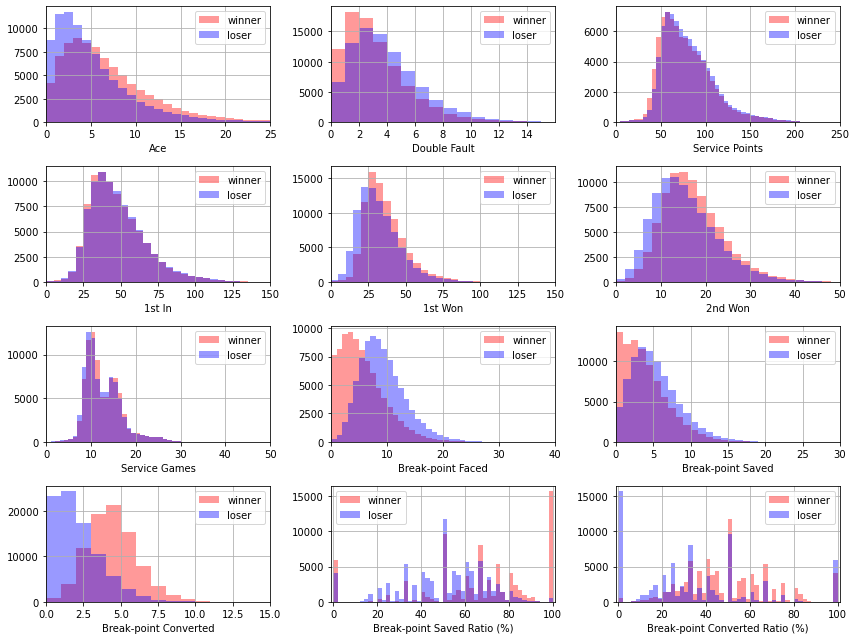

In [37]:
# player performance information
col_player_pf1 = ['w_ace','w_df','w_svpt', 'w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved','w_bpc','w_bpsr','w_bpcr',
                  'l_ace','l_df','l_svpt', 'l_1stIn','l_1stWon','l_2ndWon','l_SvGms','l_bpFaced','l_bpSaved','l_bpc','l_bpsr','l_bpcr'
             ]

plt.figure(figsize=(12,9))
#fig,axes = plt.subplots(2,4, sharex='col',figsize=(15,7))

plt.subplot(4,3,1)
plt.grid()
sns.distplot(matrix[col_player_pf1[0]],kde=False,color='red',bins=range(0,31,1))
sns.distplot(matrix[col_player_pf1[12]],kde=False,color='blue',bins=range(0,31,1))
plt.xlabel('Ace')
plt.xlim(0,25)
plt.legend(['winner','loser'])

plt.subplot(4,3,2)
plt.grid()
sns.distplot(matrix[col_player_pf1[1]],kde=False,color='red',bins=range(0,21,1))
sns.distplot(matrix[col_player_pf1[13]],kde=False,color='blue',bins=range(0,21,1))
plt.xlabel('Double Fault')
plt.xlim(0,16)
plt.legend(['winner','loser'])
plt.xticks([0,2,4,6,8,10,12,14])

plt.subplot(4,3,3)
plt.grid()
sns.distplot(matrix[col_player_pf1[2]],kde=False,color='red',bins=range(0,301,5))
sns.distplot(matrix[col_player_pf1[14]],kde=False,color='blue',bins=range(0,301,5))
plt.xlabel('Service Points')
plt.xlim(0,250)
plt.legend(['winner','loser'])

plt.subplot(4,3,4)
plt.grid()
sns.distplot(matrix[col_player_pf1[3]],kde=False,color='red',bins=range(0,201,5))
sns.distplot(matrix[col_player_pf1[15]],kde=False,color='blue',bins=range(0,201,5))
plt.xlabel('1st In')
plt.xlim(0,150)
plt.legend(['winner','loser'])

plt.subplot(4,3,5)
plt.grid()
sns.distplot(matrix[col_player_pf1[4]],kde=False,color='red',bins=range(0,201,5))
sns.distplot(matrix[col_player_pf1[16]],kde=False,color='blue',bins=range(0,201,5))
plt.xlabel('1st Won')
plt.xlim(0,150)
plt.legend(['winner','loser'])

plt.subplot(4,3,6)
plt.grid()
sns.distplot(matrix[col_player_pf1[5]],kde=False,color='red',bins=range(0,81,2))
sns.distplot(matrix[col_player_pf1[17]],kde=False,color='blue',bins=range(0,81,2))
plt.xlabel('2nd Won')
plt.xlim(0,50)
plt.legend(['winner','loser'])

plt.subplot(4,3,7)
plt.grid()
sns.distplot(matrix[col_player_pf1[6]],kde=False,color='red',bins=range(0,81,1))
sns.distplot(matrix[col_player_pf1[18]],kde=False,color='blue',bins=range(0,81,1))
plt.xlabel('Service Games')
plt.xlim(0,50)
plt.legend(['winner','loser'])

plt.subplot(4,3,8)
plt.grid()
sns.distplot(matrix[col_player_pf1[7]],kde=False,color='red',bins=range(0,51,1))
sns.distplot(matrix[col_player_pf1[19]],kde=False,color='blue',bins=range(0,51,1))
plt.xlabel('Break-point Faced')
plt.xlim(0,40)
plt.legend(['winner','loser'])

plt.subplot(4,3,9)
plt.grid()
sns.distplot(matrix[col_player_pf1[8]],kde=False,color='red',bins=range(0,51,1))
sns.distplot(matrix[col_player_pf1[20]],kde=False,color='blue',bins=range(0,51,1))
plt.xlabel('Break-point Saved')
plt.xlim(0,30)
plt.legend(['winner','loser'])

plt.subplot(4,3,10)
plt.grid()
sns.distplot(matrix[col_player_pf1[9]],kde=False,color='red',bins=range(0,21,1))
sns.distplot(matrix[col_player_pf1[21]],kde=False,color='blue',bins=range(0,21,1))
plt.xlabel('Break-point Converted')
plt.xlim(0,15)
plt.legend(['winner','loser'])

plt.subplot(4,3,11)
plt.grid()
sns.distplot(matrix[col_player_pf1[10]]*100,kde=False,color='red',bins=range(0,101,2))
sns.distplot(matrix[col_player_pf1[22]]*100,kde=False,color='blue',bins=range(0,101,2))
plt.xlabel('Break-point Saved Ratio (%)')
plt.xlim(-1,101)
plt.legend(['winner','loser'])

plt.subplot(4,3,12)
plt.grid()
sns.distplot(matrix[col_player_pf1[11]]*100,kde=False,color='red',bins=range(0,101,2))
sns.distplot(matrix[col_player_pf1[23]]*100,kde=False,color='blue',bins=range(0,101,2))
plt.xlabel('Break-point Converted Ratio (%)')
plt.xlim(-1,101)
plt.legend(['winner','loser'])
     
plt.tight_layout() 

* Winner players tend to have higher number of ace, 1st won, 2 won and lower number of double fault, break-point saved and break-point faced.

In [38]:
print('winner_SvGms.sum():',matrix.w_SvGms.sum())
print('loser_SvGms.sum():',matrix.l_SvGms.sum())
print('')
print('winner_bpSaved.sum():',matrix.w_bpSaved.sum())
print('loser_bpSaved.sum():',matrix.l_bpSaved.sum())
print('')
print('winner_bpFaced.sum():',matrix.w_bpFaced.sum())
print('loser_bpFaced.sum():',matrix.l_bpFaced.sum())

winner_SvGms.sum(): 1064929.0
loser_SvGms.sum(): 1048028.0

winner_bpSaved.sum(): 303583.0
loser_bpSaved.sum(): 413993.0

winner_bpFaced.sum(): 444914.0
loser_bpFaced.sum(): 752876.0


In [39]:
for i in range(1,6):
    
    matrix['diff_set_'+str(i)] = matrix['winner_set_'+str(i)] - matrix['loser_set_'+str(i)]

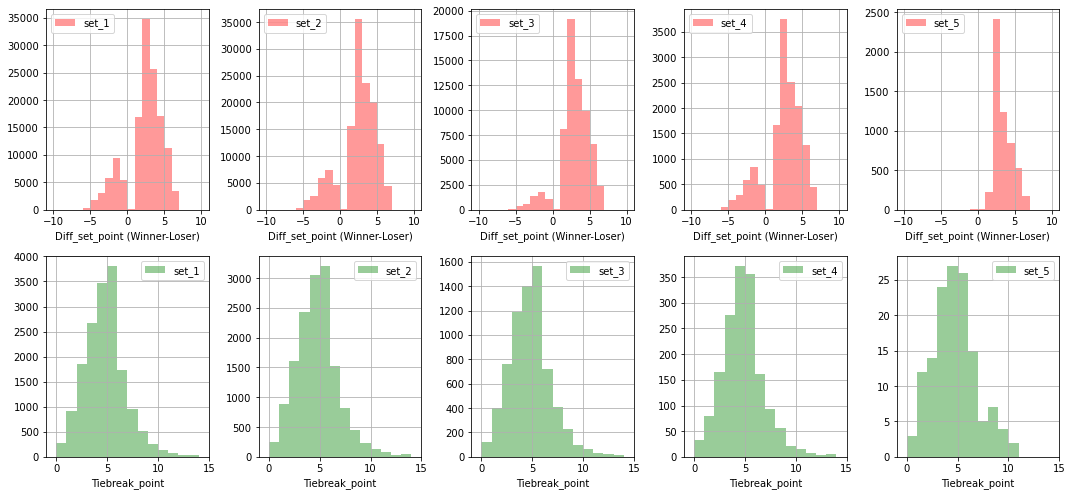

In [40]:
# player performance point

col_player_pf2 = ['diff_set_1','diff_set_2','diff_set_3','diff_set_4','diff_set_5',
                 'set_1_tb','set_2_tb','set_3_tb','set_4_tb','set_5_tb']

plt.figure(figsize=(15,7))

for i in range(0,5):
    
    plt.subplot(2,5,i+1)
    plt.grid()
    sns.distplot(matrix[col_player_pf2[i]],kde=False,color='red',bins=range(-10,10,1))
    plt.xlabel('Diff_set_point (Winner-Loser)')
    plt.xlim(-11,11)
    plt.legend(['set_'+str(i+1)])
    
    plt.subplot(2,5,i+6)
    plt.grid()
    sns.distplot(matrix[col_player_pf2[i+5]],kde=False,color='green',bins=range(0,15,1))
    plt.xlabel('Tiebreak_point')
    plt.legend(['set_'+str(i+1)])
    plt.xlim(-1,15)
    
     
plt.tight_layout() 

* Correlation Analysis

In [41]:
# we convert the seed information to numeric. If the seed information is digit, use the number; if it is others, use the draw size
matrix['winner_seed_code'] = matrix['winner_seed'].map(lambda x: float(x) if x.isdigit() else 0, na_action = 'ignore')
matrix['loser_seed_code'] = matrix['loser_seed'].map(lambda x: float(x) if x.isdigit() else 0, na_action = 'ignore')

matrix['winner_seed_code'] = matrix['winner_seed_code']+matrix['draw_size']*(matrix['winner_seed_code']==0)  
matrix['loser_seed_code'] = matrix['loser_seed_code']+matrix['draw_size']*(matrix['loser_seed_code']==0) 

In [42]:
matrix['winner_hand_code']=matrix['winner_hand'].map(lambda x: 1 if x=='R' else (-1 if x=='L' else 0), na_action = 'ignore')
matrix['loser_hand_code']=matrix['loser_hand'].map(lambda x: 1 if x=='R' else (-1 if x=='L' else 0), na_action = 'ignore')

In [43]:
matrix.head()

tourney_name surface  draw_size tourney_level tourney_date  match_num  \
0       Hobart    Hard       32.0             A   1979-12-31        1.0   
1       Hobart    Hard       32.0             A   1979-12-31        2.0   
2       Hobart    Hard       32.0             A   1979-12-31        3.0   
3       Hobart    Hard       32.0             A   1979-12-31        4.0   
4       Hobart    Hard       32.0             A   1979-12-31        5.0   

  winner_id winner_seed winner_entry     winner_name winner_hand  winner_ht  \
0    100315           1          NaN    Hank Pfister           R      193.0   
1    100397         NaN          NaN  Terry Rocavert           R      180.0   
2    107328         NaN          NaN    Jeremy Cohen           R        NaN   
3    100121           6          NaN   Raymond Moore           R      183.0   
4    100337           4          NaN  Mark Edmondson           R      185.0   

  winner_ioc  winner_age loser_id loser_seed loser_entry       loser_name  \
0        USA   26.225873   100713        NaN           Q  John Fitzgerald   
1        AUS   24.194387   100473        NaN         NaN   Glenn Petrovic   
2        USA         NaN   100265        NaN         NaN    Cliff Letcher   
3        RSA   33.352498   100550        NaN           Q        Brad Guan   
4        AUS   25.519507   100726        NaN         NaN  Greg Whitecross   

  loser_hand  loser_ht loser_ioc  loser_age        score  best_of round  \
0          R     183.0       AUS  19.006160  5-7 6-3 6-4      3.0   R32   
1          R       NaN       USA  22.828200      7-6 7-5      3.0   R32   
2          R       NaN       AUS  27.890486      6-2 6-3      3.0   R32   
3          R       NaN       AUS  21.475702  6-3 5-7 6-3      3.0   R32   
4          R     185.0       AUS  18.795346      6-3 6-3      3.0   R32   

   minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  \
0      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
1      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
2      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
3      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
4      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   

   w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  \
0        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
1        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
2        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
3        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
4        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   

   l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  \
0      NaN        NaN        NaN          NaN                 NaN         NaN   
1      NaN        NaN        NaN          NaN                 NaN         NaN   
2      NaN        NaN        NaN          NaN                 NaN         NaN   
3      NaN        NaN        NaN          NaN                 NaN         NaN   
4      NaN        NaN        NaN          NaN                 NaN         NaN   

   loser_rank_points  year  month  day  day_week  winner_set_1  loser_set_1  \
0                NaN  1979     12   31         0           5.0          7.0   
1                NaN  1979     12   31         0           7.0          6.0   
2                NaN  1979     12   31         0           6.0          2.0   
3                NaN  1979     12   31         0           6.0          3.0   
4                NaN  1979     12   31         0           6.0          3.0   

   winner_set_2  loser_set_2  winner_set_3  loser_set_3  winner_set_4  \
0           6.0          3.0           6.0          4.0           NaN   
1           7.0          5.0           NaN          NaN           NaN   
2           6.0          3.0           NaN          NaN           NaN   
3     

In [44]:
matrix.columns

Index(['tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date',
       'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_name',
       'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id',
       'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht',
       'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'year', 'month', 'day', 'day_week', 'winner_set_1', 'loser_set_1',
       'winner_set_2', 'loser_set_2', 'winner_set_3', 'loser_set_3',
       'winner_set_4', 'loser_set_4', 'winner_set_5', 'loser_set_5',
       'set_1_tb', 'set_2_tb', 'set_3_tb', 'set_4_tb', 'set_5_tb', 'w_bpsr',
       'l_bpsr', 'w_bpc', 'l_b

In [45]:
# choose the columns we want to do a correlation analysis, we will put the same performance statisics side by side
col_corr = ['year', 'month', 'day', 'day_week', 'best_of', 'minutes',            
       'diff_set_1', 'diff_set_2', 'diff_set_3', 'diff_set_4', 'diff_set_5',
            'set_1_tb', 'set_2_tb', 'set_3_tb', 'set_4_tb', 'set_5_tb',
            
            'winner_rank', 'loser_rank',
            'winner_rank_points', 'loser_rank_points',
            'winner_ht', 'loser_ht',
            'winner_age','loser_age', 
            'winner_hand_code','loser_hand_code',
            'winner_seed_code','loser_seed_code',
            
            'w_svpt', 'l_svpt',
             'w_ace', 'l_ace', 
            'w_df', 'l_df',              
            'w_1stIn', 'l_1stIn',
            'w_1stWon','l_1stWon', 
            'w_2ndWon', 'l_2ndWon', 
            'w_SvGms','l_SvGms',
            'w_bpFaced', 'l_bpFaced',
            'w_bpSaved', 'l_bpSaved',            
            'w_bpc','l_bpc',
            'w_bpsr','l_bpsr',
            'w_bpcr','l_bpcr',
       ]

In [46]:
matrix_corr = matrix[col_corr].corr(method='pearson') 

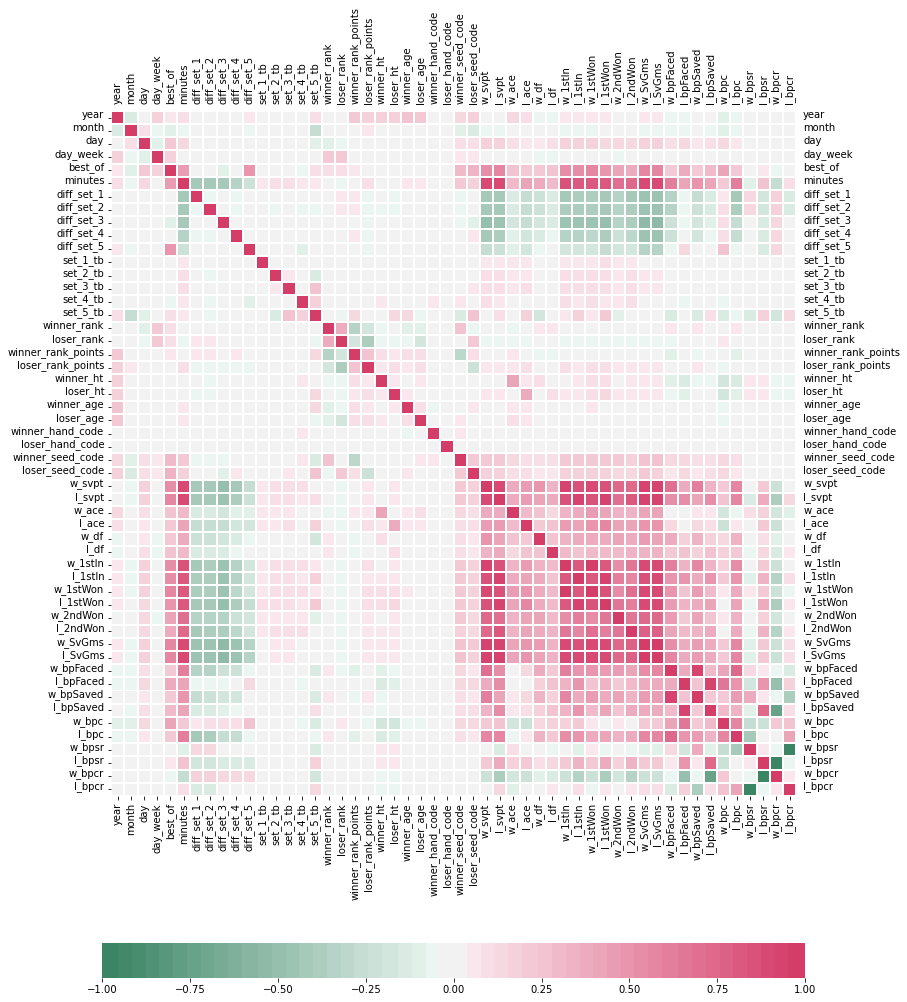

In [47]:

plt.figure(figsize=(18,18))

# since the correlation matrix  is symmetric,we can create a mask matrix to cover the upper triangular part if want
mask_ut=np.triu(np.ones(matrix_corr.shape)).astype(np.bool)

ax = sns.heatmap(matrix_corr,
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(150,0, n=50),
            square=True,
            cbar_kws={'orientation':'horizontal','shrink':0.7},     
            linewidths = 1,
            linecolor = 'white',
           # mask=mask_ut,
        )


#ax.xaxis.set_ticks_position('both')
#ax.xaxis.tick_top()
ax.tick_params(labeltop=True, labelright=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
    
);

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
   # horizontalalignment='right',
    verticalalignment='baseline',
    
    
);


Several interesting yet make sense observations:
* The longer the match, the smaller the set point difference, and the larger the performance statistics. (ace,bf,svpt,1stin,1stwon,2ndwon,svGms).

* 'Day' somehow havs a weak positive correlation with the match time and the performance statistics. So it looks like matches started at the later day of the month, players tend to play longer and have higher performance statistics.

* The set point difference have negative correlation with performance statistics. The larger the performance statistics generally indicate that the match is longer and fierce, which leads to smaller difference in the set points.

* The set point difference have a positive/negative correlation with the winner/loser's breakpoints converted.

* The tiebreak point of loser at set_5 have a positive correlation with the tiebreak point at set_3 and set_4. Also, it has positive correlation with the height of the loser and the age of the winner. That means if the loser player is tall and the winner player is older, the final battle is tough.

* There is no clear correlation in the set point difference in between sets.

* Ranking does not have a clear correlation with the performance statistics.  

* Player height have a positive correlation with the ace, taller players have higher successful rate in ace


#### * A more indepth analysis of the performance 

The above overall analysis shows that some features are correlated to the match points. We further analyze how these performance statistic change for different players over time. Does the short term averaged performance in the past provide accurate estimation of performance of a player in the coming game? 

In the final model, we want to input the performance and personal information of two players and provide a prediction of the match result in the future. To do so, the performance statistics can only come from the past. It's therefor a time-series + classification/regression problem. 

In [48]:
# A quick view on Roger Federer's performance, see if there is any difference when he won and lost games

player_name = 'Roger Federer'

player_id = matrix[(matrix['winner_name'] == player_name)]['winner_id'].unique()[0]
matrix_player = matrix[(matrix['winner_id'] == player_id) | (matrix['loser_id'] == player_id)].reset_index()
matrix_player.drop('index',axis=1,inplace=True)
win_pf = matrix_player[(matrix_player['winner_id'] == player_id)]
los_pf = matrix_player[(matrix_player['loser_id'] == player_id)]


In [49]:
print('{} has played in {} tournaments, won {} tournaments; in total played {} matches, and won {} matches.'
      .format(player_name,matrix_player['tourney_date'].nunique(),
              matrix_player[(matrix_player['winner_id'] == player_id)&(matrix_player['round'] =='F')].shape[0],
              matrix_player.shape[0],matrix_player[matrix_player['winner_id'] == player_id].shape[0])  )

Roger Federer has played in 389 tournaments, won 103 tournaments; in total played 1525 matches, and won 1250 matches.


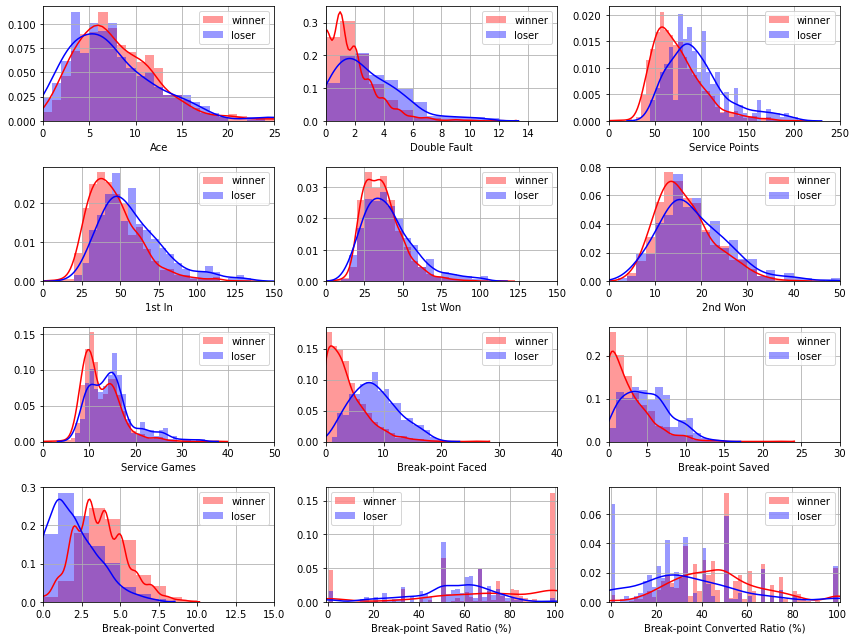

In [50]:
# player performance information
col_player_pf1 = ['w_ace','w_df','w_svpt', 'w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved','w_bpc','w_bpsr','w_bpcr',
                  'l_ace','l_df','l_svpt', 'l_1stIn','l_1stWon','l_2ndWon','l_SvGms','l_bpFaced','l_bpSaved','l_bpc','l_bpsr','l_bpcr'
             ]

plt.figure(figsize=(12,9))
#fig,axes = plt.subplots(2,4, sharex='col',figsize=(15,7))

plt.subplot(4,3,1)
plt.grid()
sns.distplot(win_pf[col_player_pf1[0]],kde=True,color='red',bins=range(0,31,1))
sns.distplot(los_pf[col_player_pf1[12]],kde=True,color='blue',bins=range(0,31,1))
plt.xlabel('Ace')
plt.xlim(0,25)
plt.legend(['winner','loser'])

plt.subplot(4,3,2)
plt.grid()
sns.distplot(win_pf[col_player_pf1[1]],kde=True,color='red',bins=range(0,21,1))
sns.distplot(los_pf[col_player_pf1[13]],kde=True,color='blue',bins=range(0,21,1))
plt.xlabel('Double Fault')
plt.xlim(0,16)
plt.legend(['winner','loser'])
plt.xticks([0,2,4,6,8,10,12,14])

plt.subplot(4,3,3)
plt.grid()
sns.distplot(win_pf[col_player_pf1[2]],kde=True,color='red',bins=range(0,301,5))
sns.distplot(los_pf[col_player_pf1[14]],kde=True,color='blue',bins=range(0,301,5))
plt.xlabel('Service Points')
plt.xlim(0,250)
plt.legend(['winner','loser'])

plt.subplot(4,3,4)
plt.grid()
sns.distplot(win_pf[col_player_pf1[3]],kde=True,color='red',bins=range(0,201,5))
sns.distplot(los_pf[col_player_pf1[15]],kde=True,color='blue',bins=range(0,201,5))
plt.xlabel('1st In')
plt.xlim(0,150)
plt.legend(['winner','loser'])

plt.subplot(4,3,5)
plt.grid()
sns.distplot(win_pf[col_player_pf1[4]],kde=True,color='red',bins=range(0,201,5))
sns.distplot(los_pf[col_player_pf1[16]],kde=True,color='blue',bins=range(0,201,5))
plt.xlabel('1st Won')
plt.xlim(0,150)
plt.legend(['winner','loser'])

plt.subplot(4,3,6)
plt.grid()
sns.distplot(win_pf[col_player_pf1[5]],kde=True,color='red',bins=range(0,81,2))
sns.distplot(los_pf[col_player_pf1[17]],kde=True,color='blue',bins=range(0,81,2))
plt.xlabel('2nd Won')
plt.xlim(0,50)
plt.legend(['winner','loser'])

plt.subplot(4,3,7)
plt.grid()
sns.distplot(win_pf[col_player_pf1[6]],kde=True,color='red',bins=range(0,81,1))
sns.distplot(los_pf[col_player_pf1[18]],kde=True,color='blue',bins=range(0,81,1))
plt.xlabel('Service Games')
plt.xlim(0,50)
plt.legend(['winner','loser'])

plt.subplot(4,3,8)
plt.grid()
sns.distplot(win_pf[col_player_pf1[7]],kde=True,color='red',bins=range(0,51,1))
sns.distplot(los_pf[col_player_pf1[19]],kde=True,color='blue',bins=range(0,51,1))
plt.xlabel('Break-point Faced')
plt.xlim(0,40)
plt.legend(['winner','loser'])

plt.subplot(4,3,9)
plt.grid()
sns.distplot(win_pf[col_player_pf1[8]],kde=True,color='red',bins=range(0,51,1))
sns.distplot(los_pf[col_player_pf1[20]],kde=True,color='blue',bins=range(0,51,1))
plt.xlabel('Break-point Saved')
plt.xlim(0,30)
plt.legend(['winner','loser'])

plt.subplot(4,3,10)
plt.grid()
sns.distplot(win_pf[col_player_pf1[9]],kde=True,color='red',bins=range(0,21,1))
sns.distplot(los_pf[col_player_pf1[21]],kde=True,color='blue',bins=range(0,21,1))
plt.xlabel('Break-point Converted')
plt.xlim(0,15)
plt.legend(['winner','loser'])

plt.subplot(4,3,11)
plt.grid()
sns.distplot(win_pf[col_player_pf1[10]]*100,kde=True,color='red',bins=range(0,101,2))
sns.distplot(los_pf[col_player_pf1[22]]*100,kde=True,color='blue',bins=range(0,101,2))
plt.xlabel('Break-point Saved Ratio (%)')
plt.xlim(-1,101)
plt.legend(['winner','loser'])

plt.subplot(4,3,12)
plt.grid()
sns.distplot(win_pf[col_player_pf1[11]]*100,kde=True,color='red',bins=range(0,101,2))
sns.distplot(los_pf[col_player_pf1[23]]*100,kde=True,color='blue',bins=range(0,101,2))
plt.xlabel('Break-point Converted Ratio (%)')
plt.xlim(-1,101)
plt.legend(['winner','loser'])
     
plt.tight_layout() 

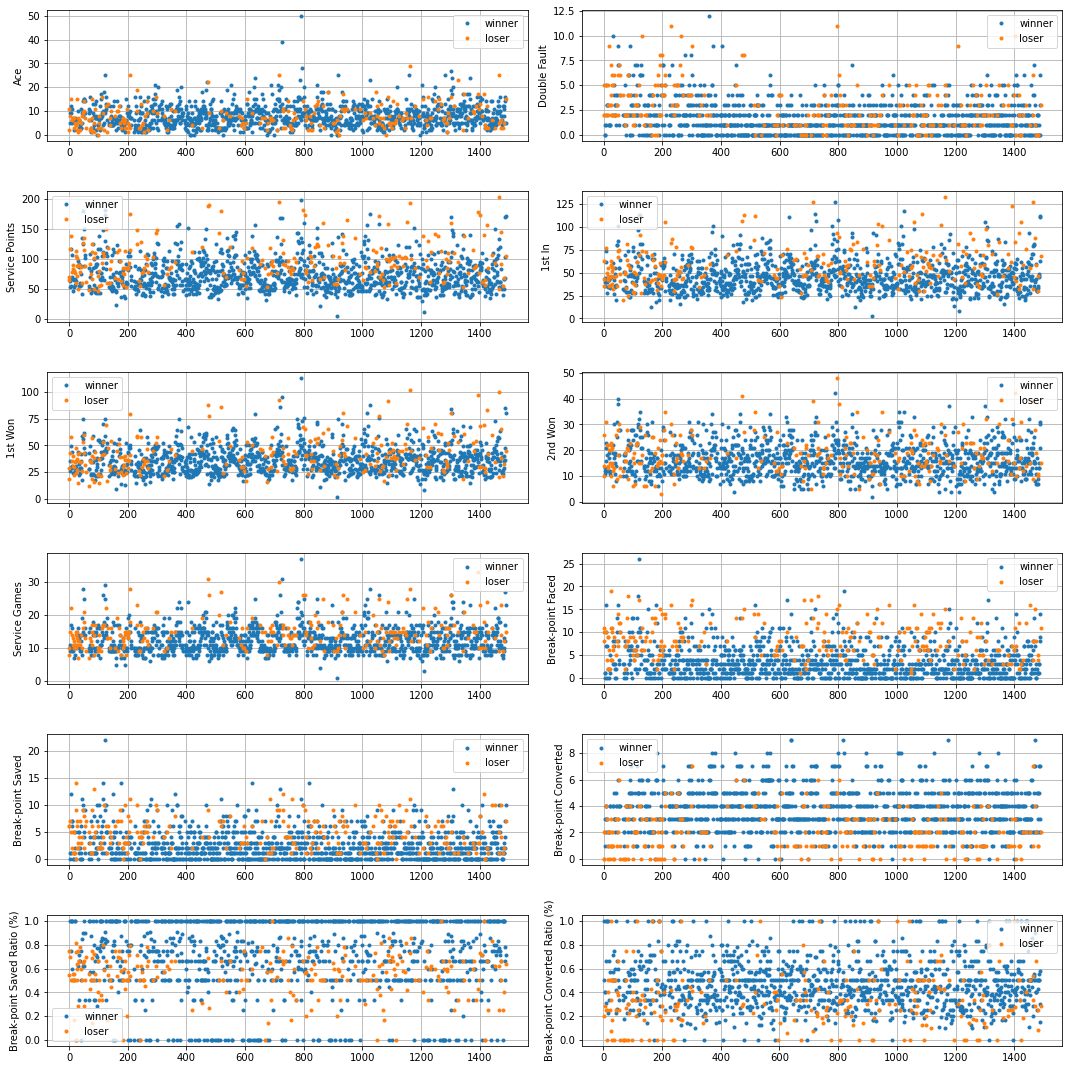

In [52]:
# plot these performance in a time-series

ylabel_list = ['Ace','Double Fault','Service Points','1st In','1st Won','2nd Won','Service Games',
          'Break-point Faced','Break-point Saved','Break-point Converted','Break-point Saved Ratio (%)','Break-point Converted Ratio (%)']

plt.figure(figsize=(15,15))

for i in range(0,12):
    plt.subplot(6,2,i+1)
    plt.grid()
    plt.plot(win_pf.index,win_pf[col_player_pf1[i]],'.')
    plt.plot(los_pf.index,los_pf[col_player_pf1[i+12]],'.')
    plt.ylabel(ylabel_list[i])  
    plt.legend(['winner','loser'])


plt.tight_layout()

It looks messy and quite hard to find any trend. We need to do aggregation based on the .  

In [53]:
col_match = ['tourney_name','surface','draw_size','tourney_level','tourney_date','best_of','match_num','round','minutes','year','month','day','day_week']
col_player_pf_w = ['winner_id','winner_name','winner_age','winner_seed_code','winner_rank','winner_rank_points','w_ace','w_df','w_svpt', 'w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved','w_bpc','w_bpsr','w_bpcr']
col_player_pf_l = ['loser_id','loser_name','loser_age','loser_seed_code','loser_rank', 'loser_rank_points','l_ace','l_df','l_svpt', 'l_1stIn','l_1stWon','l_2ndWon','l_SvGms','l_bpFaced','l_bpSaved','l_bpc','l_bpsr','l_bpcr']           


col_p1 = ['p1_id','p1_name','p1_age','p1_seed_code','p1_rank','p1_rank_points','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_SvGms','p1_bpFaced','p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr']
col_p2 = ['p2_id','p2_name','p2_age','p2_seed_code','p2_rank','p2_rank_points','p2_ace','p2_df','p2_svpt', 'p2_1stIn','p2_1stWon','p2_2ndWon','p2_SvGms','p2_bpFaced','p2_bpSaved','p2_bpc','p2_bpsr','p2_bpcr']

matrix_player_new = pd.DataFrame()
matrix_player_new[col_match] = matrix_player[col_match]


In [54]:
matrix_player_new[col_p1]=matrix_player[matrix_player['winner_id'] == player_id][col_player_pf_w]
matrix_player_new[col_p2]=matrix_player[matrix_player['winner_id'] == player_id][col_player_pf_l]
matrix_player_new['p1_win'] = matrix_player_new['p1_id'].map(lambda x: 1 if x==player_id else 1, na_action = 'ignore').fillna(0)
matrix_player_new

tourney_name surface  draw_size tourney_level tourney_date  best_of  \
0            Auckland    Hard       32.0             A   2000-01-10      3.0   
1         St. Poelten    Clay       32.0             A   2000-05-22      3.0   
2              Gstaad    Clay       32.0             A   2000-07-10      3.0   
3               Basel  Carpet       32.0             A   2000-10-23      3.0   
4               Basel  Carpet       32.0             A   2000-10-23      3.0   
...               ...     ...        ...           ...          ...      ...   
1485  Australian Open    Hard      128.0             G   2020-01-20      5.0   
1486  Australian Open    Hard      128.0             G   2020-01-20      5.0   
1487  Australian Open    Hard      128.0             G   2020-01-20      5.0   
1488  Australian Open    Hard      128.0             G   2020-01-20      5.0   
1489  Australian Open    Hard      128.0             G   2020-01-20      5.0   

      match_num round  minutes  year  month  day  day_week   p1_id  \
0           4.0   R32     68.0  2000      1   10         0     NaN   
1           4.0   R32     54.0  2000      5   22         0     NaN   
2           1.0   R32    137.0  2000      7   10         0     NaN   
3           2.0   R32     70.0  2000     10   23         0  103819   
4          17.0   R16     77.0  2000     10   23         0  103819   
...         ...   ...      ...   ...    ...  ...       ...     ...   
1485      187.0   R64     92.0  2020      1   20         0  103819   
1486      207.0   R32    243.0  2020      1   20         0  103819   
1487      217.0   R16    131.0  2020      1   20         0  103819   
1488      222.0    QF    211.0  2020      1   20         0  103819   
1489      225.0    SF    138.0  2020      1   20         0     NaN   

            p1_name     p1_age  p1_seed_code  p1_rank  p1_rank_points  p1_ace  \
0               NaN        NaN           NaN      NaN             NaN     NaN   
1               NaN        NaN           NaN      NaN             NaN     NaN   
2               NaN        NaN           NaN      NaN             NaN     NaN   
3     Roger Federer  19.208761           NaN     34.0          1018.0     9.0   
4     Roger Federer  19.208761           NaN     34.0          1018.0     5.0   
...             ...        ...           ...      ...             ...     ...   
1485  Roger Federer  38.450376           3.0      3.0          6590.0    14.0   
1486  Roger Federer  38.450376           3.0      3.0          6590.0    16.0   
1487  Roger Federer  38.450376           3.0      3.0          6590.0     5.0   
1488  Roger Federer  38.450376           3.0      3.0          6590.0     5.0   
1489            NaN        NaN           NaN      NaN             NaN     NaN   

      p1_df  p1_svpt  p1_1stIn  p1_1stWon  p1_2ndWon  p1_SvGms  p1_bpFaced  \
0       NaN      NaN       NaN        NaN        NaN       NaN         NaN   
1       NaN      NaN       NaN        NaN        NaN       NaN         NaN   
2       NaN      NaN       NaN        NaN        NaN       NaN         NaN   
3       0.0     53.0      36.0       26.0       12.0       9.0         1.0   
4       1.0     63.0      44.0       35.0       13.0      11.0         0.0   
...     ...      ...       ...        ...        ...       ...         ...   
1485    0.0     68.0      47.0       36.0       13.0      12.0         3.0   
1486    6.0    170.0     111.0       85.0       30.0      27.0         8.0   
1487    0.0    103.0      63.0       48.0       21.0      17.0         9.0   
1488    3.0    171.0     112.0       80.0       31.0      23.0        14.0   
1489    NaN      NaN       NaN        NaN        NaN       NaN         NaN   

      p1_bpSaved  p1_bpc   p1_bpsr   p1_bpcr   p2_id           p2_name  \
0            NaN     NaN       NaN       NaN     NaN               NaN   
1            NaN     NaN       NaN       NaN     NaN               NaN   
2            NaN     NaN       NaN       NaN     NaN               NaN   
3

In [55]:
for i in range(len(col_p1)):
    matrix_player_new[col_p1[i]].fillna(matrix_player[matrix_player['loser_id'] == player_id][col_player_pf_l[i]],inplace = True)
    matrix_player_new[col_p2[i]].fillna(matrix_player[matrix_player['loser_id'] == player_id][col_player_pf_w[i]],inplace = True)
    

In [56]:
matrix_player_new

tourney_name surface  draw_size tourney_level tourney_date  best_of  \
0            Auckland    Hard       32.0             A   2000-01-10      3.0   
1         St. Poelten    Clay       32.0             A   2000-05-22      3.0   
2              Gstaad    Clay       32.0             A   2000-07-10      3.0   
3               Basel  Carpet       32.0             A   2000-10-23      3.0   
4               Basel  Carpet       32.0             A   2000-10-23      3.0   
...               ...     ...        ...           ...          ...      ...   
1485  Australian Open    Hard      128.0             G   2020-01-20      5.0   
1486  Australian Open    Hard      128.0             G   2020-01-20      5.0   
1487  Australian Open    Hard      128.0             G   2020-01-20      5.0   
1488  Australian Open    Hard      128.0             G   2020-01-20      5.0   
1489  Australian Open    Hard      128.0             G   2020-01-20      5.0   

      match_num round  minutes  year  month  day  day_week   p1_id  \
0           4.0   R32     68.0  2000      1   10         0  103819   
1           4.0   R32     54.0  2000      5   22         0  103819   
2           1.0   R32    137.0  2000      7   10         0  103819   
3           2.0   R32     70.0  2000     10   23         0  103819   
4          17.0   R16     77.0  2000     10   23         0  103819   
...         ...   ...      ...   ...    ...  ...       ...     ...   
1485      187.0   R64     92.0  2020      1   20         0  103819   
1486      207.0   R32    243.0  2020      1   20         0  103819   
1487      217.0   R16    131.0  2020      1   20         0  103819   
1488      222.0    QF    211.0  2020      1   20         0  103819   
1489      225.0    SF    138.0  2020      1   20         0  103819   

            p1_name     p1_age  p1_seed_code  p1_rank  p1_rank_points  p1_ace  \
0     Roger Federer  18.422998           NaN     61.0           616.0    11.0   
1     Roger Federer  18.787132           8.0     54.0           735.0     2.0   
2     Roger Federer  18.921287           NaN     39.0           911.0     8.0   
3     Roger Federer  19.208761           NaN     34.0          1018.0     9.0   
4     Roger Federer  19.208761           NaN     34.0          1018.0     5.0   
...             ...        ...           ...      ...             ...     ...   
1485  Roger Federer  38.450376           3.0      3.0          6590.0    14.0   
1486  Roger Federer  38.450376           3.0      3.0          6590.0    16.0   
1487  Roger Federer  38.450376           3.0      3.0          6590.0     5.0   
1488  Roger Federer  38.450376           3.0      3.0          6590.0     5.0   
1489  Roger Federer  38.450376           3.0      3.0          6590.0    15.0   

      p1_df  p1_svpt  p1_1stIn  p1_1stWon  p1_2ndWon  p1_SvGms  p1_bpFaced  \
0       2.0     70.0      43.0       29.0       14.0      10.0         8.0   
1       2.0     64.0      36.0       19.0       10.0       8.0        11.0   
2       5.0    116.0      63.0       43.0       26.0      15.0        10.0   
3       0.0     53.0      36.0       26.0       12.0       9.0         1.0   
4       1.0     63.0      44.0       35.0       13.0      11.0         0.0   
...     ...      ...       ...        ...        ...       ...         ...   
1485    0.0     68.0      47.0       36.0       13.0      12.0         3.0   
1486    6.0    170.0     111.0       85.0       30.0      27.0         8.0   
1487    0.0    103.0      63.0       48.0       21.0      17.0         9.0   
1488    3.0    171.0     112.0       80.0       31.0      23.0        14.0   
1489    3.0    104.0      68.0       45.0       15.0      15.0        11.0   

      p1_bpSaved  p1_bpc   p1_bpsr   p1_bpcr   p2_id              p2_name  \
0            6.0     0.0  0.750000       NaN  103507  Juan Carlos Ferrero   
1            6.0     0.0  0.545455       NaN  103082      Markus Hantschk   
2            7.0     2.0  0.700000  0.200000  102374        Alex C

In [57]:
# let's have a look how the player's performance changed over the past 20 years
col_group = ['year','month']
col_add = ['p1_age','p1_seed_code','p1_rank','p1_rank_points','p1_win','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_SvGms','p1_bpFaced','p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr']

matrix_player_agg = matrix_player_new.groupby(col_group)[col_add].mean().reset_index()
matrix_player_agg

year  month     p1_age  p1_seed_code    p1_rank  p1_rank_points  \
0    2000      1  18.419804           NaN  62.500000      584.333333   
1    2000      2  18.521561      7.000000  63.357143      630.357143   
2    2000      3  18.614648           NaN  53.000000      753.000000   
3    2000      4  18.700890           NaN  50.000000      769.000000   
4    2000      5  18.789870      8.000000  53.000000      734.571429   
5    2000      6  18.856126      7.000000  36.800000      881.000000   
6    2000      7  18.946840           NaN  38.666667      911.000000   
7    2000      8  19.036277           NaN  39.800000      894.000000   
8    2000      9  19.112936           NaN  36.000000      933.000000   
9    2000     10  19.198308           NaN  31.272727     1042.181818   
10   2000     11  19.266256      7.000000  26.000000     1113.000000   
11   2001      1  19.450936      7.000000  28.363636     1080.000000   
12   2001      2  19.520627      6.000000  22.818182     1152.727273   
13   2001      3  19.607392     24.000000  23.400000     1194.000000   
14   2001      4  19.675108     15.000000  21.666667     1290.000000   
15   2001      5  19.779451     16.000000  18.000000     1456.666667   
16   2001      6  19.863564      9.083333  14.750000     1580.000000   
17   2001      7  19.917864      5.000000  14.000000     1825.000000   
18   2001      8  20.052019     13.000000  13.000000     1815.000000   
19   2001     10  20.189658      5.090909  12.545455     1771.363636   
20   2002      1  20.442163      4.571429  12.714286     1836.071429   
21   2002      2  20.525667      6.600000  13.285714     1832.142857   
22   2002      3  20.601415     12.000000  14.000000     1796.666667   
23   2002      4  20.684463      9.000000  11.000000     2045.000000   
24   2002      5  20.763518     10.625000  12.875000     1955.625000   
25   2002      6  20.849760      2.625000   9.500000     2153.125000   
26   2002      7  20.933607      5.333333  10.666667     1915.000000   
27   2002      8  21.035820     10.666667  13.166667     1924.166667   
28   2002      9  21.129090      5.000000  13.000000     1925.000000   
29   2002     10  21.189140      6.800000   9.466667     2094.666667   
30   2002     11  21.259411           NaN   6.000000     2290.000000   
31   2002     12  21.393566      1.000000   6.000000     2590.000000   
32   2003      1  21.428063      5.600000   6.000000     2498.000000   
33   2003      2  21.522930      1.285714   5.437500     2495.312500   
34   2003      3  21.597992      4.000000   4.000000     2753.333333   
35   2003      4  21.697467      1.000000   5.000000     2490.000000   
36   2003      5  21.750034      3.800000   5.000000     2640.500000   
37   2003      6  21.856719      2.750000   5.000000     2532.083333   
38   2003      7  21.911020      1.000000   3.000000     3575.000000   
39   2003      8  22.012071      2.636364   2.454545     3779.090909   
40   2003      9  22.102669           NaN   3.000000     3825.000000   
41   2003     10  22.183436      2.142857   3.000000     3860.714286   
42   2003     11  22.255989           NaN   3.000000     3625.000000   
43   2004      1  22.447639      2.000000   2.000000     4375.000000   
44   2004      2  22.508966      1.000000   1.000000     5192.000000   
45   2004      3  22.580319      1.000000   1.000000     5149.230769   
46   2004      4  22.658453           NaN   1.000000     5545.000000   
47   2004      5  22.761247      1.000000   1.000000     5288.181818   
48   2004      6  22.853297      1.000000   1.000000     5610.000000   
49   2004      7  22.938958      1.000000   1.000000     5640.000000   
50   2004      8  23.045585      1.000000   1.000000     5929.500000   
51   2004      9  23.137577      1.000000   1.000000     6760.000000   
52   2004     11  23.271732           NaN   1.000000     5585.000000   
53   2005      1  23.426794      1.000000   1.000000     6438.636364   
54   2005      2  23.530459      1.000000   1

In [58]:
matrix_player_year_ave = matrix_player_agg.groupby('year')[col_add].mean().reset_index()
matrix_player_year_dev = matrix_player_agg.groupby('year')[col_add].std().reset_index()

In [59]:
matrix_player_year_ave.head()

year     p1_age  p1_seed_code    p1_rank  p1_rank_points    p1_win  \
0  2000  18.860319      7.250000  44.581503      840.494884  0.460921   
1  2001  19.784069     11.130471  18.727104     1462.750842  0.623906   
2  2002  20.900635      6.747403  10.972917     2029.788690  0.672851   
3  2003  21.847126      2.690548   4.081095     3097.639487  0.792469   
4  2004  22.820377      1.125000   1.100000     5507.391259  0.934126   

     p1_ace     p1_df    p1_svpt   p1_1stIn  p1_1stWon  p1_2ndWon   p1_SvGms  \
0  7.170368  3.635455  86.313442  50.064697  35.551212  18.391450  12.746320   
1  7.493042  3.235241  81.715657  47.360382  34.795455  17.797811  12.726263   
2  6.387897  2.687434  73.517692  43.686243  32.686310  15.281978  11.475595   
3  7.912965  3.149307  75.355043  44.156818  33.774264  17.384004  12.170433   
4  7.760401  2.127369  75.391181  46.501752  36.387007  16.450400  12.432778   

   p1_bpFaced  p1_bpSaved    p1_bpc   p1_bpsr   p1_bpcr  
0    7.125996    4.553701  2.213874  0.607047  0.405765  
1    7.231762    4.756173  2.807688  0.644907  0.371880  
2    5.511177    3.611640  2.584656  0.687124  0.475515  
3    4.771797    3.105974  3.668225  0.622306  0.478514  
4    3.842345    2.765466  3.527369  0.715199  0.423145

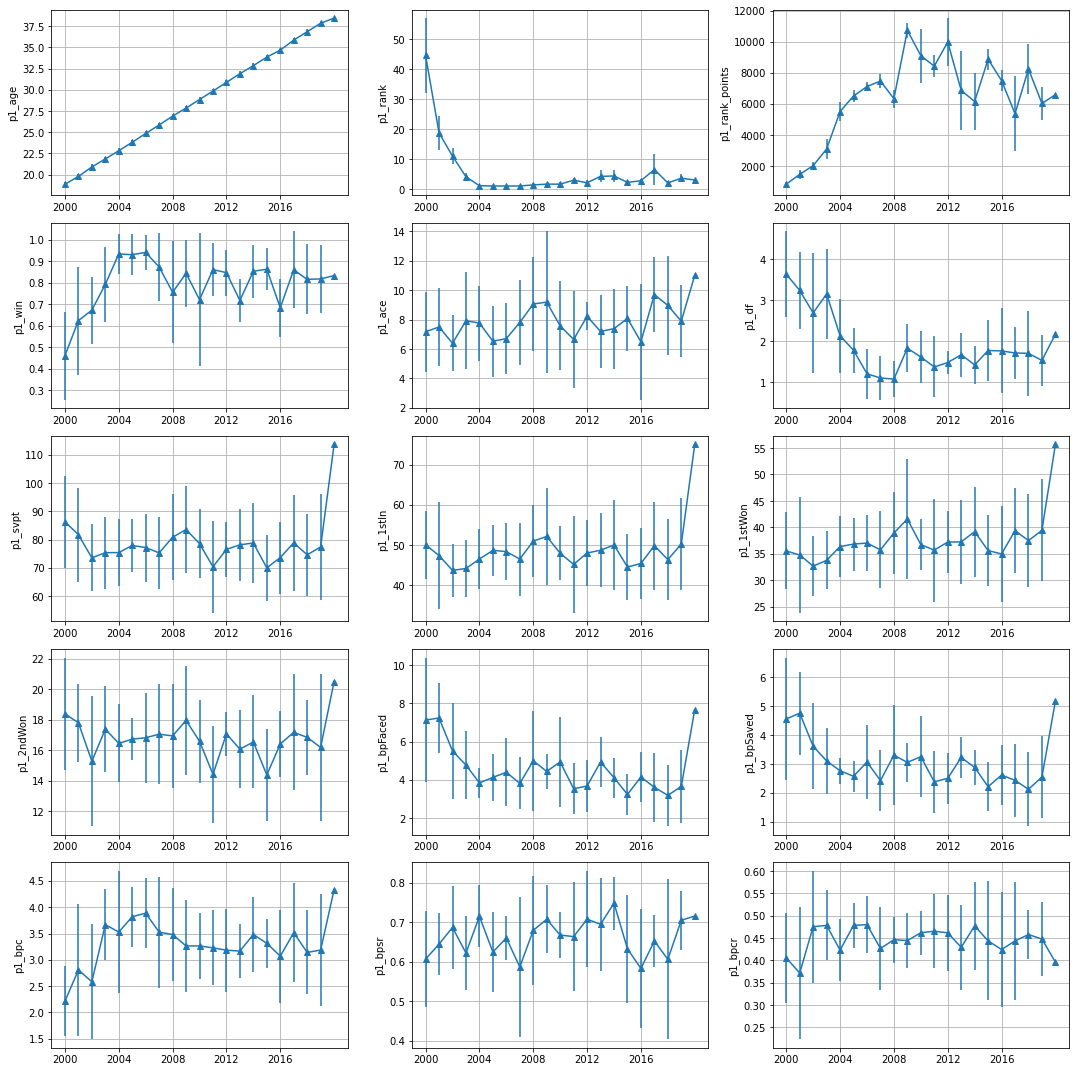

In [60]:
col_add = ['p1_age','p1_rank','p1_rank_points','p1_win','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_bpFaced','p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr']

plt.figure(figsize=(15,15))

for i in range(0,len(col_add)):
    
    plt.subplot(5,3,i+1)
    plt.grid()    
    #plt.plot(matrix_player_year_ave.year,matrix_player_year_ave[col_add[i]],'.-')
    plt.errorbar(matrix_player_year_ave.year, matrix_player_year_ave[col_add[i]], matrix_player_year_dev[col_add[i]], linestyle='-', marker='^')
    plt.ylabel(col_add[i])
    plt.xticks(matrix_player_year_ave.year[0:-1:4])
    


plt.tight_layout()

We can see that the overall performance peaked at around 2005 to 2007, when the player's ranking is No.1, but pretty much remained within top 5 since. 

Now we write the above code as a function, with the player's name as an input.

In [61]:
def player_analyse(matrix,player_name,year_min,year_max):
    
    player_id = matrix[(matrix['winner_name'] == player_name)]['winner_id'].unique()[0]
    matrix_player = matrix[(matrix['winner_id'] == player_id) | (matrix['loser_id'] == player_id)].reset_index()
    matrix_player.drop('index',axis=1,inplace=True)
    matrix_player = matrix_player[(matrix_player.year>=year_min) & (matrix_player.year<=year_max)]
    #win_pf = matrix_player[(matrix_player['winner_id'] == player_id)]
    #los_pf = matrix_player[(matrix_player['loser_id'] == player_id)]
    
    print('From {}-{},{} has played in {} tournaments, won {} tournaments; in total played {} matches, and won {} matches.'
      .format(year_min,year_max,player_name,matrix_player['tourney_date'].nunique(),
              matrix_player[(matrix_player['winner_id'] == player_id)&(matrix_player['round'] =='F')].shape[0],
              matrix_player.shape[0],matrix_player[matrix_player['winner_id'] == player_id].shape[0])  )
    
    
    col_match = ['tourney_name','surface','draw_size','tourney_level','tourney_date','best_of','match_num','round','minutes','year','month','day','day_week']
    col_player_pf_w = ['winner_id','winner_name','winner_age','winner_seed_code','winner_rank','winner_rank_points','w_ace','w_df','w_svpt', 'w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced','w_bpSaved','w_bpc','w_bpsr','w_bpcr']
    col_player_pf_l = ['loser_id','loser_name','loser_age','loser_seed_code','loser_rank', 'loser_rank_points','l_ace','l_df','l_svpt', 'l_1stIn','l_1stWon','l_2ndWon','l_SvGms','l_bpFaced','l_bpSaved','l_bpc','l_bpsr','l_bpcr']           


    col_p1 = ['p1_id','p1_name','p1_age','p1_seed_code','p1_rank','p1_rank_points','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_SvGms','p1_bpFaced','p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr']
    col_p2 = ['p2_id','p2_name','p2_age','p2_seed_code','p2_rank','p2_rank_points','p2_ace','p2_df','p2_svpt', 'p2_1stIn','p2_1stWon','p2_2ndWon','p2_SvGms','p2_bpFaced','p2_bpSaved','p2_bpc','p2_bpsr','p2_bpcr']

    matrix_player_new = pd.DataFrame()
    matrix_player_new[col_match] = matrix_player[col_match]
    
    matrix_player_new[col_p1]=matrix_player[matrix_player['winner_id'] == player_id][col_player_pf_w]
    matrix_player_new[col_p2]=matrix_player[matrix_player['winner_id'] == player_id][col_player_pf_l]
    matrix_player_new['p1_win'] = matrix_player_new['p1_id'].map(lambda x: 1 if x==player_id else 1, na_action = 'ignore').fillna(0)
     
    for i in range(len(col_p1)):
        matrix_player_new[col_p1[i]].fillna(matrix_player[matrix_player['loser_id'] == player_id][col_player_pf_l[i]],inplace = True)
        matrix_player_new[col_p2[i]].fillna(matrix_player[matrix_player['loser_id'] == player_id][col_player_pf_w[i]],inplace = True)

    col_add = ['p1_age','p1_rank','p1_rank_points','p1_win','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_bpFaced','p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr']
    
    matrix_player_year_ave = matrix_player_new.groupby('year')[col_add].mean().reset_index()
    matrix_player_year_dev = matrix_player_new.groupby('year')[col_add].std().reset_index()
    
    return matrix_player_new,matrix_player_year_ave,matrix_player_year_dev
    
    

Now compare the top 3 players: Roger Federer,Rafael Nadal,Novak Djokovic

In [62]:

player_Federer,year_ave_Federer,year_dev_Federer = player_analyse(matrix,'Roger Federer',2005,2019)
player_Nadal,year_ave_Nadal,year_dev_Nadal = player_analyse(matrix,'Rafael Nadal',2005,2019)
player_Djokovic,year_ave_Djokovic,year_dev_Djokovic = player_analyse(matrix,'Novak Djokovic',2005,2019)


From 2005-2019,Roger Federer has played in 244 tournaments, won 81 tournaments; in total played 1090 matches, and won 932 matches.
From 2005-2019,Rafael Nadal has played in 266 tournaments, won 83 tournaments; in total played 1112 matches, and won 940 matches.
From 2005-2019,Novak Djokovic has played in 272 tournaments, won 77 tournaments; in total played 1087 matches, and won 903 matches.


<Figure size 1080x1080 with 0 Axes>

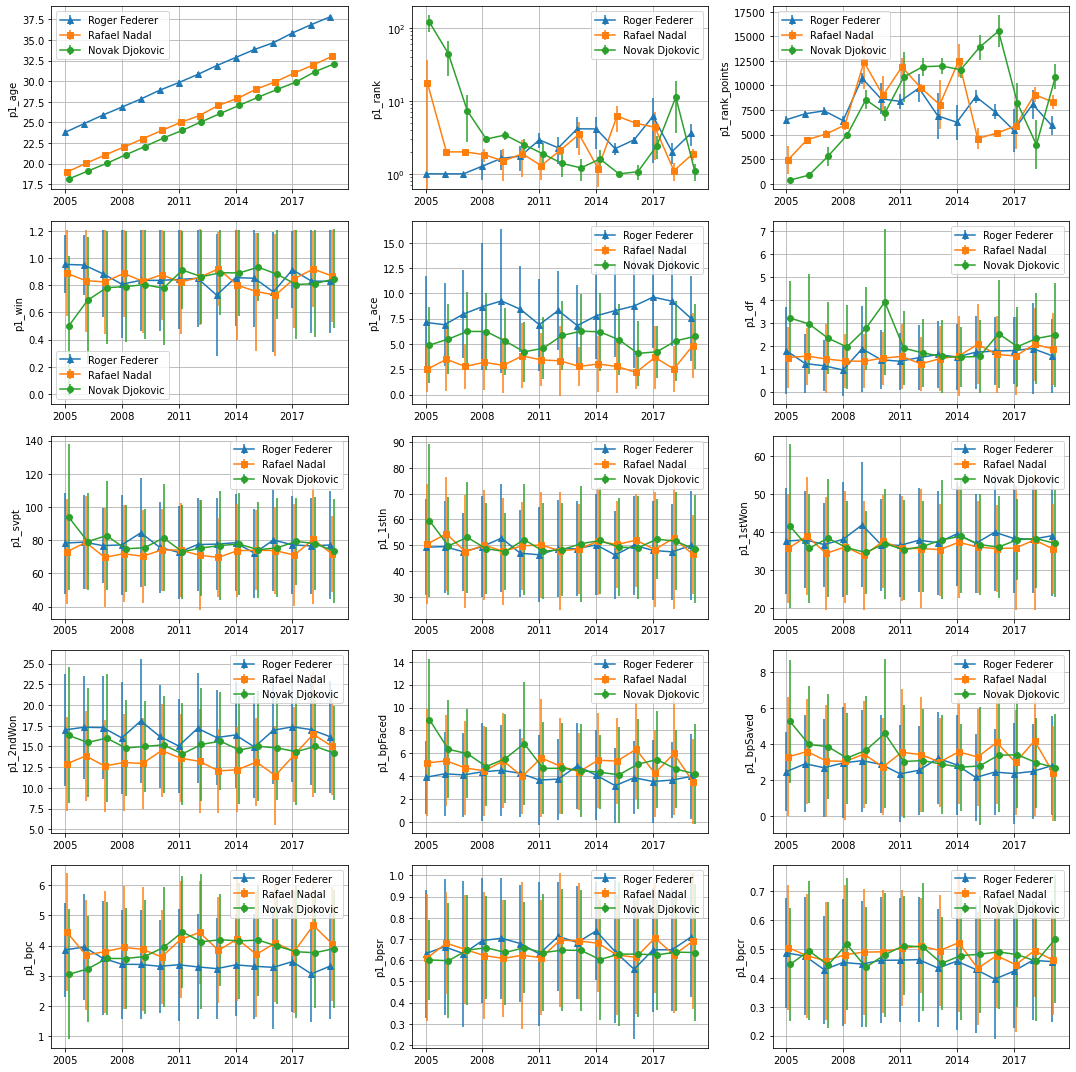

In [63]:
plt.figure(figsize=(15,15))
col_add = ['p1_age','p1_rank','p1_rank_points','p1_win','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_bpFaced','p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr']
    
plt.figure(figsize=(15,15))
    
for i in range(0,len(col_add)):    
    plt.subplot(5,3,i+1)
    plt.grid()    
    #plt.plot(matrix_player_year_ave.year,matrix_player_year_ave[col_add[i]],'.-')
    plt.errorbar(year_ave_Federer.year, year_ave_Federer[col_add[i]], year_dev_Federer[col_add[i]], linestyle='-', marker='^');
    plt.errorbar(0.1+year_ave_Nadal.year, year_ave_Nadal[col_add[i]], year_dev_Nadal[col_add[i]], linestyle='-', marker='s');
    plt.errorbar(0.2+year_ave_Djokovic.year, year_ave_Djokovic[col_add[i]], year_dev_Djokovic[col_add[i]], linestyle='-', marker='o');

    plt.legend(['Roger Federer','Rafael Nadal','Novak Djokovic']);
    plt.ylabel(col_add[i]);
    if col_add[i] == 'p1_rank':
        plt.yscale('log')
    plt.xticks(year_ave_Federer.year[0:-1:3]);
        
plt.tight_layout()

The performance statistics of the three top players are quite close in most aspects. There are a couple of metrics that showed noticable difference:
* Number of ace, 1stWon, 2ndWond, Federer>Djokovic>Nadal.
* BPC & BPCR: Nadel~Djokovic > Federer

See the competetion records of these three players

In [64]:
# we run a moving average of 5 years and calculate the winning ratio of the player over other players
# take Federer ras an example

col_group = ['p2_name']


group0 = pd.DataFrame()

for i in range(2009,2020):

    group = player_Federer[(player_Federer.year<=i)&(player_Federer.year>=i-4)].groupby(col_group).agg({'p1_win':'count'}).reset_index()
    group.rename(columns={'p1_win':'comp_cnt_past_5yr'},inplace=True)
    group1 = player_Federer[(player_Federer.year<=i)&(player_Federer.year>=i-4)].groupby(col_group).agg({'p1_win':'sum'}).reset_index()
    group1.rename(columns={'p1_win':'win_cnt_past_5yr'},inplace=True)

    group['win_cnt_past_5yr']=group1['win_cnt_past_5yr']

    group['year'] = i
    group['year']=group['year'].astype(np.int64)
    
    
    group0 = pd.concat([group0,group],ignore_index=True,sort = True)

group0['win_ratio_past_5yr']=group0['win_cnt_past_5yr']/group0['comp_cnt_past_5yr']
group0


comp_cnt_past_5yr             p2_name  win_cnt_past_5yr  year  \
0                     1         Alan Mackin               1.0  2009   
1                     2     Albert Montanes               2.0  2009   
2                     2      Alberto Martin               2.0  2009   
3                     1     Alejandro Falla               1.0  2009   
4                     4        Andre Agassi               4.0  2009   
...                 ...                 ...               ...   ...   
1348                  8       Tomas Berdych               8.0  2019   
1349                  1          Tommy Haas               0.0  2019   
1350                  1         Yen Hsun Lu               1.0  2019   
1351                  1  Yoshihito Nishioka               1.0  2019   
1352                  1       Yuichi Sugita               1.0  2019   

      win_ratio_past_5yr  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    1.0  
...                  ...  
1348                 1.0  
1349                 0.0  
1350                 1.0  
1351                 1.0  
1352                 1.0  

[1353 rows x 5 columns]

In [65]:
# see the top 5 opponents 
player_Federer_opponents = pd.DataFrame()
col_group = ['p2_name']
player_Federer_opponents['num_comp'] = player_Federer.groupby(col_group)['p2_name'].count().sort_values(ascending=False)
#player_Federer_opponents['num_win'] = player_Federer.groupby(col_group)['p2_name'].count().sort_values(ascending=False)
player_Federer_opponents['num_win'] = player_Federer.groupby(col_group)['p1_win'].sum()
player_Federer_opponents['win_ratio'] = player_Federer_opponents['num_win']/player_Federer_opponents['num_comp']
player_Federer_opponents = player_Federer_opponents.reset_index()
player_Federer_opponents

p2_name  num_comp  num_win  win_ratio
0            Novak Djokovic        50     23.0   0.460000
1              Rafael Nadal        40     17.0   0.425000
2             Stan Wawrinka        27     24.0   0.888889
3             Tomas Berdych        25     20.0   0.800000
4     Juan Martin del Potro        25     18.0   0.720000
5               Andy Murray        25     14.0   0.560000
6           Richard Gasquet        20     18.0   0.900000
7        Jo-Wilfried Tsonga        19     12.0   0.631579
8         Nikolay Davydenko        18     16.0   0.888889
9              David Ferrer        16     16.0   1.000000
10               Tommy Haas        15     13.0   0.866667
11          Robin Soderling        15     14.0   0.933333
12            Andreas Seppi        15     14.0   0.933333
13             Andy Roddick        15     13.0   0.866667
14             Milos Raonic        15     12.0   0.800000
15    Philipp Kohlschreiber        15     15.0   1.000000
16             Gael Monfils        14     10.0   0.714286
17           Radek Stepanek        14     13.0   0.928571
18          Mikhail Youzhny        13     13.0   1.000000
19             Ivo Karlovic        12     11.0   0.916667
20           Lleyton Hewitt        12     10.0   0.833333
21         David Nalbandian        12      9.0   0.750000
22            Kei Nishikori        11      8.0   0.727273
23             David Goffin        11     10.0   0.909091
24        Fernando Gonzalez        11     10.0   0.909091
25              James Blake        11      9.0   0.818182
26          Feliciano Lopez        10     10.0   1.000000
27              Marin Cilic        10      9.0   0.900000
28            Ivan Ljubicic        10     10.0   1.000000
29          Jarkko Nieminen        10     10.0   1.000000
30             Gilles Simon         9      7.0   0.777778
31    Roberto Bautista Agut         9      9.0   1.000000
32           Nicolas Kiefer         9      9.0   1.000000
33           Olivier Rochus         8      8.0   1.000000
34         Julien Benneteau         8      6.0   0.750000
35               John Isner         8      6.0   0.750000
36            Florian Mayer         8      8.0   1.000000
37          Grigor Dimitrov         8      7.0   0.875000
38            Tommy Robredo         7      6.0   0.857143
39        Fernando Verdasco         7      7.0   1.000000
40         Alexander Zverev         7      3.0   0.428571
41             Benoit Paire         7      7.0   1.000000
42         Marcos Baghdatis         7      6.0   0.857143
43            Denis Istomin         7      7.0   1.000000
44          Alejandro Falla         7      7.0   1.000000
45            Dominic Thiem         7      2.0   0.285714
46           Kevin Anderson         7      6.0   0.857143
47      Juan Carlos Ferrero         6      6.0   1.000000
48              Borna Coric         6      4.0   0.666667
49       Paul Henri Mathieu         6      6.0   1.000000
50           Potito Starace         6      6.0   1.000000
51            Mischa Zverev         6      6.0   1.000000
52         Janko Tipsarevic         6      6.0   1.000000
53              Mario Ancic         6      6.0   1.000000
54               Mardy Fish         6      5.0   0.833333
55         Adrian Mannarino         6      6.0   1.000000
56          Dmitry Tursunov         5      5.0   1.000000
57          Guillermo Canas         5      3.0   0.600000
58             Nick Kyrgios         5      4.0   0.800000
59            Gilles Muller         5      5.0   1.000000
60           Ernests Gulbis         5      3.0   0.600000
61       Stefanos Tsitsipas         5      2.0   0.400000
62            Jeremy Chardy         5      4.0   0.800000
63           Victor Hanescu         5      5.0   1.000000
64          Nicolas Almagro         5      5.0   1.000000
65            Jurgen Melzer         5      4.0   0.800000
66              Marat Safin         5      4.0   0.800000
67      Alexandr Dolgopolov         5      5.0   1.000000
68          Albert

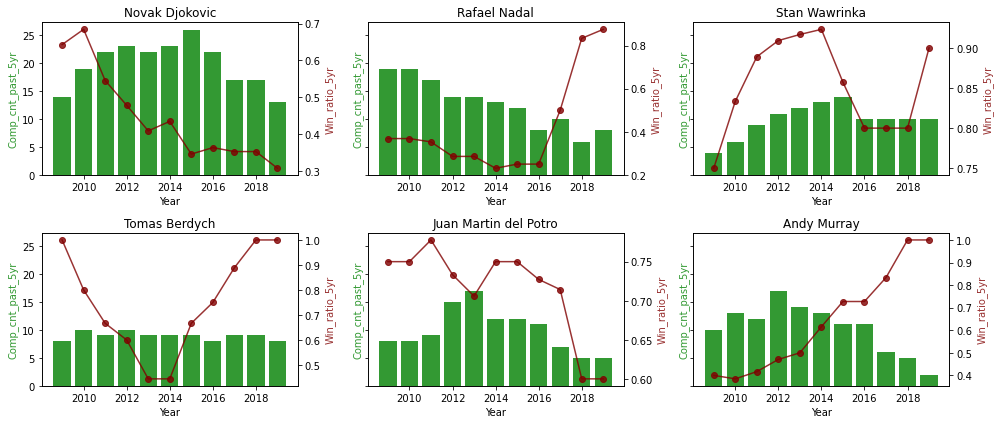

In [66]:
#plt.figure(figsize=(15,15))
name_opp = player_Federer_opponents[player_Federer_opponents['num_comp']>=25]['p2_name']
# plt.subplot(2,3,1)
# sns.lineplot(group0[group0.p2_name ==name_opp[0]]['year'],group0[group0.p2_name ==name_opp[0]]['win_ratio_past_5yr'])
# sns.barplot(group0[group0.p2_name ==name_opp[0]]['year'],group0[group0.p2_name ==name_opp[0]]['comp_cnt_past_5yr'])
fig, axes = plt.subplots(2,3, figsize = (14,6), sharey=True)

for i, ax in enumerate(axes):
    
    for j,ax1 in enumerate(ax):
     
        x = group0[group0.p2_name ==name_opp[len(ax)*i+j]]['year']
        y1 = group0[group0.p2_name ==name_opp[len(ax)*i+j]]['comp_cnt_past_5yr']
        y2 = group0[group0.p2_name ==name_opp[len(ax)*i+j]]['win_ratio_past_5yr']

        ax2 = ax1.twinx()
        ax1.bar(x, y1, color=(0,0.5,0,0.8))
        ax2.plot(x, y2, 'o-', color=(0.5,0,0,0.8) )
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Comp_cnt_past_5yr', color=(0,0.5,0,0.8))
        ax2.set_ylabel('Win_ratio_5yr', color=(0.5,0,0,0.8))
        plt.title(name_opp[len(ax)*i+j])
        
plt.tight_layout()

In [67]:
# for i, ax in enumerate(axes):
#     for j,ax1 in enumerate(ax):
#         print(len(ax)*i+j,name_opp[i+j])

Now we write a function to realize the above function of calculating the moving averaged competition record of a player with other players, as well as the major opponents over the defined years.  

In [68]:

def win_record_mavg(matrix,player_name,year_min,year_max):
    
    # df is the dataframe with record of a player generated using function 'player_analyse()'
    
    df,year_ave,year_dev = player_analyse(matrix,player_name,year_min-4,year_max)
    
    group0 = pd.DataFrame()
    col_group = ['p2_name']

    for i in range(year_min,year_max):

        group = df[(df.year<=i)&(df.year>=i-4)].groupby(col_group).agg({'p1_win':'count'}).reset_index()
        group.rename(columns={'p1_win':'comp_cnt_past_5yr'},inplace=True)
        group1 = df[(df.year<=i)&(df.year>=i-4)].groupby(col_group).agg({'p1_win':'sum'}).reset_index()
        group1.rename(columns={'p1_win':'win_cnt_past_5yr'},inplace=True)

        group['win_cnt_past_5yr']=group1['win_cnt_past_5yr']

        group['year'] = i
        group['year']=group['year'].astype(np.int64)


        group0 = pd.concat([group0,group],ignore_index=True,sort = True)

    group0['win_ratio_past_5yr']=group0['win_cnt_past_5yr']/group0['comp_cnt_past_5yr']
    
    player_opponents = pd.DataFrame()
    col_group = ['p2_name']
    player_opponents['num_comp'] = df[(df.year<=year_max)&(df.year>=year_min-4)].groupby(col_group)['p2_name'].count().sort_values(ascending=False)
    player_opponents['num_win'] = df[(df.year<=year_max)&(df.year>=year_min-4)].groupby(col_group)['p1_win'].sum()
    player_opponents['win_ratio'] = player_opponents['num_win']/player_opponents['num_comp']
    player_opponents = player_opponents.reset_index()
    
    
    return group0,player_opponents

From 2005-2020,Roger Federer has played in 245 tournaments, won 81 tournaments; in total played 1096 matches, and won 937 matches.
From 2005-2020,Rafael Nadal has played in 269 tournaments, won 84 tournaments; in total played 1128 matches, and won 953 matches.
From 2005-2020,Novak Djokovic has played in 275 tournaments, won 80 tournaments; in total played 1105 matches, and won 921 matches.


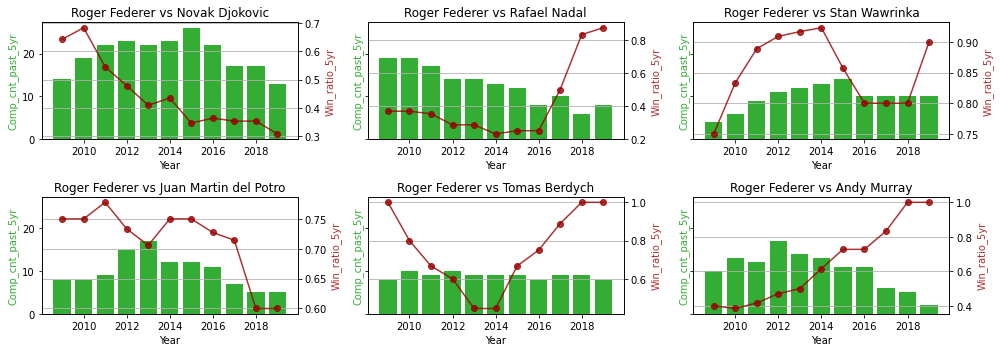

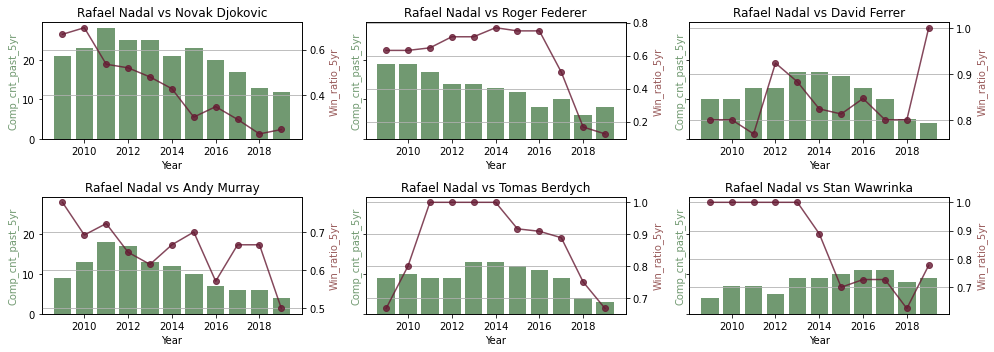

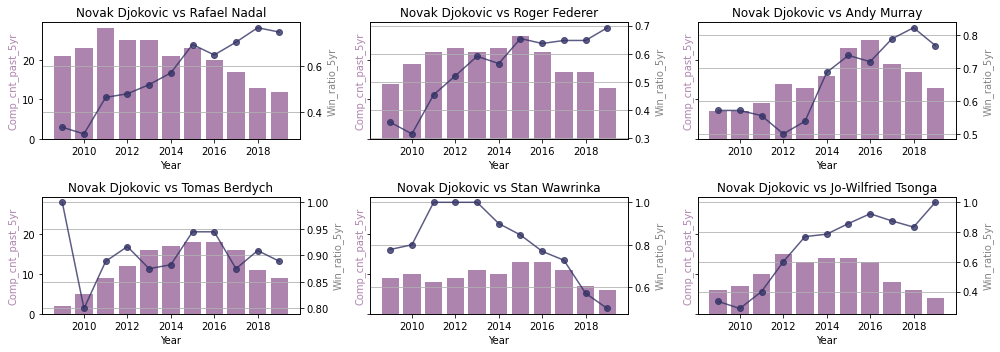

In [69]:
# choose player and get the moving average record and top opponents

player_list = ['Roger Federer','Rafael Nadal','Novak Djokovic']

for m in range(0,3):
    player = player_list[m]
    player_5y,player_opponents = win_record_mavg(matrix,player,2009,2020)

    # display the top 6 opponents
    name_opp = player_opponents[player_opponents.index<6]['p2_name']

    fig, axes = plt.subplots(2,3, figsize = (14,5), sharey=True)

    for i, ax in enumerate(axes):

        for j,ax1 in enumerate(ax):

            x = player_5y[player_5y.p2_name ==name_opp[len(ax)*i+j]]['year']
            y1 = player_5y[player_5y.p2_name ==name_opp[len(ax)*i+j]]['comp_cnt_past_5yr']
            y2 = player_5y[player_5y.p2_name ==name_opp[len(ax)*i+j]]['win_ratio_past_5yr']

            ax2 = ax1.twinx()
            ax1.bar(x, y1, color=(m*0.3,0.6-m*0.1,m*0.3,0.8))   # change the color for different players
            ax2.plot(x, y2, 'o-', color=(0.6-m*0.2,m*0.1,m*0.2,0.8) )
            ax1.set_xlabel('Year')
            ax1.set_ylabel('Comp_cnt_past_5yr', color=(m*0.3,0.6-m*0.1,m*0.3,0.8))
            ax2.set_ylabel('Win_ratio_5yr', color=(0.6-m*0.1,m*0.2,m*0.2,0.8))
            plt.title(player+' vs '+name_opp[len(ax)*i+j])
            plt.grid()

    plt.tight_layout()

We calculate the competition historic information for any two players in the original data set 'matrix'. We calculate the moving average of winning ratio over the last n games.

In [70]:
matrix.head()

tourney_name surface  draw_size tourney_level tourney_date  match_num  \
0     Auckland    Hard       32.0             A   2000-01-10        1.0   
1     Auckland    Hard       32.0             A   2000-01-10        2.0   
2     Auckland    Hard       32.0             A   2000-01-10        3.0   
3     Auckland    Hard       32.0             A   2000-01-10        4.0   
4     Auckland    Hard       32.0             A   2000-01-10        5.0   

  winner_id winner_seed winner_entry          winner_name winner_hand  \
0    103163           1          NaN           Tommy Haas           R   
1    102607         NaN            Q        Juan Balcells           R   
2    103252         NaN          NaN       Alberto Martin           R   
3    103507           7          NaN  Juan Carlos Ferrero           R   
4    102103         NaN            Q         Michael Sell           R   

   winner_ht winner_ioc  winner_age loser_id loser_seed loser_entry  \
0      188.0        GER   21.771389   101543        NaN         NaN   
1      190.0        ESP   24.558522   102644        NaN         NaN   
2      175.0        ESP   21.390828   102238        NaN         NaN   
3      183.0        ESP   19.909651   103819        NaN         NaN   
4      180.0        USA   27.381246   102765          4         NaN   

            loser_name loser_hand  loser_ht loser_ioc  loser_age  \
0         Jeff Tarango          L     180.0       USA  31.137577   
1     Franco Squillari          L     183.0       ARG  24.386037   
2  Alberto Berasategui          R     173.0       ESP  26.535250   
3        Roger Federer          R     185.0       SUI  18.422998   
4       Nicolas Escude          R     185.0       FRA  23.770021   

            score  best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  \
0     7-5 4-6 7-5      3.0   R32    108.0   18.0   4.0    96.0     49.0   
1         7-5 7-5      3.0   R32     85.0    5.0   3.0    76.0     52.0   
2         6-3 6-1      3.0   R32     56.0    0.0   0.0    55.0     35.0   
3         6-4 6-4      3.0   R32     68.0    5.0   1.0    53.0     28.0   
4  0-6 7-6(7) 6-1      3.0   R32    115.0    1.0   2.0    98.0     66.0   

   w_1stWon  w_2ndWon  w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  \
0      39.0      28.0     17.0        3.0        5.0    7.0   8.0   106.0   
1      39.0      13.0     12.0        5.0        6.0    5.0  10.0    74.0   
2      25.0      12.0      8.0        1.0        1.0    0.0   6.0    56.0   
3      26.0      15.0     10.0        0.0        0.0   11.0   2.0    70.0   
4      39.0      14.0     13.0        6.0       11.0    8.0   8.0    92.0   

   l_1stIn  l_1stWon  l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  winner_rank  \
0     55.0      39.0      29.0     17.0        4.0        7.0         11.0   
1     32.0      25.0      18.0     12.0        3.0        6.0        211.0   
2     33.0      20.0       7.0      8.0        7.0       11.0         48.0   
3     43.0      29.0      14.0     10.0        6.0        8.0         45.0   
4     46.0      34.0      18.0     12.0        5.0        9.0        167.0   

   winner_rank_points  loser_rank  loser_rank_points  year  month  day  \
0              1612.0        63.0              595.0  2000      1   10   
1               157.0        49.0              723.0  2000      1   10   
2               726.0        59.0              649.0  2000      1   10   
3               768.0        61.0              616.0  2000      1   10   
4               219.0        34.0              873.0  2000      1   10   

   day_week  winner_set_1  loser_set_1  winner_set_2  loser_set_2  \
0         0           7.0          5.0           4.0          6.0   
1         0           7.0          5.0           7.0          5.0   
2         0           6.0          3.0           6.0          1.0   
3         0           6.0          4.0           6.0          4.0   
4         0           0.0          6.0           7.0          6.0   

   winner_set_3  loser_set_3  win

In [53]:
# def win_record_mavg_last_n_games(matrix,player_name_1,player_name_2,n):

n1 = 20
n2 = 10


col_win_add = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms',
               'w_bpSaved', 'w_bpFaced', 'w_bpsr', 'w_bpc', 'w_bpcr','winner_rank', 'winner_rank_points', 
               'winner_set_1','winner_set_2', 'winner_set_3', 'winner_set_4', 'winner_set_5']

col_lose_add = ['l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 
                'l_bpSaved', 'l_bpFaced','l_bpsr', 'l_bpc', 'l_bpcr', 'loser_rank', 'loser_rank_points',
                'loser_set_1','loser_set_2', 'loser_set_3','loser_set_4', 'loser_set_5']

last_n1 = ['_last_'+str(n1)]*len(col_win_add)
last_n2 = ['_last_'+str(n2)]*len(col_win_add)

col_win_last_n1 = [c+l for c, l in zip(col_win_add, last_n1)]
col_lose_last_n1 = [c+l for c, l in zip(col_lose_add, last_n1)]
col_win_last_n2 = [c+l for c, l in zip(col_win_add, last_n2)]
col_lose_last_n2 = [c+l for c, l in zip(col_lose_add, last_n2)]

all_col = col_win_last_n1+col_lose_last_n1+col_win_last_n2+col_lose_last_n2

all_col = matrix.columns.tolist() +all_col
# add empty columns of new features
matrix = matrix.reindex(columns=all_col)
    
matrix.head()

index tourney_name surface  draw_size tourney_level tourney_date  \
0      0       Hobart    Hard       32.0             A   1979-12-31   
1      1       Hobart    Hard       32.0             A   1979-12-31   
2      2       Hobart    Hard       32.0             A   1979-12-31   
3      3       Hobart    Hard       32.0             A   1979-12-31   
4      4       Hobart    Hard       32.0             A   1979-12-31   

   match_num winner_id winner_seed winner_entry     winner_name winner_hand  \
0        1.0    100315           1          NaN    Hank Pfister           R   
1        2.0    100397         NaN          NaN  Terry Rocavert           R   
2        3.0    107328         NaN          NaN    Jeremy Cohen           R   
3        4.0    100121           6          NaN   Raymond Moore           R   
4        5.0    100337           4          NaN  Mark Edmondson           R   

   winner_ht winner_ioc  winner_age loser_id loser_seed loser_entry  \
0      193.0        USA   26.225873   100713        NaN           Q   
1      180.0        AUS   24.194387   100473        NaN         NaN   
2        NaN        USA         NaN   100265        NaN         NaN   
3      183.0        RSA   33.352498   100550        NaN           Q   
4      185.0        AUS   25.519507   100726        NaN         NaN   

        loser_name loser_hand  loser_ht loser_ioc  loser_age        score  \
0  John Fitzgerald          R     183.0       AUS  19.006160  5-7 6-3 6-4   
1   Glenn Petrovic          R       NaN       USA  22.828200      7-6 7-5   
2    Cliff Letcher          R       NaN       AUS  27.890486      6-2 6-3   
3        Brad Guan          R       NaN       AUS  21.475702  6-3 5-7 6-3   
4  Greg Whitecross          R     185.0       AUS  18.795346      6-3 6-3   

   best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  \
0      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
1      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
2      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
3      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
4      3.0   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   

   w_SvGms  w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  \
0      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN   
1      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN   
2      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN   
3      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN   
4      NaN        NaN        NaN    NaN   NaN     NaN      NaN       NaN   

   l_2ndWon  l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  \
0       NaN      NaN        NaN        NaN          NaN                 NaN   
1       NaN      NaN        NaN        NaN          NaN                 NaN   
2       NaN      NaN        NaN        NaN          NaN                 NaN   
3       NaN      NaN        NaN        NaN          NaN                 NaN   
4       NaN      NaN        NaN        NaN          NaN                 NaN   

   loser_rank  loser_rank_points  year  ...  l_bpSaved_last_20  \
0         NaN                NaN  1979  ...                NaN   
1         NaN                NaN  1979  ...                NaN   
2         NaN                NaN  1979  ...                NaN   
3         NaN                NaN  1979  ...                NaN   
4         NaN                NaN  1979  ...                NaN   

   l_bpFaced_last_20  l_bpsr_last_20  l_bpc_last_20  l_bpcr_last_20  \
0                NaN             NaN            NaN             NaN   
1                NaN             NaN            NaN             NaN   
2                NaN             NaN            NaN             NaN   
3                NaN             NaN            NaN             NaN   
4                NaN             NaN            NaN 

In [56]:
# sort the row with date
matrix.drop(['level_0','index'],axis=1,inplace=True)
matrix = matrix.sort_values(by=['tourney_date','tourney_name','match_num'],ascending = True)
matrix = matrix.reset_index()
matrix.head()

tourney_name surface  draw_size tourney_level tourney_date  match_num  \
0       Hobart    Hard       32.0             A   1979-12-31        1.0   
1       Hobart    Hard       32.0             A   1979-12-31        2.0   
2       Hobart    Hard       32.0             A   1979-12-31        3.0   
3       Hobart    Hard       32.0             A   1979-12-31        4.0   
4       Hobart    Hard       32.0             A   1979-12-31        5.0   

  winner_id winner_seed winner_entry     winner_name winner_hand  winner_ht  \
0    100315           1          NaN    Hank Pfister           R      193.0   
1    100397         NaN          NaN  Terry Rocavert           R      180.0   
2    107328         NaN          NaN    Jeremy Cohen           R        NaN   
3    100121           6          NaN   Raymond Moore           R      183.0   
4    100337           4          NaN  Mark Edmondson           R      185.0   

  winner_ioc  winner_age loser_id loser_seed loser_entry       loser_name  \
0        USA   26.225873   100713        NaN           Q  John Fitzgerald   
1        AUS   24.194387   100473        NaN         NaN   Glenn Petrovic   
2        USA         NaN   100265        NaN         NaN    Cliff Letcher   
3        RSA   33.352498   100550        NaN           Q        Brad Guan   
4        AUS   25.519507   100726        NaN         NaN  Greg Whitecross   

  loser_hand  loser_ht loser_ioc  loser_age        score  best_of round  \
0          R     183.0       AUS  19.006160  5-7 6-3 6-4      3.0   R32   
1          R       NaN       USA  22.828200      7-6 7-5      3.0   R32   
2          R       NaN       AUS  27.890486      6-2 6-3      3.0   R32   
3          R       NaN       AUS  21.475702  6-3 5-7 6-3      3.0   R32   
4          R     185.0       AUS  18.795346      6-3 6-3      3.0   R32   

   minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  \
0      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
1      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
2      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
3      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   
4      NaN    NaN   NaN     NaN      NaN       NaN       NaN      NaN   

   w_bpSaved  w_bpFaced  l_ace  l_df  l_svpt  l_1stIn  l_1stWon  l_2ndWon  \
0        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
1        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
2        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
3        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   
4        NaN        NaN    NaN   NaN     NaN      NaN       NaN       NaN   

   l_SvGms  l_bpSaved  l_bpFaced  winner_rank  winner_rank_points  loser_rank  \
0      NaN        NaN        NaN          NaN                 NaN         NaN   
1      NaN        NaN        NaN          NaN                 NaN         NaN   
2      NaN        NaN        NaN          NaN                 NaN         NaN   
3      NaN        NaN        NaN          NaN                 NaN         NaN   
4      NaN        NaN        NaN          NaN                 NaN         NaN   

   loser_rank_points  year  month  ...  l_bpSaved_last_20  l_bpFaced_last_20  \
0                NaN  1979     12  ...                NaN                NaN   
1                NaN  1979     12  ...                NaN                NaN   
2                NaN  1979     12  ...                NaN                NaN   
3                NaN  1979     12  ...                NaN                NaN   
4                NaN  1979     12  ...                NaN                NaN   

   l_bpsr_last_20  l_bpc_last_20  l_bpcr_last_20  loser_rank_last_20  \
0             NaN            NaN             NaN                 NaN   
1             NaN            NaN             NaN                 NaN   
2             NaN            NaN             NaN                 NaN   
3   

In [57]:

ts = time.time()

for row in matrix.itertuples():
    
    player_name_1 = row.winner_name
    player_name_2 = row.loser_name
    
    i = row.Index
    # filtered record
    filtered_n1 = matrix[(matrix.index<i)&(((matrix['winner_name']==player_name_1)&(matrix['loser_name']==player_name_2))|
    ((matrix['winner_name']==player_name_2)&(matrix['loser_name']==player_name_1)))].reset_index().tail(n1)
    
    filtered_n2 = matrix[(matrix.index<i)&(((matrix['winner_name']==player_name_1)&(matrix['loser_name']==player_name_2))|
    ((matrix['winner_name']==player_name_2)&(matrix['loser_name']==player_name_1)))].reset_index().tail(n2)
        
    len_n1 = len(filtered_n1)
    len_n2 = len(filtered_n2)


    if len_n1!=0:
        matrix.loc[i,'win_ratio_last_'+str(n1)]=len(filtered_n1[filtered_n1['winner_name']==player_name_1])/len_n1
        
        matrix.loc[i,col_win_last_n1]=(filtered_n1[filtered_n1['winner_name']==player_name_1][col_win_add].sum().values\
                                + filtered_n1[filtered_n1['loser_name']==player_name_1][col_lose_add].sum().values)/len_n1
    
        matrix.loc[i,col_lose_last_n1]=(filtered_n1[filtered_n1['winner_name']==player_name_2][col_win_add].sum().values\
                                + filtered_n1[filtered_n1['loser_name']==player_name_2][col_lose_add].sum().values)/len_n1
    
  
    if len_n2!=0:
        matrix.loc[i,'win_ratio_last_'+str(n2)]=len(filtered_n2[filtered_n2['winner_name']==player_name_1])/len_n2
   
        matrix.loc[i,col_win_last_n2]=(filtered_n2[filtered_n2['winner_name']==player_name_1][col_win_add].sum().values\
                                    + filtered_n2[filtered_n2['loser_name']==player_name_1][col_lose_add].sum().values)/len_n2

        matrix.loc[i,col_lose_last_n2]=(filtered_n2[filtered_n2['winner_name']==player_name_2][col_win_add].sum().values\
                                    + filtered_n2[filtered_n2['loser_name']==player_name_2][col_lose_add].sum().values)/len_n2

    
    if i%1000 == 0:
        print (i)
        
time.time()- ts

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000


37774.68058824539

In [59]:
matrix[((matrix.winner_name == 'Roger Federer') & (matrix.loser_name =='Novak Djokovic'))|((matrix.loser_name == 'Roger Federer') & (matrix.winner_name =='Novak Djokovic'))]

tourney_name surface  draw_size tourney_level  \
94190           Monte Carlo Masters    Clay       64.0             M   
95854   Davis Cup WG PO: SUI vs SCG    Hard        4.0             D   
96613               Australian Open    Hard      128.0             G   
97074                         Dubai    Hard       32.0             A   
98729                Canada Masters    Hard       56.0             M   
98958                       US Open    Hard      128.0             G   
99809               Australian Open    Hard      128.0             G   
100735          Monte Carlo Masters    Clay       56.0             M   
102119                      US Open    Hard      128.0             G   
103623                Miami Masters    Hard       96.0             M   
103850                 Rome Masters    Clay       56.0             M   
104979           Cincinnati Masters    Hard       56.0             M   
105151                      US Open    Hard      128.0             G   
105640                        Basel    Hard       32.0             A   
107974               Canada Masters    Hard       56.0             M   
108203                      US Open    Hard      128.0             G   
108499             Shanghai Masters    Hard       56.0             M   
108701                        Basel    Hard       32.0             A   
108752                  Tour Finals    Hard        8.0             F   
109040              Australian Open    Hard      128.0             G   
109401                        Dubai    Hard       32.0             A   
109626         Indian Wells Masters    Hard       96.0             M   
110260                Roland Garros    Clay      128.0             G   
111242                      US Open    Hard      128.0             G   
113213                 Rome Masters    Clay       56.0             M   
113394                Roland Garros    Clay      128.0             G   
113661                    Wimbledon   Grass      128.0             G   
114111           Cincinnati Masters    Hard       56.0             M   
114788                  Tour Finals    Hard        8.0             F   
117716                Paris Masters    Hard       48.0             M   
117722                  Tour Finals    Hard        8.0             F   
118443                        Dubai    Hard       32.0             A   
118567         Indian Wells Masters    Hard       96.0             M   
118869          Monte Carlo Masters    Clay       56.0             M   
119560                    Wimbledon   Grass      128.0             G   
120427             Shanghai Masters    Hard       56.0             M   
120634                  Tour Finals    Hard        8.0             F   
121247                        Dubai    Hard       32.0             A   
121473         Indian Wells Masters    Hard       96.0             M   
121942                 Rome Masters    Clay       56.0             M   
122413                    Wimbledon   Grass      128.0             G   
122900           Cincinnati Masters    Hard       56.0             M   
123074                      US Open    Hard      128.0             G   
123568                  Tour Finals    Hard        8.0             F   
123577                  Tour Finals    Hard        8.0             F   
123844              Australian Open    Hard      128.0             G   
131624           Cincinnati Masters    Hard       64.0             M   
132260                Paris Masters    Hard       64.0             M   
133981                    Wimbledon   Grass      128.0             G   
135018                  Tour Finals    Hard        8.0             F   
135370              Australian Open    Hard      128.0             G   

       tourney_date  match_num winner_id winner_seed winner_entry  \
94190    2006-04-17        1.0    103819           1          NaN   
95854    2006-09-22        4.0    103819         NaN          NaN   
96613    2007-01-15      113.0    103819           1          NaN   
97

In [58]:
matrix.best_of = matrix.best_of.astype(np.int64)

In [61]:
#matrix.drop('index',axis=1,inplace=True)
matrix.to_pickle("./tennis_matrix2.pkl")

In [62]:
matrix.columns[60:160]

Index(['winner_set_5', 'loser_set_5', 'set_1_tb', 'set_2_tb', 'set_3_tb',
       'set_4_tb', 'set_5_tb', 'w_bpsr', 'l_bpsr', 'w_bpc', 'l_bpc', 'w_bpcr',
       'l_bpcr', 'diff_set_1', 'diff_set_2', 'diff_set_3', 'diff_set_4',
       'diff_set_5', 'winner_seed_code', 'loser_seed_code', 'winner_hand_code',
       'loser_hand_code', 'w_ace_last_20', 'w_df_last_20', 'w_svpt_last_20',
       'w_1stIn_last_20', 'w_1stWon_last_20', 'w_2ndWon_last_20',
       'w_SvGms_last_20', 'w_bpSaved_last_20', 'w_bpFaced_last_20',
       'w_bpsr_last_20', 'w_bpc_last_20', 'w_bpcr_last_20',
       'winner_rank_last_20', 'winner_rank_points_last_20',
       'winner_set_1_last_20', 'winner_set_2_last_20', 'winner_set_3_last_20',
       'winner_set_4_last_20', 'winner_set_5_last_20', 'l_ace_last_20',
       'l_df_last_20', 'l_svpt_last_20', 'l_1stIn_last_20', 'l_1stWon_last_20',
       'l_2ndWon_last_20', 'l_SvGms_last_20', 'l_bpSaved_last_20',
       'l_bpFaced_last_20', 'l_bpsr_last_20', 'l_bpc_last_20',
  

Let's check how the performance of two competitors change overtime 

In [63]:
# filter the information for the two competitors
player_1_name = 'Roger Federer'
player_2_name = 'Novak Djokovic'
year_min = 2009
year_max = 2019

def competitors(matrix,player_1_name,player_2_name,year_min,year_max):

    df_comp = matrix[((matrix.winner_name == player_1_name) & (matrix.loser_name ==player_2_name))|\
                     ((matrix.loser_name == player_1_name) & (matrix.winner_name ==player_2_name))].reset_index()

    df_comp.drop('index',axis=1,inplace=True)

    df_comp = df_comp[(df_comp.year>=year_min) & (df_comp.year<=year_max)]

    df_comp.head()

    print('From {} to {}, {} and {} have competed in {} tournaments, in total played {} matches, {} won {} matches, {} won {} matches.'
          .format(year_min,year_max,player_1_name,player_2_name,df_comp['tourney_date'].nunique(),df_comp.shape[0],
              player_1_name,df_comp[df_comp.winner_name == player_1_name].shape[0],
              player_2_name,df_comp[df_comp.winner_name == player_2_name].shape[0]
             )) 

    col_match = ['tourney_name','surface','tourney_level','tourney_date','best_of','round','minutes','year','month','day','day_week']

    # columns for winner and loser
    col_w = ['winner_rank','winner_rank_points','w_ace','w_df','w_svpt', 'w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced',
             'w_bpSaved','w_bpc','w_bpsr','w_bpcr']                 
    col_w_20 = ['win_ratio_last_20','winner_rank_last_20', 'winner_rank_points_last_20','w_ace_last_20', 'w_df_last_20','w_svpt_last_20',
               'w_1stIn_last_20', 'w_1stWon_last_20','w_2ndWon_last_20','w_SvGms_last_20', 'w_bpFaced_last_20', 'w_bpSaved_last_20',
                'w_bpc_last_20','w_bpsr_last_20', 'w_bpcr_last_20']
    col_w_10 = ['win_ratio_last_10','winner_rank_last_10', 'winner_rank_points_last_10','w_ace_last_10', 'w_df_last_10','w_svpt_last_10',
                'w_1stIn_last_10','w_1stWon_last_10','w_2ndWon_last_10','w_SvGms_last_10', 'w_bpFaced_last_10','w_bpSaved_last_10', 
                'w_bpc_last_10','w_bpsr_last_10', 'w_bpcr_last_10']

    col_l = ['loser_rank', 'loser_rank_points','l_ace','l_df','l_svpt', 'l_1stIn','l_1stWon','l_2ndWon','l_SvGms','l_bpFaced',
             'l_bpSaved','l_bpc','l_bpsr','l_bpcr'] 
    col_l_20 = ['loser_rank_last_20', 'loser_rank_points_last_20','l_ace_last_20','l_df_last_20','l_svpt_last_20', 
               'l_1stIn_last_20','l_1stWon_last_20','l_2ndWon_last_20','l_SvGms_last_20','l_bpFaced_last_20','l_bpSaved_last_20',
               'l_bpc_last_20','l_bpsr_last_20','l_bpcr_last_20']           
    col_l_10 = ['loser_rank_last_10', 'loser_rank_points_last_10','l_ace_last_10','l_df_last_10','l_svpt_last_10', 
                'l_1stIn_last_10','l_1stWon_last_10','l_2ndWon_last_10','l_SvGms_last_10','l_bpFaced_last_10','l_bpSaved_last_10',
                 'l_bpc_last_10','l_bpsr_last_10','l_bpcr_last_10']           

    # new columns for player 1 and player 2
    col_p1 = ['p1_rank','p1_rank_points','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_SvGms','p1_bpFaced',
              'p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr']
    col_p1_20 = ['p1_win_ratio_last_20','p1_rank_last_20','p1_rank_points_last_20','p1_ace_last_20','p1_df_last_20','p1_svpt_last_20', 
                'p1_1stIn_last_20','p1_1stWon_last_20','p1_2ndWon_last_20','p1_SvGms_last_20','p1_bpFaced_last_20',
              'p1_bpSaved_last_20','p1_bpc_last_20','p1_bpsr_last_20','p1_bpcr_last_20']
    col_p1_10 = ['p1_win_ratio_last_10','p1_rank_last_10','p1_rank_points_last_10','p1_ace_last_10','p1_df_last_10','p1_svpt_last_10', 
                'p1_1stIn_last_10','p1_1stWon_last_10','p1_2ndWon_last_10','p1_SvGms_last_10','p1_bpFaced_last_10',
              'p1_bpSaved_last_10','p1_bpc_last_10','p1_bpsr_last_10','p1_bpcr_last_10']

    col_p2 = ['p2_rank','p2_rank_points','p2_ace','p2_df','p2_svpt', 'p2_1stIn','p2_1stWon','p2_2ndWon','p2_SvGms','p2_bpFaced',
              'p2_bpSaved','p2_bpc','p2_bpsr','p2_bpcr']
    col_p2_20 = ['p2_win_ratio_last_20','p2_rank_last_20','p2_rank_points_last_20','p2_ace_last_20','p2_df_last_20','p2_svpt_last_20', 
                'p2_1stIn_last_20','p2_1stWon_last_20','p2_2ndWon_last_20','p2_SvGms_last_20','p2_bpFaced_last_20',
              'p2_bpSaved_last_20','p2_bpc_last_20','p2_bpsr_last_20','p2_bpcr_last_20']
    col_p2_10 = ['p2_win_ratio_last_10','p2_rank_last_10','p2_rank_points_last_10','p2_ace_last_10','p2_df_last_10','p2_svpt_last_10', 
                'p2_1stIn_last_10','p2_1stWon_last_10','p2_2ndWon_last_10','p2_SvGms_last_10','p2_bpFaced_last_10',
              'p2_bpSaved_last_10','p2_bpc_last_10','p2_bpsr_last_10','p2_bpcr_last_10']


    df_comp_n = pd.DataFrame()
    df_comp_n [col_match] = df_comp[col_match]

    df_comp_n[col_p1]=df_comp[df_comp['winner_name'] == player_1_name][col_w]
    df_comp_n[col_p1_20]=df_comp[df_comp['winner_name'] == player_1_name][col_w_20]
    df_comp_n[col_p1_10]=df_comp[df_comp['winner_name'] == player_1_name][col_w_10]

    df_comp_n[col_p2]=df_comp[df_comp['winner_name'] == player_2_name][col_w]
    df_comp_n[col_p2_20]=df_comp[df_comp['winner_name'] == player_2_name][col_w_20]
    df_comp_n[col_p2_10]=df_comp[df_comp['winner_name'] == player_2_name][col_w_10]

    #df_comp_n.head()

    df_comp_n['p1_win'] = df_comp_n['p1_rank_points'].map(lambda x: 1 if x>0 else 0, na_action = 'ignore').fillna(0)
    df_comp_n['p2_win'] = df_comp_n['p2_rank_points'].map(lambda x: 1 if x>0 else 0, na_action = 'ignore').fillna(0)
    df_comp_n.head()

    for i in range(len(col_p1)):
        df_comp_n[col_p1[i]].fillna(df_comp[df_comp['loser_name'] == player_1_name][col_l[i]],inplace = True)
        df_comp_n[col_p2[i]].fillna(df_comp[df_comp['loser_name'] == player_2_name][col_l[i]],inplace = True)

    for i in range(len(col_l_20)):
        df_comp_n[col_p1_20[i+1]].fillna(df_comp[df_comp['loser_name'] == player_1_name][col_l_20[i]],inplace = True)
        df_comp_n[col_p1_10[i+1]].fillna(df_comp[df_comp['loser_name'] == player_1_name][col_l_10[i]],inplace = True)
        df_comp_n[col_p2_20[i+1]].fillna(df_comp[df_comp['loser_name'] == player_2_name][col_l_20[i]],inplace = True)
        df_comp_n[col_p2_10[i+1]].fillna(df_comp[df_comp['loser_name'] == player_2_name][col_l_10[i]],inplace = True)

    df_comp_n['p1_win_ratio_last_20'].fillna(1-df_comp_n['p2_win_ratio_last_20'],inplace = True)
    df_comp_n['p2_win_ratio_last_20'].fillna(1-df_comp_n['p1_win_ratio_last_20'],inplace = True)
    df_comp_n['p1_win_ratio_last_10'].fillna(1-df_comp_n['p2_win_ratio_last_10'],inplace = True)
    df_comp_n['p2_win_ratio_last_10'].fillna(1-df_comp_n['p1_win_ratio_last_10'],inplace = True)
    
   

    return df_comp_n


df_comp_n = competitors(matrix,player_1_name,player_2_name,year_min,year_max)
df_comp_n.head()

From 2009 to 2019, Roger Federer and Novak Djokovic have competed in 40 tournaments, in total played 41 matches, Roger Federer won 16 matches, Novak Djokovic won 25 matches.


tourney_name surface tourney_level tourney_date  best_of round  \
9        Miami Masters    Hard             M   2009-03-25        3    SF   
10        Rome Masters    Clay             M   2009-04-27        3    SF   
11  Cincinnati Masters    Hard             M   2009-08-16        3     F   
12             US Open    Hard             G   2009-08-31        5    SF   
13               Basel    Hard             A   2009-11-02        3     F   

    minutes  year  month  day  day_week  p1_rank  p1_rank_points  p1_ace  \
9     106.0  2009      3   25         2      2.0         10910.0     4.0   
10    131.0  2009      4   27         0      2.0         10060.0     6.0   
11    127.0  2009      8   16         6      1.0         11040.0     7.0   
12    154.0  2009      8   31         0      1.0         12040.0     8.0   
13    131.0  2009     11    2         0      1.0         10055.0    10.0   

    p1_df  p1_svpt  p1_1stIn  p1_1stWon  p1_2ndWon  p1_SvGms  p1_bpFaced  \
9     4.0     80.0      48.0       28.0       13.0      13.0        10.0   
10    3.0     81.0      40.0       29.0       17.0      14.0         8.0   
11    0.0     60.0      33.0       28.0       15.0      10.0         4.0   
12    3.0    109.0      63.0       49.0       28.0      18.0         3.0   
13    1.0     86.0      61.0       42.0       11.0      14.0         8.0   

    p1_bpSaved  p1_bpc   p1_bpsr   p1_bpcr  p1_win_ratio_last_20  \
9          4.0     4.0  0.400000  0.666667              0.777778   
10         3.0     3.0  0.375000  0.272727              0.700000   
11         3.0     4.0  0.750000  0.266667              0.636364   
12         2.0     3.0  0.666667  0.300000              0.666667   
13         4.0     2.0  0.500000  0.181818              0.692308   

    p1_rank_last_20  p1_rank_points_last_20  p1_ace_last_20  p1_df_last_20  \
9          1.111111             7197.222222        8.666667       1.111111   
10         1.200000             7568.500000        8.200000       1.400000   
11         1.272727             7795.000000        8.000000       1.545455   
12         1.250000             8065.416667        7.916667       1.416667   
13         1.230769             8371.153846        7.923077       1.538462   

    p1_svpt_last_20  p1_1stIn_last_20  p1_1stWon_last_20  p1_2ndWon_last_20  \
9         81.888889         50.666667          38.444444          17.444444   
10        81.700000         50.400000          37.400000          17.000000   
11        81.636364         49.454545          36.636364          17.000000   
12        79.833333         48.083333          35.916667          16.833333   
13        82.076923         49.230769          36.923077          17.692308   

    p1_SvGms_last_20  p1_bpFaced_last_20  p1_bpSaved_last_20  p1_bpc_last_20  \
9          13.444444            4.777778            2.888889        3.333333   
10         13.400000            5.300000            3.000000        3.400000   
11         13.454545            5.545455            3.000000        3.363636   
12         13.166667            5.416667            3.000000        3.416667   
13         13.538462            5.230769            2.923077        3.384615   

    p1_bpsr_last_20  p1_bpcr_last_20  p1_win_ratio_last_10  p1_rank_last_10  \
9          0.473793         0.429289              0.777778         1.111111   
10         0.466414         0.453027              0.700000         1.200000   
11         0.458104         0.436636              0.600000         1.300000   
12         0.482428         0.422472              0.600000         1.300000   
13         0.496601         0.413051              0.600000         1.300000   

    p1_rank_points_last_10  p1_ace_last_10  p1_df_last_10  p1_svpt_last_10  \
9              7197.222222        8.666667       1.111111        81.888889   
10             7568.500000        8.200000       1.400000        81.700000   
11             7893.500000        8.700000       1.700000        82.500000   
12             826

Basic match statistics

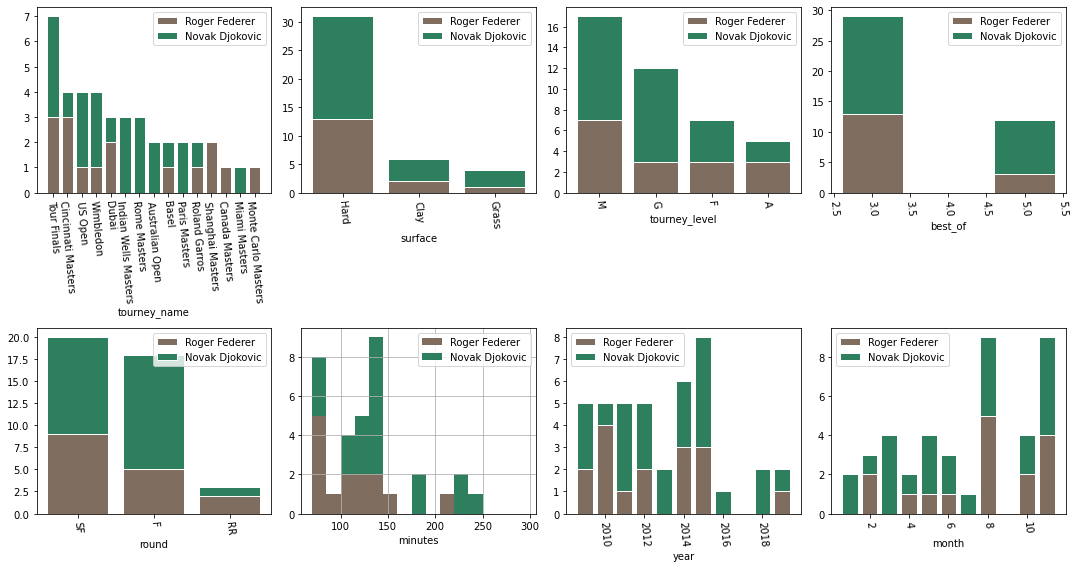

In [64]:

col_match = ['tourney_name','surface','tourney_level','best_of','round','minutes','year','month']

def comp_match(df_comp_n,col_match):
    
    plt.figure(figsize=(15,8))
    
    for i in range(len(col_match)):

        col=col_match[i]
        plt.subplot(2,4,i+1)

        #sns.bar(df_comp_n[col])

        if df_comp_n[col].dtypes in (np.float64,np.float32):

        # if the column is numeric features, plot the distribution
            plt.grid()


            n_bins = range(70,300,15)
            # use .histogram to return the counts at each bins and the bin edges
            bin_bottom, bin_edge = np.histogram(df_comp_n[df_comp_n.p1_win == 1][col], bins=n_bins)

            plt.hist(df_comp_n[df_comp_n.p1_win == 1][col], n_bins, density=False, histtype='bar', stacked=False,color='#7f6d5f')
            plt.hist(df_comp_n[df_comp_n.p2_win == 1][col], n_bins, density=False, histtype='bar', stacked=False,color='#2d7f5e',bottom=bin_bottom)
            #sns.distplot(df_comp_n[df_comp_n.p1_win == 1][col],kde=True,color='#7f6d5f',bins=n_bins)
            #sns.distplot(df_comp_n[df_comp_n.p2_win == 1][col],kde=True,color='#2d7f5e',bins=n_bins)
            plt.legend([player_1_name,player_2_name])
            plt.xlabel(col)


        elif (df_comp_n[col].dtypes in (np.int64,np.object)):

        # if the column is categorical features, plot the number of the top 10 category
            group = df_comp_n.groupby(col).agg({col:'count','p1_win':'sum','p2_win':'sum'})
            group.rename(columns = {col:'count'},inplace=True)
            group = group.reset_index()

            group = group.sort_values(by='count',ascending = False)
            group = group.reset_index()

            # Create brown bars
            plt.bar(group[col],group['p1_win'], color='#7f6d5f', edgecolor='white')
            plt.bar(group[col],group['p2_win'], bottom=group['p1_win'],color='#2d7f5e', edgecolor='white')

            plt.xticks(rotation = -85)
            plt.legend([player_1_name,player_2_name])
            plt.xlabel(col)

    plt.tight_layout()
    
    return

comp_match(df_comp_n,col_match)

Performance statistics over time

In [65]:
col_p1 = ['p1_win','p1_rank','p1_rank_points','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_SvGms','p1_bpFaced',
              'p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr']
col_p1_20 = ['p1_win_ratio_last_20','p1_rank_last_20','p1_rank_points_last_20','p1_ace_last_20','p1_df_last_20','p1_svpt_last_20', 
            'p1_1stIn_last_20','p1_1stWon_last_20','p1_2ndWon_last_20','p1_SvGms_last_20','p1_bpFaced_last_20',
          'p1_bpSaved_last_20','p1_bpc_last_20','p1_bpsr_last_20','p1_bpcr_last_20']
col_p1_10 = ['p1_win_ratio_last_10','p1_rank_last_10','p1_rank_points_last_10','p1_ace_last_10','p1_df_last_10','p1_svpt_last_10', 
            'p1_1stIn_last_10','p1_1stWon_last_10','p1_2ndWon_last_10','p1_SvGms_last_10','p1_bpFaced_last_10',
          'p1_bpSaved_last_10','p1_bpc_last_10','p1_bpsr_last_10','p1_bpcr_last_10']

col_p2 = ['p2_win','p2_rank','p2_rank_points','p2_ace','p2_df','p2_svpt', 'p2_1stIn','p2_1stWon','p2_2ndWon','p2_SvGms','p2_bpFaced',
          'p2_bpSaved','p2_bpc','p2_bpsr','p2_bpcr']
col_p2_20 = ['p2_win_ratio_last_20','p2_rank_last_20','p2_rank_points_last_20','p2_ace_last_20','p2_df_last_20','p2_svpt_last_20', 
            'p2_1stIn_last_20','p2_1stWon_last_20','p2_2ndWon_last_20','p2_SvGms_last_20','p2_bpFaced_last_20',
          'p2_bpSaved_last_20','p2_bpc_last_20','p2_bpsr_last_20','p2_bpcr_last_20']
col_p2_10 = ['p2_win_ratio_last_10','p2_rank_last_10','p2_rank_points_last_10','p2_ace_last_10','p2_df_last_10','p2_svpt_last_10', 
            'p2_1stIn_last_10','p2_1stWon_last_10','p2_2ndWon_last_10','p2_SvGms_last_10','p2_bpFaced_last_10',
          'p2_bpSaved_last_10','p2_bpc_last_10','p2_bpsr_last_10','p2_bpcr_last_10']

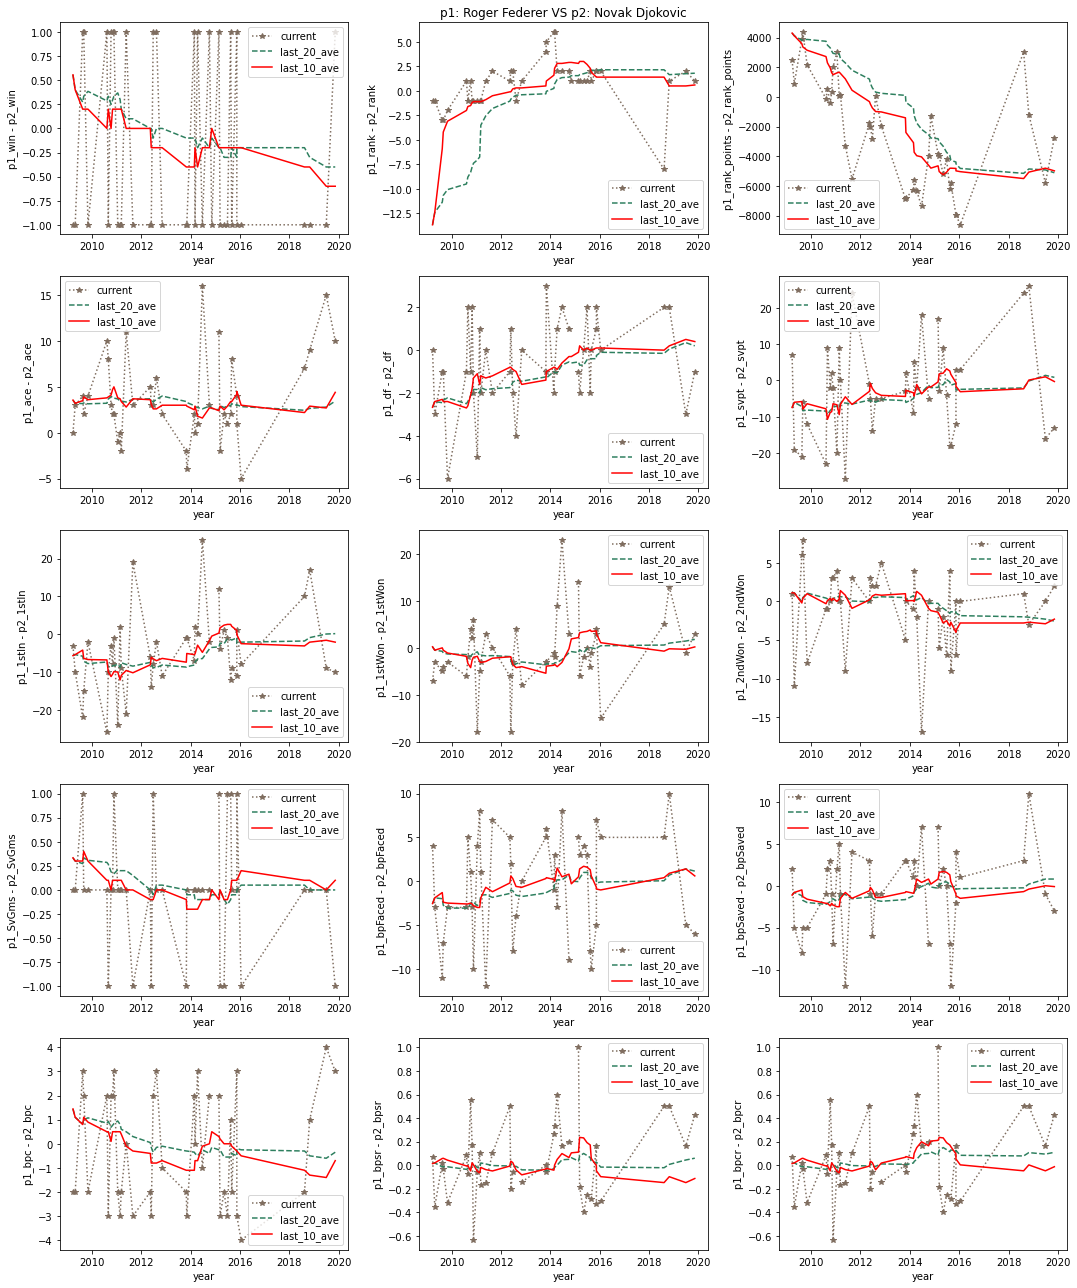

In [66]:


def comp_performance(df_comp_n,col_p1,col_p2,col_p1_20,col_p2_20,col_p1_10,col_p2_10):

    df_comp_n = df_comp_n.sort_values(by='tourney_date',ascending = True)
    
    plt.figure(figsize=(15,18))

    for i in range(len(col_p1)):

        plt.subplot(5,3,i+1)
        plt.plot(df_comp_n.tourney_date,df_comp_n[col_p1[i]]-df_comp_n[col_p2[i]],color ='#7f6d5f',linestyle=':', marker='*')
        #plt.plot(df_comp_n.tourney_date,df_comp_n[col_p2[i]],color ='#2d7f5e',linestyle=':')
        plt.plot(df_comp_n.tourney_date,df_comp_n[col_p1_20[i]]-df_comp_n[col_p2_20[i]],color ='#2d7f5e',linestyle='--')
        #plt.plot(df_comp_n.tourney_date,df_comp_n[col_p2_20[i]],color ='#2d7f5e',linestyle='-.')
        plt.plot(df_comp_n.tourney_date,df_comp_n[col_p1_10[i]]-df_comp_n[col_p2_10[i]],color ='red',linestyle='-')
        #plt.plot(df_comp_n.tourney_date,df_comp_n[col_p2_10[i]],color ='#2d7f5e',linestyle='--')

        plt.legend(['current','last_20_ave','last_10_ave'])
        plt.ylabel(col_p1[i]+' - '+col_p2[i])
        plt.xlabel('year')

        if i==1:
            plt.title('p1: '+player_1_name+' VS '+'p2: '+player_2_name)


    plt.tight_layout()
    
    return

comp_performance(df_comp_n,col_p1,col_p2,col_p1_20,col_p2_20,col_p1_10,col_p2_10)

We can also do the same for other players, like Federer vs Nadal

From 2009 to 2019, Roger Federer and Rafael Nadal have competed in 23 tournaments, in total played 23 matches, Roger Federer won 11 matches, Rafael Nadal won 12 matches.


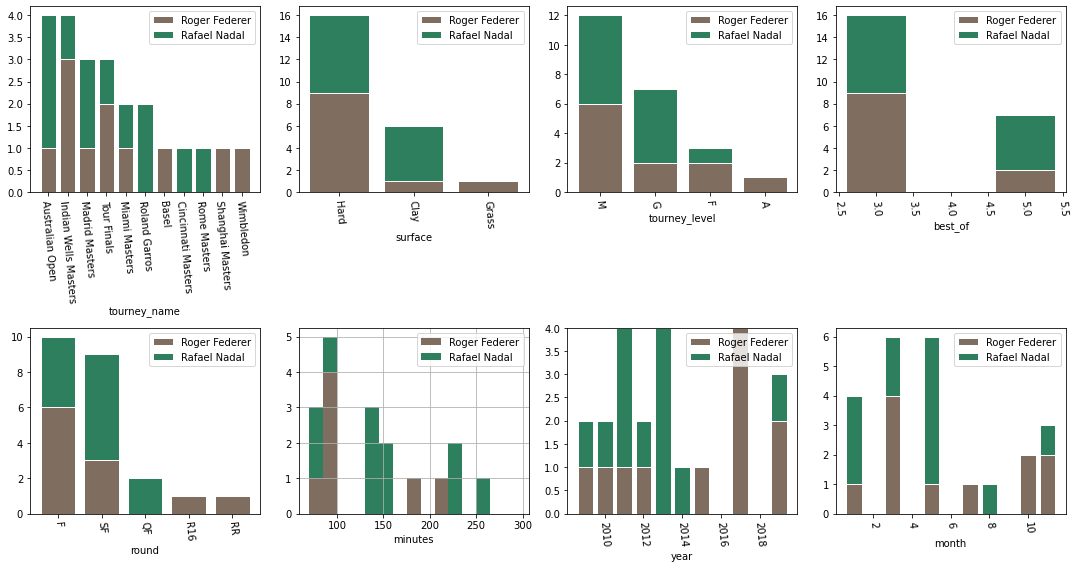

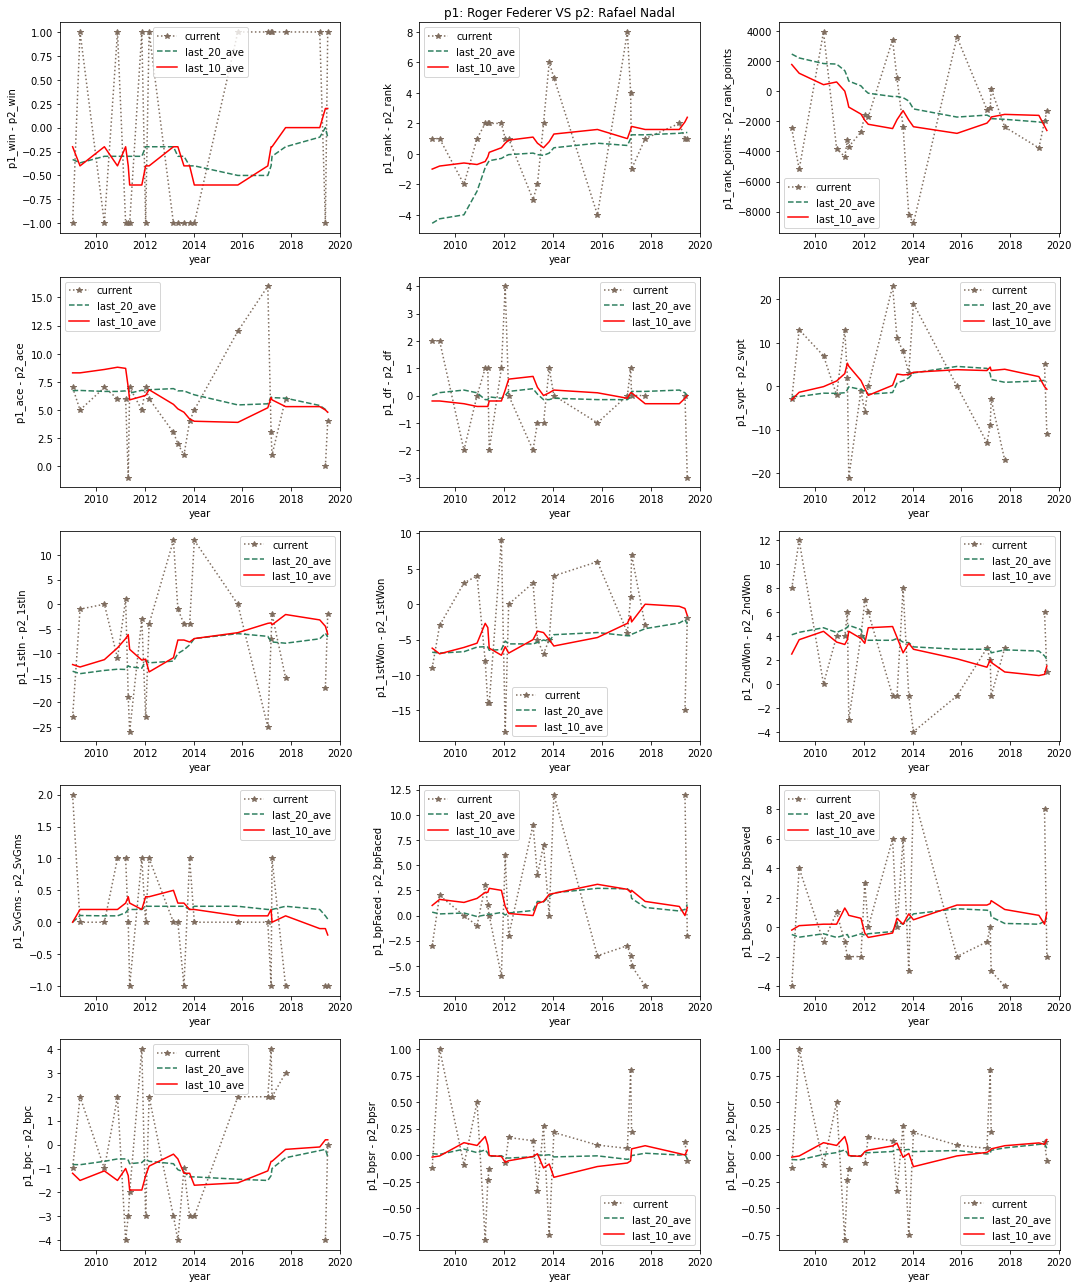

In [72]:
player_1_name = 'Roger Federer'
player_2_name = 'Rafael Nadal'
df_comp_2 = competitors(matrix,player_1_name,player_2_name,year_min,year_max)
comp_match(df_comp_2,col_match)
comp_performance(df_comp_2,col_p1,col_p2,col_p1_20,col_p2_20,col_p1_10,col_p2_10)


In [267]:
df_comp_2.head()

tourney_name surface tourney_level tourney_date  best_of round  \
18   Madrid Masters    Clay             M   2009-05-10      3.0     F   
19  Australian Open    Hard             G   2009-01-19      5.0     F   
20   Madrid Masters    Clay             M   2010-05-09      3.0     F   
21      Tour Finals    Hard             F   2010-11-21      3.0     F   
22    Miami Masters    Hard             M   2011-03-23      3.0    SF   

    minutes  year  month  day  day_week  p1_rank  p1_rank_points  p1_ace  \
18     86.0  2009      5   10         6      2.0         10170.0     6.0   
19    259.0  2009      1   19         0      2.0         10700.0    11.0   
20    131.0  2010      5    9         6      1.0         10430.0     9.0   
21     98.0  2010     11   21         6      2.0          7645.0     7.0   
22     79.0  2011      3   23         2      3.0          8280.0     6.0   

    p1_df  p1_svpt  p1_1stIn  p1_1stWon  p1_2ndWon  p1_SvGms  p1_bpFaced  \
18    3.0     67.0      42.0       29.0       17.0      10.0         4.0   
19    6.0    172.0      89.0       65.0       38.0      26.0        16.0   
20    0.0     88.0      59.0       35.0       14.0      11.0        11.0   
21    1.0     64.0      40.0       37.0       14.0      13.0         2.0   
22    1.0     58.0      35.0       20.0       11.0       9.0         5.0   

    p1_bpSaved  p1_bpc   p1_bpsr   p1_bpcr  p1_win_ratio_last_5  \
18         4.0     2.0  1.000000  1.000000                  0.2   
19         9.0     6.0  0.562500  0.315789                  0.2   
20         7.0     3.0  0.636364  0.272727                  0.2   
21         1.0     3.0  0.500000  1.000000                  0.2   
22         1.0     0.0  0.200000  0.000000                  0.4   

    p1_rank_last_5  p1_rank_points_last_5  p1_ace_last_5  p1_df_last_5  \
18             1.0                 6671.0           10.0           0.4   
19             1.2                 7399.0            9.0           1.0   
20             1.4                 8254.0           10.2           2.2   
21             1.4                 8975.0           10.6           2.2   
22             1.6                 9169.0           11.6           2.4   

    p1_svpt_last_5  p1_1stIn_last_5  p1_1stWon_last_5  p1_2ndWon_last_5  \
18           102.6             67.6              45.2              14.6   
19           106.4             68.2              44.6              17.0   
20           125.8             76.6              52.0              23.0   
21           119.8             74.0              49.4              22.6   
22           117.2             71.4              51.6              24.4   

    p1_SvGms_last_5  p1_bpFaced_last_5  p1_bpSaved_last_5  p1_bpc_last_5  \
18             15.6               11.0                6.2            2.6   
19             15.8               11.6                6.8            2.4   
20             18.6               13.4                8.4            2.8   
21             17.6               12.2                7.6            2.6   
22             18.0                9.2                6.0            3.0   

    p1_bpsr_last_5  p1_bpcr_last_5  p1_win_ratio_last_10  p1_rank_last_10  \
18        0.602327        0.489670                   0.4              1.0   
19        0.602327        0.539670                   0.4              1.1   
20        0.686256        0.442828                   0.4              1.2   
21        0.684117        0.383088                   0.3              1.2   
22        0.678234        0.533088                   0.4              1.3   

    p1_rank_points_last_10  p1_ace_last_10  p1_df_last_10  p1_svpt_last_10  \
18                  7008.5             9.9            1.4             98.6   
19                  7263.5             9.8            1.3             99.3   
20                  7604.5            10.6            1.5            109.9   
21                  7946.0            10.9            1.5            111.4   
22                  7959.0            10.7   

In [67]:
df_comp_n.columns[50:150]

Index(['p1_bpFaced_last_10', 'p1_bpSaved_last_10', 'p1_bpc_last_10',
       'p1_bpsr_last_10', 'p1_bpcr_last_10', 'p2_rank', 'p2_rank_points',
       'p2_ace', 'p2_df', 'p2_svpt', 'p2_1stIn', 'p2_1stWon', 'p2_2ndWon',
       'p2_SvGms', 'p2_bpFaced', 'p2_bpSaved', 'p2_bpc', 'p2_bpsr', 'p2_bpcr',
       'p2_win_ratio_last_20', 'p2_rank_last_20', 'p2_rank_points_last_20',
       'p2_ace_last_20', 'p2_df_last_20', 'p2_svpt_last_20',
       'p2_1stIn_last_20', 'p2_1stWon_last_20', 'p2_2ndWon_last_20',
       'p2_SvGms_last_20', 'p2_bpFaced_last_20', 'p2_bpSaved_last_20',
       'p2_bpc_last_20', 'p2_bpsr_last_20', 'p2_bpcr_last_20',
       'p2_win_ratio_last_10', 'p2_rank_last_10', 'p2_rank_points_last_10',
       'p2_ace_last_10', 'p2_df_last_10', 'p2_svpt_last_10',
       'p2_1stIn_last_10', 'p2_1stWon_last_10', 'p2_2ndWon_last_10',
       'p2_SvGms_last_10', 'p2_bpFaced_last_10', 'p2_bpSaved_last_10',
       'p2_bpc_last_10', 'p2_bpsr_last_10', 'p2_bpcr_last_10', 'p1_win',
       'p2_wi

In [68]:
col_self_corr = ['p1_win','p1_win_ratio_last_20', 'p1_rank_last_20',
       'p1_rank_points_last_20', 'p1_ace_last_20', 'p1_df_last_20',
       'p1_svpt_last_20', 'p1_1stIn_last_20', 'p1_1stWon_last_20',
       'p1_2ndWon_last_20', 'p1_SvGms_last_20', 'p1_bpFaced_last_20',
       'p1_bpSaved_last_20', 'p1_bpc_last_20', 'p1_bpsr_last_20',
       'p1_bpcr_last_20', 'p1_win_ratio_last_10', 'p1_rank_last_10',
       'p1_rank_points_last_10', 'p1_ace_last_10', 'p1_df_last_10',
       'p1_svpt_last_10', 'p1_1stIn_last_10', 'p1_1stWon_last_10',
       'p1_2ndWon_last_10', 'p1_SvGms_last_10', 'p1_bpFaced_last_10',
       'p1_bpSaved_last_10', 'p1_bpc_last_10', 'p1_bpsr_last_10',
       'p1_bpcr_last_10','p2_win','p2_win_ratio_last_20', 'p2_rank_last_20', 'p2_rank_points_last_20',
       'p2_ace_last_20', 'p2_df_last_20', 'p2_svpt_last_20', 'p2_1stIn_last_20',
       'p2_1stWon_last_20', 'p2_2ndWon_last_20', 'p2_SvGms_last_20',
       'p2_bpFaced_last_20', 'p2_bpSaved_last_20', 'p2_bpc_last_20',
       'p2_bpsr_last_20', 'p2_bpcr_last_20', 'p2_win_ratio_last_10',
       'p2_rank_last_10', 'p2_rank_points_last_10', 'p2_ace_last_10',
       'p2_df_last_10', 'p2_svpt_last_10', 'p2_1stIn_last_10',
       'p2_1stWon_last_10', 'p2_2ndWon_last_10', 'p2_SvGms_last_10',
       'p2_bpFaced_last_10', 'p2_bpSaved_last_10', 'p2_bpc_last_10',
       'p2_bpsr_last_10', 'p2_bpcr_last_10']

In [73]:
fed_djo_corr = df_comp_n[col_self_corr].corr(method='pearson') 
fed_nad_corr = df_comp_2[col_self_corr].corr(method='pearson') 

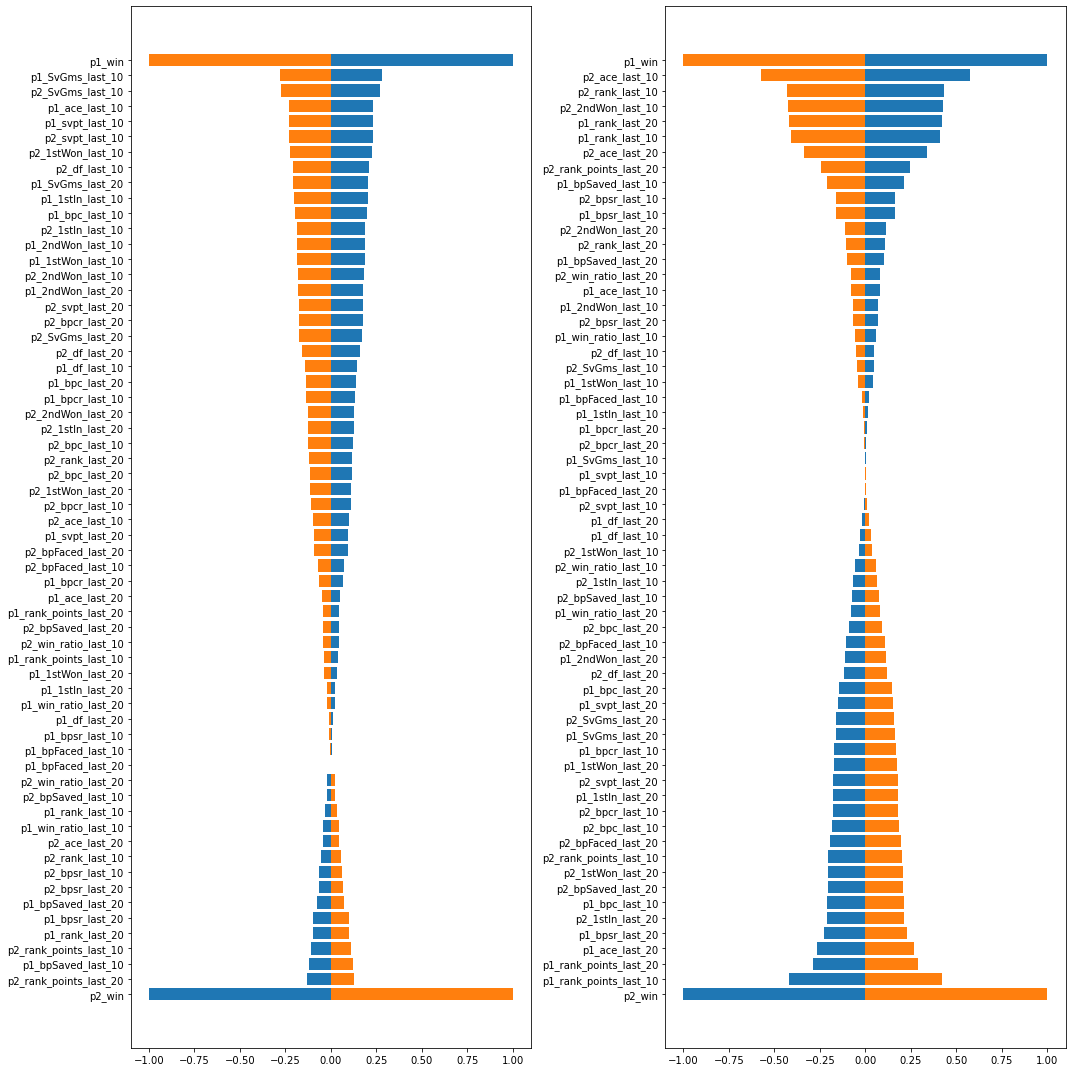

In [74]:
fed_corr = fed_djo_corr['p1_win'].sort_values()
djo_corr = fed_djo_corr['p2_win'].sort_values()

fed2_corr = fed_nad_corr['p1_win'].sort_values()
nad_corr = fed_nad_corr['p2_win'].sort_values()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.barh(fed_corr.index,fed_corr)
plt.barh(djo_corr.index,djo_corr)

plt.subplot(1,2,2)
plt.barh(fed2_corr.index,fed2_corr)
plt.barh(nad_corr.index,nad_corr)

plt.tight_layout()

 <a id='Feature'></a>
 ##  4. [Data preparation and feature engineering](#Contents)

In [75]:
#matrix = pd.read_pickle("./tennis_matrix.pkl")
#matrix = matrix.sort_values(by=['tourney_date','tourney_name','match_num'])
#matrix.reset_index(inplace = True)
#matrix.drop('index',axis=1,inplace=True)
matrix.to_pickle("./tennis_matrix2.pkl")
matrix.head(10)

tourney_name surface  draw_size tourney_level tourney_date  match_num  \
0       Hobart    Hard       32.0             A   1979-12-31        1.0   
1       Hobart    Hard       32.0             A   1979-12-31        2.0   
2       Hobart    Hard       32.0             A   1979-12-31        3.0   
3       Hobart    Hard       32.0             A   1979-12-31        4.0   
4       Hobart    Hard       32.0             A   1979-12-31        5.0   
5       Hobart    Hard       32.0             A   1979-12-31        6.0   
6       Hobart    Hard       32.0             A   1979-12-31        7.0   
7       Hobart    Hard       32.0             A   1979-12-31        8.0   
8       Hobart    Hard       32.0             A   1979-12-31        9.0   
9       Hobart    Hard       32.0             A   1979-12-31       10.0   

  winner_id winner_seed winner_entry        winner_name winner_hand  \
0    100315           1          NaN       Hank Pfister           R   
1    100397         NaN          NaN     Terry Rocavert           R   
2    107328         NaN          NaN       Jeremy Cohen           R   
3    100121           6          NaN      Raymond Moore           R   
4    100337           4          NaN     Mark Edmondson           R   
5    100515         NaN          NaN  Shlomo Glickstein           R   
6    100500         NaN          NaN        Rohun Beven           R   
7    100293           8          NaN         John Marks           R   
8    100488         NaN          NaN      Chris Delaney           R   
9    100592         NaN          NaN    Robert Vant Hof           R   

   winner_ht winner_ioc  winner_age loser_id loser_seed loser_entry  \
0      193.0        USA   26.225873   100713        NaN           Q   
1      180.0        AUS   24.194387   100473        NaN         NaN   
2        NaN        USA         NaN   100265        NaN         NaN   
3      183.0        RSA   33.352498   100550        NaN           Q   
4      185.0        AUS   25.519507   100726        NaN         NaN   
5      188.0        ISR   21.982204   100224        NaN         NaN   
6        NaN        GBR   22.275154   100749        NaN         NaN   
7        NaN        AUS   27.058179   100464        NaN         NaN   
8        NaN        USA   22.458590   100551          5         NaN   
9      193.0        USA   20.725530   100334        NaN         NaN   

        loser_name loser_hand  loser_ht loser_ioc  loser_age        score  \
0  John Fitzgerald          R     183.0       AUS  19.006160  5-7 6-3 6-4   
1   Glenn Petrovic          R       NaN       USA  22.828200      7-6 7-5   
2    Cliff Letcher          R       NaN       AUS  27.890486      6-2 6-3   
3        Brad Guan          R       NaN       AUS  21.475702  6-3 5-7 6-3   
4  Greg Whitecross          R     185.0       AUS  18.795346      6-3 6-3   
5   Peter Campbell          R       NaN       AUS  29.138946      6-2 6-2   
6     Dave Siegler          R       NaN       USA  18.584531  6-2 1-6 6-2   
7     Warren Maher          R       NaN       AUS  22.956879      6-2 6-4   
8     Brad Drewett          L     185.0       AUS  21.451061  7-6 3-6 6-4   
9      Ernie Ewert          R       NaN       AUS  25.571526  3-6 6-1 6-2   

   best_of round  minutes  w_ace  w_df  w_svpt  w_1stIn  w_1stWon  w_2ndWon  \
0        3   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
1        3   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
2        3   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
3        3   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
4        3   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
5        3   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
6        3   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
7        3   R32      NaN    NaN   NaN     NaN      NaN       NaN       NaN   
8        3   R32      NaN    NaN   NaN     NaN      N

In [76]:
matrix['lose_ratio_last_20'] = 1 - matrix['win_ratio_last_20']
matrix['lose_ratio_last_10'] = 1 - matrix['win_ratio_last_10']

In [104]:
# define a new matrix for trainning and re-arange the information for winner and loser as player 1 and player 2. For each pair, player_1_id < player_2_id.
col_match = ['tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date','year', 'month', 'day', 'day_week',
       'match_num', 'best_of', 'round', 'minutes']

# columns for winner and loser

col_w = ['winner_id', 'winner_seed', 'winner_entry', 'winner_name',
       'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age']


col_w_1 = ['winner_rank','winner_rank_points','w_ace','w_df','w_svpt', 'w_1stIn','w_1stWon','w_2ndWon','w_SvGms','w_bpFaced',
         'w_bpSaved','w_bpc','w_bpsr','w_bpcr', 'winner_set_1', 'winner_set_2', 'winner_set_3', 'winner_set_4', 'winner_set_5']

col_w_20 = ['win_ratio_last_20','winner_rank_last_20', 'winner_rank_points_last_20','w_ace_last_20', 'w_df_last_20','w_svpt_last_20',
           'w_1stIn_last_20', 'w_1stWon_last_20','w_2ndWon_last_20','w_SvGms_last_20', 'w_bpFaced_last_20', 'w_bpSaved_last_20',
            'w_bpc_last_20','w_bpsr_last_20', 'w_bpcr_last_20', 'winner_set_1_last_20', 'winner_set_2_last_20', 'winner_set_3_last_20',
           'winner_set_4_last_20', 'winner_set_5_last_20']

col_w_10 = ['win_ratio_last_10','winner_rank_last_10', 'winner_rank_points_last_10','w_ace_last_10', 'w_df_last_10','w_svpt_last_10',
            'w_1stIn_last_10','w_1stWon_last_10','w_2ndWon_last_10','w_SvGms_last_10', 'w_bpFaced_last_10','w_bpSaved_last_10', 
            'w_bpc_last_10','w_bpsr_last_10', 'w_bpcr_last_10','winner_set_1_last_10', 'winner_set_2_last_10', 'winner_set_3_last_10', 'winner_set_4_last_10',
       'winner_set_5_last_10']

### 
col_l = ['loser_id', 'loser_seed', 'loser_entry', 'loser_name','loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',]

col_l_1 = ['loser_rank', 'loser_rank_points','l_ace','l_df','l_svpt', 'l_1stIn','l_1stWon','l_2ndWon','l_SvGms','l_bpFaced',
         'l_bpSaved','l_bpc','l_bpsr','l_bpcr','loser_set_1','loser_set_2', 'loser_set_3','loser_set_4','loser_set_5'] 

col_l_20 = ['lose_ratio_last_20','loser_rank_last_20', 'loser_rank_points_last_20','l_ace_last_20','l_df_last_20','l_svpt_last_20', 
           'l_1stIn_last_20','l_1stWon_last_20','l_2ndWon_last_20','l_SvGms_last_20','l_bpFaced_last_20','l_bpSaved_last_20',
           'l_bpc_last_20','l_bpsr_last_20','l_bpcr_last_20','loser_set_1_last_20','loser_set_2_last_20', 'loser_set_3_last_20', 
           'loser_set_4_last_20', 'loser_set_5_last_20']   

col_l_10 = ['lose_ratio_last_10','loser_rank_last_10', 'loser_rank_points_last_10','l_ace_last_10','l_df_last_10','l_svpt_last_10', 
            'l_1stIn_last_10','l_1stWon_last_10','l_2ndWon_last_10','l_SvGms_last_10','l_bpFaced_last_10','l_bpSaved_last_10',
             'l_bpc_last_10','l_bpsr_last_10','l_bpcr_last_10','loser_set_1_last_10', 'loser_set_2_last_10', 'loser_set_3_last_10',
       'loser_set_4_last_10', 'loser_set_5_last_10']           

# new columns for player 1 and player 2
col_p1 = ['p1_id', 'p1_seed', 'p1_entry', 'p1_name','p1_hand', 'p1_ht', 'p1_ioc', 'p1_age']
col_p1_1 = ['p1_rank','p1_rank_points','p1_ace','p1_df','p1_svpt', 'p1_1stIn','p1_1stWon','p1_2ndWon','p1_SvGms','p1_bpFaced',
          'p1_bpSaved','p1_bpc','p1_bpsr','p1_bpcr','p1_set_1', 'p1_set_2', 'p1_set_3', 'p1_set_4', 'p1_set_5']
col_p1_20 = ['p1_win_ratio_last_20','p1_rank_last_20','p1_rank_points_last_20','p1_ace_last_20','p1_df_last_20','p1_svpt_last_20', 
            'p1_1stIn_last_20','p1_1stWon_last_20','p1_2ndWon_last_20','p1_SvGms_last_20','p1_bpFaced_last_20',
          'p1_bpSaved_last_20','p1_bpc_last_20','p1_bpsr_last_20','p1_bpcr_last_20','p1_set_1_last_20', 'p1_set_2_last_20', 'p1_set_3_last_20', 'p1_set_4_last_20', 'p1_set_5_last_20']
col_p1_10 = ['p1_win_ratio_last_10','p1_rank_last_10','p1_rank_points_last_10','p1_ace_last_10','p1_df_last_10','p1_svpt_last_10', 
            'p1_1stIn_last_10','p1_1stWon_last_10','p1_2ndWon_last_10','p1_SvGms_last_10','p1_bpFaced_last_10',
          'p1_bpSaved_last_10','p1_bpc_last_10','p1_bpsr_last_10','p1_bpcr_last_10','p1_set_1_last_10', 'p1_set_2_last_10', 'p1_set_3_last_10', 'p1_set_4_last_10', 'p1_set_5_last_10']

col_p2 = ['p2_id', 'p2_seed', 'p2_entry', 'p2_name','p2_hand', 'p2_ht', 'p2_ioc', 'p2_age']
col_p2_1 = ['p2_rank','p2_rank_points','p2_ace','p2_df','p2_svpt', 'p2_1stIn','p2_1stWon','p2_2ndWon','p2_SvGms','p2_bpFaced',
          'p2_bpSaved','p2_bpc','p2_bpsr','p2_bpcr','p2_set_1', 'p2_set_2', 'p2_set_3', 'p2_set_4', 'p2_set_5']
col_p2_20 = ['p2_win_ratio_last_20','p2_rank_last_20','p2_rank_points_last_20','p2_ace_last_20','p2_df_last_20','p2_svpt_last_20', 
            'p2_1stIn_last_20','p2_1stWon_last_20','p2_2ndWon_last_20','p2_SvGms_last_20','p2_bpFaced_last_20',
          'p2_bpSaved_last_20','p2_bpc_last_20','p2_bpsr_last_20','p2_bpcr_last_20','p2_set_1_last_20', 'p2_set_2_last_20', 'p2_set_3_last_20', 'p2_set_4_last_20', 'p2_set_5_last_20']

col_p2_10 = ['p2_win_ratio_last_10','p2_rank_last_10','p2_rank_points_last_10','p2_ace_last_10','p2_df_last_10','p2_svpt_last_10', 
            'p2_1stIn_last_10','p2_1stWon_last_10','p2_2ndWon_last_10','p2_SvGms_last_10','p2_bpFaced_last_10',
          'p2_bpSaved_last_10','p2_bpc_last_10','p2_bpsr_last_10','p2_bpcr_last_10','p2_set_1_last_10', 'p2_set_2_last_10', 'p2_set_3_last_10', 'p2_set_4_last_10', 'p2_set_5_last_10']


In [79]:
print(len(col_w),len(col_w_1),len(col_w_20),len(col_w_10))
print(len(col_l),len(col_l_1),len(col_l_20),len(col_l_10))
print(len(col_p1),len(col_p1_1),len(col_p1_20),len(col_p1_10))
print(len(col_p2),len(col_p2_1),len(col_p2_20),len(col_p2_10))

8 19 20 20
8 19 20 20
8 19 20 20
8 19 20 20


In [39]:
#matrix[['winner_id','loser_id']] = matrix[['winner_id','loser_id']].astype(np.float64)
matrix[matrix.winner_name == 'Roger Federer']

tourney_name surface  draw_size tourney_level  \
1                         Adelaide    Hard       32.0             A   
206                Australian Open    Hard      128.0             G   
244                Australian Open    Hard      128.0             G   
365    Davis Cup WG R1: SUI vs AUS  Carpet        4.0             D   
409                      Marseille    Hard       32.0             A   
...                            ...     ...        ...           ...   
61888              Australian Open    Hard      128.0             G   
61928              Australian Open    Hard      128.0             G   
61948              Australian Open    Hard      128.0             G   
61958              Australian Open    Hard      128.0             G   
61963              Australian Open    Hard      128.0             G   

      tourney_date  match_num  winner_id winner_seed winner_entry  \
1       2000-01-03        2.0   103819.0         NaN          NaN   
206     2000-01-17       52.0   103819.0         NaN          NaN   
244     2000-01-17       90.0   103819.0         NaN          NaN   
365     2000-02-04        2.0   103819.0         NaN          NaN   
409     2000-02-07        3.0   103819.0         NaN           WC   
...            ...        ...        ...         ...          ...   
61888   2020-01-20      147.0   103819.0           3          NaN   
61928   2020-01-20      187.0   103819.0           3          NaN   
61948   2020-01-20      207.0   103819.0           3          NaN   
61958   2020-01-20      217.0   103819.0           3          NaN   
61963   2020-01-20      222.0   103819.0           3          NaN   

         winner_name winner_hand  winner_ht winner_ioc  winner_age  loser_id  \
1      Roger Federer           R      185.0        SUI   18.384668  102533.0   
206    Roger Federer           R      185.0        SUI   18.442163  102021.0   
244    Roger Federer           R      185.0        SUI   18.442163  102466.0   
365    Roger Federer           R      185.0        SUI   18.480493  102882.0   
409    Roger Federer           R      185.0        SUI   18.499658  102179.0   
...              ...         ...        ...        ...         ...       ...   
61888  Roger Federer           R      185.0        SUI   38.450376  105449.0   
61928  Roger Federer           R      185.0        SUI   38.450376  105936.0   
61948  Roger Federer           R      185.0        SUI   38.450376  105357.0   
61958  Roger Federer           R      185.0        SUI   38.450376  105916.0   
61963  Roger Federer           R      185.0        SUI   38.450376  105815.0   

      loser_seed loser_entry          loser_name loser_hand  loser_ht  \
1            NaN         NaN    Jens Knippschild          R     190.0   
206          NaN         NaN       Michael Chang          R     175.0   
244          NaN         NaN         Jan Kroslak          R     188.0   
365          NaN         NaN  Mark Philippoussis          R     196.0   
409          NaN           Q       Antony Dupuis          R     185.0   
...          ...         ...                 ...        ...       ...   
61888        NaN         NaN       Steve Johnson          R     188.0   
61928        NaN         NaN    Filip Krajinovic          R     185.0   
61948        NaN         NaN        John Millman          R     183.0   
61958        NaN         NaN    Marton Fucsovics          R       NaN   
61963        NaN         NaN     Tennys Sandgren          R       NaN   

      loser_ioc  loser_age                      score  best_of round  minutes  \
1           GER  24.862423                    6-1 6-4        3   R32     45.0   
206         USA  27.901437             6-4 6-4 7-6(5)        5  R128    125.0   
244         SVK  25.251198             7-6(1) 6-2 6-3        5   R64    106.0   
365         AUS  23.230664         6-4 7-6(3) 4-6 6-4        5    RR      NaN   
409         FRA  26.951403                    6-4 6-4        3   R32     72.0   
...         ... 

In [183]:
#del matrix_n


In [105]:
matrix_n = matrix[col_match]
matrix_n.tail()

tourney_name surface  draw_size tourney_level  \
135820  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
135821  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
135822  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
135823  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
135824  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   

       tourney_date  year  month  day  day_week  match_num  best_of round  \
135820   2020-03-06  2020      3    6         4        2.0        3    RR   
135821   2020-03-06  2020      3    6         4        4.0        3    RR   
135822   2020-03-06  2020      3    6         4        1.0        3    RR   
135823   2020-03-06  2020      3    6         4        2.0        3    RR   
135824   2020-03-06  2020      3    6         4        4.0        3    RR   

        minutes  
135820      NaN  
135821      NaN  
135822      NaN  
135823      NaN  
135824      NaN

In [107]:
matrix[['winner_id','loser_id']]=matrix[['winner_id','loser_id']].astype(np.float64)

In [103]:
matrix.loser_id.isnull().sum()

0

In [108]:
matrix_n[col_p1] = matrix.loc[matrix.winner_id<matrix.loser_id,col_w] 
matrix_n[col_p2] = matrix.loc[matrix.winner_id>matrix.loser_id,col_w] 

matrix_n['p1_win'] = matrix_n['p1_id'].map(lambda x: 1 if x>0 else 0, na_action = 'ignore').fillna(0)
matrix_n['p2_win'] = matrix_n['p2_id'].map(lambda x: 1 if x>0 else 0, na_action = 'ignore').fillna(0)

for i in range(len(col_p1)):
    matrix_n[col_p1[i]].fillna(matrix[matrix.winner_id>matrix.loser_id][col_l[i]],inplace = True)
    matrix_n[col_p2[i]].fillna(matrix[matrix.winner_id<matrix.loser_id][col_l[i]],inplace = True)

    
matrix_n[col_p1_1] = matrix.loc[matrix.winner_id<matrix.loser_id,col_w_1] 
matrix_n[col_p2_1] = matrix.loc[matrix.winner_id>matrix.loser_id,col_w_1]

    
for i in range(len(col_p1_1)):
    matrix_n[col_p1_1[i]].fillna(matrix[matrix.winner_id>matrix.loser_id][col_l_1[i]],inplace = True)
    matrix_n[col_p2_1[i]].fillna(matrix[matrix.winner_id<matrix.loser_id][col_l_1[i]],inplace = True)

matrix_n[col_p1_20] = matrix.loc[matrix.winner_id<matrix.loser_id,col_w_20] 
matrix_n[col_p2_20] = matrix.loc[matrix.winner_id>matrix.loser_id,col_w_20]
matrix_n[col_p1_10] = matrix.loc[matrix.winner_id<matrix.loser_id,col_w_10] 
matrix_n[col_p2_10] = matrix.loc[matrix.winner_id>matrix.loser_id,col_w_10]

    
for i in range(len(col_p1_20)):
    matrix_n[col_p1_20[i]].fillna(matrix[matrix.winner_id>matrix.loser_id][col_l_20[i]],inplace = True)
    matrix_n[col_p2_20[i]].fillna(matrix[matrix.winner_id<matrix.loser_id][col_l_20[i]],inplace = True)
    matrix_n[col_p1_10[i]].fillna(matrix[matrix.winner_id>matrix.loser_id][col_l_10[i]],inplace = True)
    matrix_n[col_p2_10[i]].fillna(matrix[matrix.winner_id<matrix.loser_id][col_l_10[i]],inplace = True)
    
# matrix_n[col_p1_20] = matrix.loc[matrix.winner_id<matrix.loser_id,col_w_20] 
# matrix_n[col_p2_20] = matrix.loc[matrix.winner_id>matrix.loser_id,col_w_20]
# matrix_n[col_p1_10] = matrix.loc[matrix.winner_id<matrix.loser_id,col_w_10] 
# matrix_n[col_p2_10] = matrix.loc[matrix.winner_id>matrix.loser_id,col_w_10]
    
# df_comp_n[col_p1]=df_comp[df_comp['winner_name'] == player_1_name][col_w]
# df_comp_n[col_p1_20]=df_comp[df_comp['winner_name'] == player_1_name][col_w_20]
# df_comp_n[col_p1_10]=df_comp[df_comp['winner_name'] == player_1_name][col_w_10]

# df_comp_n[col_p2]=df_comp[df_comp['winner_name'] == player_2_name][col_w]
# df_comp_n[col_p2_20]=df_comp[df_comp['winner_name'] == player_2_name][col_w_20]
# df_comp_n[col_p2_10]=df_comp[df_comp['winner_name'] == player_2_name][col_w_10]

# #df_comp_n.head()

# df_comp_n['p1_win'] = df_comp_n['p1_rank_points'].map(lambda x: 1 if x>0 else 0, na_action = 'ignore').fillna(0)
# df_comp_n['p2_win'] = df_comp_n['p2_rank_points'].map(lambda x: 1 if x>0 else 0, na_action = 'ignore').fillna(0)
# df_comp_n.head()

# for i in range(len(col_p1)):
#     df_comp_n[col_p1[i]].fillna(df_comp[df_comp['loser_name'] == player_1_name][col_l[i]],inplace = True)
#     df_comp_n[col_p2[i]].fillna(df_comp[df_comp['loser_name'] == player_2_name][col_l[i]],inplace = True)

# for i in range(len(col_l_20)):
#     df_comp_n[col_p1_20[i+1]].fillna(df_comp[df_comp['loser_name'] == player_1_name][col_l_20[i]],inplace = True)
#     df_comp_n[col_p1_10[i+1]].fillna(df_comp[df_comp['loser_name'] == player_1_name][col_l_10[i]],inplace = True)
#     df_comp_n[col_p2_20[i+1]].fillna(df_comp[df_comp['loser_name'] == player_2_name][col_l_20[i]],inplace = True)
#     df_comp_n[col_p2_10[i+1]].fillna(df_comp[df_comp['loser_name'] == player_2_name][col_l_10[i]],inplace = True)

# df_comp_n['p1_win_ratio_last_20'].fillna(1-df_comp_n['p2_win_ratio_last_20'],inplace = True)
# df_comp_n['p2_win_ratio_last_20'].fillna(1-df_comp_n['p1_win_ratio_last_20'],inplace = True)
# df_comp_n['p1_win_ratio_last_10'].fillna(1-df_comp_n['p2_win_ratio_last_10'],inplace = True)
# df_comp_n['p2_win_ratio_last_10'].fillna(1-df_comp_n['p1_win_ratio_last_10'],inplace = True)
    
matrix_n.head()

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying t

tourney_name surface  draw_size tourney_level tourney_date  year  month  \
0       Hobart    Hard       32.0             A   1979-12-31  1979     12   
1       Hobart    Hard       32.0             A   1979-12-31  1979     12   
2       Hobart    Hard       32.0             A   1979-12-31  1979     12   
3       Hobart    Hard       32.0             A   1979-12-31  1979     12   
4       Hobart    Hard       32.0             A   1979-12-31  1979     12   

   day  day_week  match_num  best_of round  minutes     p1_id p1_seed  \
0   31         0        1.0        3   R32      NaN  100315.0       1   
1   31         0        2.0        3   R32      NaN  100397.0     NaN   
2   31         0        3.0        3   R32      NaN  100265.0     NaN   
3   31         0        4.0        3   R32      NaN  100121.0       6   
4   31         0        5.0        3   R32      NaN  100337.0       4   

  p1_entry         p1_name p1_hand  p1_ht p1_ioc     p1_age     p2_id p2_seed  \
0      NaN    Hank Pfister       R  193.0    USA  26.225873  100713.0     NaN   
1      NaN  Terry Rocavert       R  180.0    AUS  24.194387  100473.0     NaN   
2      NaN   Cliff Letcher       R    NaN    AUS  27.890486  107328.0     NaN   
3      NaN   Raymond Moore       R  183.0    RSA  33.352498  100550.0     NaN   
4      NaN  Mark Edmondson       R  185.0    AUS  25.519507  100726.0     NaN   

  p2_entry          p2_name p2_hand  p2_ht p2_ioc     p2_age  p1_win  p2_win  \
0        Q  John Fitzgerald       R  183.0    AUS  19.006160     1.0     0.0   
1      NaN   Glenn Petrovic       R    NaN    USA  22.828200     1.0     0.0   
2      NaN     Jeremy Cohen       R    NaN    USA        NaN     0.0     1.0   
3        Q        Brad Guan       R    NaN    AUS  21.475702     1.0     0.0   
4      NaN  Greg Whitecross       R  185.0    AUS  18.795346     1.0     0.0   

   p1_rank  p1_rank_points  p1_ace  p1_df  p1_svpt  p1_1stIn  p1_1stWon  \
0      NaN             NaN     NaN    NaN      NaN       NaN        NaN   
1      NaN             NaN     NaN    NaN      NaN       NaN        NaN   
2      NaN             NaN     NaN    NaN      NaN       NaN        NaN   
3      NaN             NaN     NaN    NaN      NaN       NaN        NaN   
4      NaN             NaN     NaN    NaN      NaN       NaN        NaN   

   p1_2ndWon  p1_SvGms  p1_bpFaced  p1_bpSaved  p1_bpc  p1_bpsr  p1_bpcr  \
0        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
1        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
2        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
3        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
4        NaN       NaN         NaN         NaN     NaN      NaN      NaN   

   p1_set_1  p1_set_2  p1_set_3  p1_set_4  p1_set_5  ...  p2_bpFaced_last_20  \
0       5.0       6.0       6.0       NaN       NaN  ...                 NaN   
1       7.0       7.0       NaN       NaN       NaN  ...                 NaN   
2       2.0       3.0       NaN       NaN       NaN  ...                 NaN   
3       6.0       5.0       6.0       NaN       NaN  ...                 NaN   
4       6.0       6.0       NaN       NaN       NaN  ...                 NaN   

   p2_bpSaved_last_20  p2_bpc_last_20  p2_bpsr_last_20  p2_bpcr_last_20  \
0                 NaN             NaN              NaN              NaN   
1                 NaN             NaN              NaN              NaN   
2                 NaN             NaN              NaN              NaN   
3                 NaN             NaN              NaN              NaN   
4                 NaN             NaN              NaN              NaN   

   p2_set_1_last_20  p2_set_2_last_20  p2_set_3_last_20  p2_set_4_last_20  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN      

In [109]:
matrix_n['pair_names']=matrix_n['p1_name']+'/'+matrix_n['p2_name']
matrix_n.to_pickle("./tennis_matrix2_n.pkl")


C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
players = ['Roger Federer','Novak Djokovic']
matrix_n[(matrix_n['pair_names']==players[0]+'/'+players[1]) |(matrix_n['pair_names']==players[1]+'/'+players[0])]


tourney_name surface  draw_size tourney_level  \
94190           Monte Carlo Masters    Clay       64.0             M   
95854   Davis Cup WG PO: SUI vs SCG    Hard        4.0             D   
96613               Australian Open    Hard      128.0             G   
97074                         Dubai    Hard       32.0             A   
98729                Canada Masters    Hard       56.0             M   
98958                       US Open    Hard      128.0             G   
99809               Australian Open    Hard      128.0             G   
100735          Monte Carlo Masters    Clay       56.0             M   
102119                      US Open    Hard      128.0             G   
103623                Miami Masters    Hard       96.0             M   
103850                 Rome Masters    Clay       56.0             M   
104979           Cincinnati Masters    Hard       56.0             M   
105151                      US Open    Hard      128.0             G   
105640                        Basel    Hard       32.0             A   
107974               Canada Masters    Hard       56.0             M   
108203                      US Open    Hard      128.0             G   
108499             Shanghai Masters    Hard       56.0             M   
108701                        Basel    Hard       32.0             A   
108752                  Tour Finals    Hard        8.0             F   
109040              Australian Open    Hard      128.0             G   
109401                        Dubai    Hard       32.0             A   
109626         Indian Wells Masters    Hard       96.0             M   
110260                Roland Garros    Clay      128.0             G   
111242                      US Open    Hard      128.0             G   
113213                 Rome Masters    Clay       56.0             M   
113394                Roland Garros    Clay      128.0             G   
113661                    Wimbledon   Grass      128.0             G   
114111           Cincinnati Masters    Hard       56.0             M   
114788                  Tour Finals    Hard        8.0             F   
117716                Paris Masters    Hard       48.0             M   
117722                  Tour Finals    Hard        8.0             F   
118443                        Dubai    Hard       32.0             A   
118567         Indian Wells Masters    Hard       96.0             M   
118869          Monte Carlo Masters    Clay       56.0             M   
119560                    Wimbledon   Grass      128.0             G   
120427             Shanghai Masters    Hard       56.0             M   
120634                  Tour Finals    Hard        8.0             F   
121247                        Dubai    Hard       32.0             A   
121473         Indian Wells Masters    Hard       96.0             M   
121942                 Rome Masters    Clay       56.0             M   
122413                    Wimbledon   Grass      128.0             G   
122900           Cincinnati Masters    Hard       56.0             M   
123074                      US Open    Hard      128.0             G   
123568                  Tour Finals    Hard        8.0             F   
123577                  Tour Finals    Hard        8.0             F   
123844              Australian Open    Hard      128.0             G   
131624           Cincinnati Masters    Hard       64.0             M   
132260                Paris Masters    Hard       64.0             M   
133981                    Wimbledon   Grass      128.0             G   
135018                  Tour Finals    Hard        8.0             F   
135370              Australian Open    Hard      128.0             G   

       tourney_date  year  month  day  day_week  match_num  best_of round  \
94190    2006-04-17  2006      4   17         0        1.0        3   R64   
95854    2006-09-22  2006      9   22         4        4.0        5    RR   
96613    2007-01-15  2007      1   15         0

Another important factor that have shown a good accuracy in predicting winner is the Elo rating: https://www.betfair.com.au/hub/tennis-elo-modelling/

The Elo rating is a system that calculates not only the number of matches a player won, but also what level of opponents a player has won. 

Each player starts with an Elo rating of 1500, the player's winning propability is given by

$p_{win} = [1+10^{(Elo_{opp}-Elo_{player})/400}]^{-1}$

The Elo of the player will be updated after the jth match

$Elo_{j+1} = Elo_{j} + K (outcome - p_{win})$

where outcome = 1 for winning and 0 for losing.

The K factor can be a constant 32, but more accurate model suggest to use a decay function  

$K=\frac{c}{(M+o)^s}$

where c is a constant, M is the number of matches in the player’s dataset, o is a small offset (to avoid very large values when M is low), and s is a shape parameter which allows for more flexibility in the curve’s shape.

In fivethirtyeight.com, they use the following parameters:
$c=250, o=0.5, s = 0.4$


In [111]:
matrix_n.dtypes

tourney_name                      object
surface                           object
draw_size                        float64
tourney_level                     object
tourney_date              datetime64[ns]
year                               int64
month                              int64
day                                int64
day_week                           int64
match_num                        float64
best_of                            int64
round                             object
minutes                          float64
p1_id                            float64
p1_seed                           object
p1_entry                          object
p1_name                           object
p1_hand                           object
p1_ht                            float64
p1_ioc                            object
p1_age                           float64
p2_id                            float64
p2_seed                           object
p2_entry                          object
p2_name         

In [112]:
# only extract the information we need, the loop will be faster
matrix_n['p1_id']=matrix_n['p1_id'].astype(np.int64)
matrix_n['p2_id']=matrix_n['p2_id'].astype(np.int64)
matrix_result = matrix_n[['tourney_name','tourney_date','surface','p1_id','p2_id','p1_win','p2_win']]


C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [113]:
# We start the Elo calculation from 1980
elo_list = pd.Series()
# use set to get the unique player_id
elo_id = set(list(matrix_n.p1_id.unique())+list(matrix_n.p2_id.unique()))
elo_list = pd.Series(data = np.ones(len(elo_id))*1500, index=elo_id)
elo_list_hard = pd.Series(data = np.ones(len(elo_id))*1500, index=elo_id)
elo_list_clay = pd.Series(data = np.ones(len(elo_id))*1500, index=elo_id)
elo_list_grass = pd.Series(data = np.ones(len(elo_id))*1500, index=elo_id)
elo_list_carpet = pd.Series(data = np.ones(len(elo_id))*1500, index=elo_id)


for row in matrix_result.itertuples():
    
    index = row.Index
    
   
    surface = row.surface

    p1_id = row.p1_id
    p2_id = row.p2_id

    p1_win = row.p1_win
    p2_win = row.p2_win


    # calculate the total Elo                

    # number of matches played by player 1 and player 2 so far
    M1 = matrix_result[(matrix_result.index<index) & ((matrix_result.p1_id ==p1_id) | (matrix_result.p2_id ==p1_id))].shape[0]
    M2 = matrix_result[(matrix_result.index<index) & ((matrix_result.p1_id ==p2_id) | (matrix_result.p2_id ==p2_id))].shape[0]

    K1=250/((M1+5)**0.4)
    K2=250/((M2+5)**0.4)

    Elo_1 = elo_list[p1_id]
    Elo_2 = elo_list[p2_id] 

    p1_win_pred = 1/(1+10**((Elo_2-Elo_1)/400))
    p2_win_pred = 1/(1+10**((Elo_1-Elo_2)/400))

    matrix_result.loc[index,'Elo_1']=elo_list[p1_id]
    matrix_result.loc[index,'Elo_2']=elo_list[p2_id]

    matrix_result.loc[index,'p1_win_pred']=p1_win_pred
    matrix_result.loc[index,'p2_win_pred']=p2_win_pred

    Elo_1_new = Elo_1+K1*(p1_win-p1_win_pred)
    Elo_2_new = Elo_2+K2*(p2_win-p2_win_pred)

    if Elo_1_new>=0:
        elo_list[p1_id]=Elo_1_new  
    if Elo_2_new>=0:
        elo_list[p2_id]=Elo_2_new          



    # we also calculate the Elo for a particular surface     

    # number of matches played by player 1 and player 2 so far on this surface type
    M1_sf = matrix_result[(matrix_result.index<index) & ((matrix_result.p1_id ==p1_id) | (matrix_result.p2_id ==p1_id)) & (matrix_result.surface==surface)].shape[0]
    M2_sf = matrix_result[(matrix_result.index<index) & ((matrix_result.p1_id ==p2_id) | (matrix_result.p2_id ==p2_id)) & (matrix_result.surface==surface)].shape[0]

    K1_sf=250/((M1_sf+5)**0.4)
    K2_sf=250/((M2_sf+5)**0.4)

    if surface == 'Hard':
        Elo_1_sf = elo_list_hard[p1_id]
        Elo_2_sf = elo_list_hard[p2_id]

        p1_win_pred_sf = 1/(1+10**((Elo_2_sf-Elo_1_sf)/400))
        p2_win_pred_sf = 1/(1+10**((Elo_1_sf-Elo_2_sf)/400))

        matrix_result.loc[index,'Elo_1_hard']=elo_list_hard[p1_id]
        matrix_result.loc[index,'Elo_2_hard']=elo_list_hard[p2_id]

        matrix_result.loc[index,'p1_win_pred_hard']=p1_win_pred_sf
        matrix_result.loc[index,'p2_win_pred_hard']=p2_win_pred_sf

        Elo_1_sf_new = Elo_1_sf+K1_sf*(p1_win-p1_win_pred_sf)
        Elo_2_sf_new = Elo_2_sf+K2_sf*(p2_win-p2_win_pred_sf)

        if Elo_1_sf_new>0:
            elo_list_hard[p1_id]=Elo_1_sf_new                
        if Elo_2_sf_new>0:
            elo_list_hard[p2_id]=Elo_2_sf_new



    elif surface == 'Clay':
        Elo_1_sf = elo_list_clay[p1_id]
        Elo_2_sf = elo_list_clay[p2_id]

        p1_win_pred_sf = 1/(1+10**((Elo_2_sf-Elo_1_sf)/400))
        p2_win_pred_sf = 1/(1+10**((Elo_1_sf-Elo_2_sf)/400))

        matrix_result.loc[index,'Elo_1_clay']=elo_list_clay[p1_id]
        matrix_result.loc[index,'Elo_2_clay']=elo_list_clay[p2_id]

        matrix_result.loc[index,'p1_win_pred_clay']=p1_win_pred_sf
        matrix_result.loc[index,'p2_win_pred_clay']=p2_win_pred_sf

        Elo_1_sf_new = Elo_1_sf+K1_sf*(p1_win-p1_win_pred_sf)
        Elo_2_sf_new = Elo_2_sf+K2_sf*(p2_win-p2_win_pred_sf)

        if Elo_1_sf_new>0:
            elo_list_clay[p1_id]=Elo_1_sf_new                
        if Elo_2_sf_new>0:
            elo_list_clay[p2_id]=Elo_2_sf_new


    elif surface == 'Grass':
        Elo_1_sf = elo_list_grass[p1_id]
        Elo_2_sf = elo_list_grass[p2_id]

        p1_win_pred_sf = 1/(1+10**((Elo_2_sf-Elo_1_sf)/400))
        p2_win_pred_sf = 1/(1+10**((Elo_1_sf-Elo_2_sf)/400))

        matrix_result.loc[index,'Elo_1_grass']=elo_list_grass[p1_id]
        matrix_result.loc[index,'Elo_2_grass']=elo_list_grass[p2_id]

        matrix_result.loc[index,'p1_win_pred_grass']=p1_win_pred_sf
        matrix_result.loc[index,'p2_win_pred_grass']=p2_win_pred_sf

        Elo_1_sf_new = Elo_1_sf+K1_sf*(p1_win-p1_win_pred_sf)
        Elo_2_sf_new = Elo_2_sf+K2_sf*(p2_win-p2_win_pred_sf)

        if Elo_1_sf_new>0:
            elo_list_grass[p1_id]=Elo_1_sf_new                
        if Elo_2_sf_new>0:
            elo_list_grass[p2_id]=Elo_2_sf_new


    elif surface == 'Carpet':
        Elo_1_sf = elo_list_carpet[p1_id]
        Elo_2_sf = elo_list_carpet[p2_id]

        p1_win_pred_sf = 1/(1+10**((Elo_2_sf-Elo_1_sf)/400))
        p2_win_pred_sf = 1/(1+10**((Elo_1_sf-Elo_2_sf)/400))

        matrix_result.loc[index,'Elo_1_carpet']=elo_list_carpet[p1_id]
        matrix_result.loc[index,'Elo_2_carpet']=elo_list_carpet[p2_id]

        matrix_result.loc[index,'p1_win_pred_carpet']=p1_win_pred_sf
        matrix_result.loc[index,'p2_win_pred_carpet']=p2_win_pred_sf

        Elo_1_sf_new = Elo_1_sf+K1_sf*(p1_win-p1_win_pred_sf)
        Elo_2_sf_new = Elo_2_sf+K2_sf*(p2_win-p2_win_pred_sf)

        if Elo_1_sf_new>0:
            elo_list_carpet[p1_id]=Elo_1_sf_new                
        if Elo_2_sf_new>0:
            elo_list_carpet[p2_id]=Elo_2_sf_new

        
    if index%1000 == 0:
        print(index)
    
    

    
    

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000


In [234]:
matrix_n.tail()

tourney_name surface  draw_size tourney_level  \
62416  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
62417  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
62418  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
62419  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
62420  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   

      tourney_date  year  month  day  day_week  match_num  best_of round  \
62416   2020-03-06  2020      3    6         4        2.0        3    RR   
62417   2020-03-06  2020      3    6         4        4.0        3    RR   
62418   2020-03-06  2020      3    6         4        1.0        3    RR   
62419   2020-03-06  2020      3    6         4        2.0        3    RR   
62420   2020-03-06  2020      3    6         4        4.0        3    RR   

       minutes   p1_id p1_seed p1_entry                     p1_name p1_hand  \
62416      NaN  105668     NaN      NaN              Jerzy Janowicz       R   
62417      NaN  207852     NaN      NaN                  Wai Yu Kai       U   
62418      NaN  200250     NaN      NaN  Mehluli Don Ayanda Sibanda       R   
62419      NaN  111761     NaN      NaN               Benjamin Lock       R   
62420      NaN  111761     NaN      NaN               Benjamin Lock       R   

       p1_ht p1_ioc     p1_age   p2_id p2_seed p2_entry           p2_name  \
62416  203.0    POL  29.300479  106388     NaN      NaN    Pak Long Yeung   
62417    NaN    HKG  18.951403  209874     NaN      NaN  Maks Kasnikowski   
62418    NaN    ZIM  20.320329  208518     NaN      NaN         Hazem Naw   
62419    NaN    ZIM  26.995209  200181     NaN      NaN         Amer Naow   
62420    NaN    ZIM  26.995209  208518     NaN      NaN         Hazem Naw   

      p2_hand  p2_ht p2_ioc     p2_age  p1_win  p2_win  p1_rank  \
62416       U    NaN    HKG  25.045859     1.0     0.0    461.0   
62417     NaN    NaN    POL  16.657084     0.0     1.0      NaN   
62418       R    NaN    UNK  20.167009     0.0     1.0    813.0   
62419       R    NaN    SYR  25.166324     1.0     0.0    430.0   
62420       R    NaN    UNK  20.167009     1.0     0.0    430.0   

       p1_rank_points  p1_ace  p1_df  p1_svpt  p1_1stIn  p1_1stWon  p1_2ndWon  \
62416            68.0     NaN    NaN      NaN       NaN        NaN        NaN   
62417             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
62418            18.0     NaN    NaN      NaN       NaN        NaN        NaN   
62419            79.0     NaN    NaN      NaN       NaN        NaN        NaN   
62420            79.0     NaN    NaN      NaN       NaN        NaN        NaN   

       p1_SvGms  p1_bpFaced  p1_bpSaved  p1_bpc  p1_bpsr  p1_bpcr  p1_set_1  \
62416       NaN         NaN         NaN     NaN      NaN      NaN       6.0   
62417       NaN         NaN         NaN     NaN      NaN      NaN       6.0   
62418       NaN         NaN         NaN     NaN      NaN      NaN       3.0   
62419       NaN         NaN         NaN     NaN      NaN      NaN       6.0   
62420       NaN         NaN         NaN     NaN      NaN      NaN       6.0   

       p1_set_2  p1_set_3  p1_set_4  p1_set_5  ...  p2_bpSaved_last_5  \
62416       7.0       6.0       NaN       NaN  ...                NaN   
62417       2.0       3.0       NaN       NaN  ...                NaN   
62418       3.0       NaN       NaN       NaN  ...                NaN   
62419       6.0       NaN       NaN       NaN  ...                NaN   
62420       6.0       NaN       NaN       NaN  ...                NaN   

       p2_bpc_last_5  p2_bpsr_last_5  p2_bpcr_last_5  p2_set_1_last_5  \
62416            NaN             NaN             NaN              NaN   
62417            NaN             NaN             NaN              NaN   
62418            NaN             NaN             NaN              NaN   
62419            NaN             NaN             NaN              NaN   
62420            NaN      

In [114]:
matrix_result['Elo_1_sf']=matrix_result['Elo_1_hard'].fillna(0)+matrix_result['Elo_1_clay'].fillna(0)\
                            +matrix_result['Elo_1_grass'].fillna(0)+matrix_result['Elo_1_carpet'].fillna(0)
matrix_result['Elo_2_sf']=matrix_result['Elo_2_hard'].fillna(0)+matrix_result['Elo_2_clay'].fillna(0)\
                            +matrix_result['Elo_2_grass'].fillna(0)+matrix_result['Elo_2_carpet'].fillna(0)
matrix_result['p1_win_pred_sf']=matrix_result['p1_win_pred_hard'].fillna(0)+matrix_result['p1_win_pred_clay'].fillna(0)\
                            +matrix_result['p1_win_pred_grass'].fillna(0)+matrix_result['p1_win_pred_carpet'].fillna(0)
matrix_result['p2_win_pred_sf']=matrix_result['p2_win_pred_hard'].fillna(0)+matrix_result['p2_win_pred_clay'].fillna(0)\
                            +matrix_result['p2_win_pred_grass'].fillna(0)+matrix_result['p2_win_pred_carpet'].fillna(0)

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [236]:
matrix_result

tourney_name tourney_date surface   p1_id   p2_id  \
0                          Adelaide   2000-01-03    Hard  102358  103096   
1                          Adelaide   2000-01-03    Hard  102533  103819   
2                          Adelaide   2000-01-03    Hard  101885  102998   
3                          Adelaide   2000-01-03    Hard  102776  103206   
4                          Adelaide   2000-01-03    Hard  102401  102796   
...                             ...          ...     ...     ...     ...   
62416  Davis Cup WG2 PO: POL vs HKG   2020-03-06    Hard  105668  106388   
62417  Davis Cup WG2 PO: POL vs HKG   2020-03-06    Hard  207852  209874   
62418  Davis Cup WG2 PO: SYR vs ZIM   2020-03-06    Hard  200250  208518   
62419  Davis Cup WG2 PO: SYR vs ZIM   2020-03-06    Hard  111761  200181   
62420  Davis Cup WG2 PO: SYR vs ZIM   2020-03-06    Hard  111761  208518   

       p1_win  p2_win        Elo_1        Elo_2  p1_win_pred  p2_win_pred  \
0         1.0     0.0  1500.000000  1500.000000     0.500000     0.500000   
1         0.0     1.0  1500.000000  1500.000000     0.500000     0.500000   
2         0.0     1.0  1500.000000  1500.000000     0.500000     0.500000   
3         0.0     1.0  1500.000000  1500.000000     0.500000     0.500000   
4         0.0     1.0  1500.000000  1500.000000     0.500000     0.500000   
...       ...     ...          ...          ...          ...          ...   
62416     1.0     0.0  1761.439324  1434.336805     0.867950     0.132050   
62417     0.0     1.0  1435.950478  1500.000000     0.408856     0.591144   
62418     0.0     1.0  1384.693573  1500.000000     0.339896     0.660104   
62419     1.0     0.0  1661.449990  1500.000000     0.716950     0.283050   
62420     1.0     0.0  1686.814492  1544.637331     0.693905     0.306095   

        Elo_1_hard   Elo_2_hard  p1_win_pred_hard  p2_win_pred_hard  \
0      1500.000000  1500.000000          0.500000          0.500000   
1      1500.000000  1500.000000          0.500000          0.500000   
2      1500.000000  1500.000000          0.500000          0.500000   
3      1500.000000  1500.000000          0.500000          0.500000   
4      1500.000000  1500.000000          0.500000          0.500000   
...            ...          ...               ...               ...   
62416  1712.163889  1434.336805          0.831921          0.168079   
62417  1434.932598  1500.000000          0.407440          0.592560   
62418  1384.693573  1500.000000          0.339896          0.660104   
62419  1652.832696  1500.000000          0.706776          0.293224   
62420  1679.108896  1544.637331          0.684403          0.315597   

       Elo_1_clay  Elo_2_clay  p1_win_pred_clay  p2_win_pred_clay  \
0             NaN         NaN               NaN               NaN   
1             NaN         NaN               NaN               NaN   
2             NaN         NaN               NaN               NaN   
3             NaN         NaN               NaN               NaN   
4             NaN         NaN               NaN               NaN   
...           ...         ...               ...               ...   
62416         NaN         NaN               NaN               NaN   
62417         NaN         NaN               NaN               NaN   
62418         NaN         NaN               NaN               NaN   
62419         NaN         NaN               NaN               NaN   
62420         NaN         NaN               NaN               NaN   

       Elo_1_grass  Elo_2_grass  p1_win_pred_grass  p2_win_pred_grass  \
0              NaN          NaN                NaN                NaN   
1              NaN          NaN                NaN                NaN   
2              NaN          NaN                NaN                NaN   
3              NaN          NaN                NaN                NaN   
4              NaN          NaN                NaN                NaN   
...            ...          ...                ...               

In [115]:
matrix_result.to_pickle("./tennis_Elo_matrix2.pkl")

In [201]:
matrix_result=pd.read_pickle("./tennis_Elo_matrix2.pkl")

In [116]:
matrix_result[['p1_id','p2_id']]=matrix_result[['p1_id','p2_id']].astype(np.int64)

C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


[Text(0.5, 0, 'p1_win'),
 Text(1.5, 0, 'p1_win_pred'),
 Text(2.5, 0, 'p1_win_pred_sf'),
 Text(3.5, 0, 'p2_win'),
 Text(4.5, 0, 'p2_win_pred'),
 Text(5.5, 0, 'p2_win_pred_sf')]

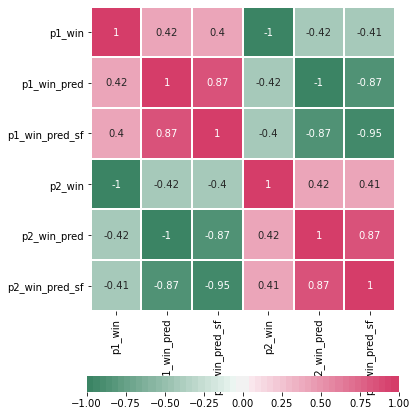

In [117]:
elo_corr = matrix_result[matrix_result.tourney_date>'2010-01-01'][['p1_win','p1_win_pred','p1_win_pred_sf','p2_win','p2_win_pred','p2_win_pred_sf']].corr(method='pearson') 

plt.figure(figsize=(8,8))
ax=sns.heatmap(elo_corr,
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(150,0, n=50),
            square=True,
            cbar_kws={'orientation':'horizontal','shrink':0.7},     
            linewidths = 1,
            linecolor = 'white',
            annot=True,  
           # mask=mask_ut,
        )

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center')

In [118]:
from sklearn.metrics import accuracy_score

date_begin='1990-01-01'

y_true = matrix_result[matrix_result.tourney_date> date_begin].p1_win
y_pred_elo = matrix_result[matrix_result.tourney_date>date_begin].p1_win_pred > matrix_result[matrix_result.tourney_date>date_begin].p2_win_pred
acc_elo = accuracy_score(y_true, y_pred_elo)
print('The accuracy of winner prediction based on Elo is: {}%'.format(round(acc_elo*100,3)))

y_pred_elosf = matrix_result[matrix_result.tourney_date>date_begin].p1_win_pred_sf > matrix_result[matrix_result.tourney_date>date_begin].p2_win_pred_sf
acc_elosf = accuracy_score(y_true, y_pred_elosf)
print('The accuracy of winner prediction based on Elo of surface type is: {}%'.format(round(acc_elosf*100,3)))

The accuracy of winner prediction based on Elo is: 66.219%
The accuracy of winner prediction based on Elo of surface type is: 65.802%


In [121]:
y_pred_20 = matrix_n[matrix_n.tourney_date> date_begin].p1_win_ratio_last_20 > matrix_n[matrix_n.tourney_date>date_begin].p2_win_ratio_last_20
acc_20 = accuracy_score(y_true, y_pred_20)
print('The accuracy of winner prediction based on past 20 competion is: {}%'.format(round(acc_20*100,3)))
 
y_pred_10 = matrix_n[matrix_n.tourney_date>date_begin].p1_win_ratio_last_10 > matrix_n[matrix_n.tourney_date>date_begin].p2_win_ratio_last_10
acc_10 = accuracy_score(y_true, y_pred_10)
print('The accuracy of winner prediction based on past 10 competion is: {}%'.format(round(acc_10*100,3)))

The accuracy of winner prediction based on past 20 competion is: 53.054%
The accuracy of winner prediction based on past 10 competion is: 53.073%


In [122]:
y_pred_rank = matrix_n[matrix_n.tourney_date> date_begin].p1_rank < matrix_n[matrix_n.tourney_date>date_begin].p2_rank
acc_rank = accuracy_score(y_true, y_pred_rank)
print('The accuracy of winner prediction based on player rank is: {}%'.format(round(acc_rank*100,3))) 

y_pred_rankpoint = matrix_n[matrix_n.tourney_date> date_begin].p1_rank_points > matrix_n[matrix_n.tourney_date>date_begin].p2_rank_points
acc_rankpoint = accuracy_score(y_true, y_pred_rankpoint)
print('The accuracy of winner prediction based on player rank is: {}%'.format(round(acc_rankpoint*100,3))) 


The accuracy of winner prediction based on player rank is: 64.36%
The accuracy of winner prediction based on player rank is: 64.22%


In [169]:
# matrix_n.drop(['Elo_1_x', 'Elo_2_x', 'p1_win_pred_x',
#        'p2_win_pred_x', 'Elo_1_hard_x', 'Elo_2_hard_x', 'p1_win_pred_hard_x',
#        'p2_win_pred_hard_x', 'Elo_1_clay_x', 'Elo_2_clay_x',
#        'p1_win_pred_clay_x', 'p2_win_pred_clay_x', 'Elo_1_grass_x',
#        'Elo_2_grass_x', 'p1_win_pred_grass_x', 'p2_win_pred_grass_x',
#        'Elo_1_carpet_x', 'Elo_2_carpet_x', 'p1_win_pred_carpet_x',
#        'p2_win_pred_carpet_x', 'Elo_1_sf_x', 'Elo_2_sf_x', 'p1_win_pred_sf_x',
#        'p2_win_pred_sf_x', 'Elo_1_y', 'Elo_2_y', 'p1_win_pred_y',
#        'p2_win_pred_y', 'Elo_1_hard_y', 'Elo_2_hard_y', 'p1_win_pred_hard_y',
#        'p2_win_pred_hard_y', 'Elo_1_clay_y', 'Elo_2_clay_y',
#        'p1_win_pred_clay_y', 'p2_win_pred_clay_y', 'Elo_1_grass_y',
#        'Elo_2_grass_y', 'p1_win_pred_grass_y', 'p2_win_pred_grass_y',
#        'Elo_1_carpet_y', 'Elo_2_carpet_y', 'p1_win_pred_carpet_y',
#        'p2_win_pred_carpet_y', 'Elo_1_sf_y', 'Elo_2_sf_y', 'p1_win_pred_sf_y',
#        'p2_win_pred_sf_y'],axis = 1,inplace=True)

In [132]:
matrix_n.dtypes

tourney_name                      object
surface                           object
draw_size                        float64
tourney_level                     object
tourney_date              datetime64[ns]
year                               int64
month                              int64
day                                int64
day_week                           int64
match_num                        float64
best_of                            int64
round                             object
minutes                          float64
p1_id                              int64
p1_seed                           object
p1_entry                          object
p1_name                           object
p1_hand                           object
p1_ht                            float64
p1_ioc                            object
p1_age                           float64
p2_id                              int64
p2_seed                           object
p2_entry                          object
p2_name         

In [131]:
matrix_result.dtypes

tourney_name                  object
tourney_date          datetime64[ns]
surface                       object
p1_id                          int64
p2_id                          int64
p1_win                       float64
p2_win                       float64
Elo_1                        float64
Elo_2                        float64
p1_win_pred                  float64
p2_win_pred                  float64
Elo_1_hard                   float64
Elo_2_hard                   float64
p1_win_pred_hard             float64
p2_win_pred_hard             float64
Elo_1_grass                  float64
Elo_2_grass                  float64
p1_win_pred_grass            float64
p2_win_pred_grass            float64
Elo_1_carpet                 float64
Elo_2_carpet                 float64
p1_win_pred_carpet           float64
p2_win_pred_carpet           float64
Elo_1_clay                   float64
Elo_2_clay                   float64
p1_win_pred_clay             float64
p2_win_pred_clay             float64
E

In [123]:
matrix_n0=matrix_n.copy()


In [124]:
print(len(matrix),len(matrix_n),len(matrix_result))

135825 135825 135825


In [140]:
matrix_n=matrix_n0.copy()
matrix_n.head()

tourney_name surface  draw_size tourney_level tourney_date  year  month  \
0       Hobart    Hard       32.0             A   1979-12-31  1979     12   
1       Hobart    Hard       32.0             A   1979-12-31  1979     12   
2       Hobart    Hard       32.0             A   1979-12-31  1979     12   
3       Hobart    Hard       32.0             A   1979-12-31  1979     12   
4       Hobart    Hard       32.0             A   1979-12-31  1979     12   

   day  day_week  match_num  best_of round  minutes   p1_id p1_seed p1_entry  \
0   31         0        1.0        3   R32      NaN  100315       1      NaN   
1   31         0        2.0        3   R32      NaN  100397     NaN      NaN   
2   31         0        3.0        3   R32      NaN  100265     NaN      NaN   
3   31         0        4.0        3   R32      NaN  100121       6      NaN   
4   31         0        5.0        3   R32      NaN  100337       4      NaN   

          p1_name p1_hand  p1_ht p1_ioc     p1_age   p2_id p2_seed p2_entry  \
0    Hank Pfister       R  193.0    USA  26.225873  100713     NaN        Q   
1  Terry Rocavert       R  180.0    AUS  24.194387  100473     NaN      NaN   
2   Cliff Letcher       R    NaN    AUS  27.890486  107328     NaN      NaN   
3   Raymond Moore       R  183.0    RSA  33.352498  100550     NaN        Q   
4  Mark Edmondson       R  185.0    AUS  25.519507  100726     NaN      NaN   

           p2_name p2_hand  p2_ht p2_ioc     p2_age  p1_win  p2_win  p1_rank  \
0  John Fitzgerald       R  183.0    AUS  19.006160     1.0     0.0      NaN   
1   Glenn Petrovic       R    NaN    USA  22.828200     1.0     0.0      NaN   
2     Jeremy Cohen       R    NaN    USA        NaN     0.0     1.0      NaN   
3        Brad Guan       R    NaN    AUS  21.475702     1.0     0.0      NaN   
4  Greg Whitecross       R  185.0    AUS  18.795346     1.0     0.0      NaN   

   p1_rank_points  p1_ace  p1_df  p1_svpt  p1_1stIn  p1_1stWon  p1_2ndWon  \
0             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
1             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
2             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
3             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
4             NaN     NaN    NaN      NaN       NaN        NaN        NaN   

   p1_SvGms  p1_bpFaced  p1_bpSaved  p1_bpc  p1_bpsr  p1_bpcr  p1_set_1  \
0       NaN         NaN         NaN     NaN      NaN      NaN       5.0   
1       NaN         NaN         NaN     NaN      NaN      NaN       7.0   
2       NaN         NaN         NaN     NaN      NaN      NaN       2.0   
3       NaN         NaN         NaN     NaN      NaN      NaN       6.0   
4       NaN         NaN         NaN     NaN      NaN      NaN       6.0   

   p1_set_2  p1_set_3  p1_set_4  p1_set_5  ...  p2_bpSaved_last_20  \
0       6.0       6.0       NaN       NaN  ...                 NaN   
1       7.0       NaN       NaN       NaN  ...                 NaN   
2       3.0       NaN       NaN       NaN  ...                 NaN   
3       5.0       6.0       NaN       NaN  ...                 NaN   
4       6.0       NaN       NaN       NaN  ...                 NaN   

   p2_bpc_last_20  p2_bpsr_last_20  p2_bpcr_last_20  p2_set_1_last_20  \
0             NaN              NaN              NaN               NaN   
1             NaN              NaN              NaN               NaN   
2             NaN              NaN              NaN               NaN   
3             NaN              NaN              NaN               NaN   
4             NaN              NaN              NaN               NaN   

   p2_set_2_last_20  p2_set_3_last_20  p2_set_4_last_20  p2_set_5_last_20  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN 

In [141]:
matrix_n0.head()

tourney_name surface  draw_size tourney_level tourney_date  year  month  \
0       Hobart    Hard       32.0             A   1979-12-31  1979     12   
1       Hobart    Hard       32.0             A   1979-12-31  1979     12   
2       Hobart    Hard       32.0             A   1979-12-31  1979     12   
3       Hobart    Hard       32.0             A   1979-12-31  1979     12   
4       Hobart    Hard       32.0             A   1979-12-31  1979     12   

   day  day_week  match_num  best_of round  minutes   p1_id p1_seed p1_entry  \
0   31         0        1.0        3   R32      NaN  100315       1      NaN   
1   31         0        2.0        3   R32      NaN  100397     NaN      NaN   
2   31         0        3.0        3   R32      NaN  100265     NaN      NaN   
3   31         0        4.0        3   R32      NaN  100121       6      NaN   
4   31         0        5.0        3   R32      NaN  100337       4      NaN   

          p1_name p1_hand  p1_ht p1_ioc     p1_age   p2_id p2_seed p2_entry  \
0    Hank Pfister       R  193.0    USA  26.225873  100713     NaN        Q   
1  Terry Rocavert       R  180.0    AUS  24.194387  100473     NaN      NaN   
2   Cliff Letcher       R    NaN    AUS  27.890486  107328     NaN      NaN   
3   Raymond Moore       R  183.0    RSA  33.352498  100550     NaN        Q   
4  Mark Edmondson       R  185.0    AUS  25.519507  100726     NaN      NaN   

           p2_name p2_hand  p2_ht p2_ioc     p2_age  p1_win  p2_win  p1_rank  \
0  John Fitzgerald       R  183.0    AUS  19.006160     1.0     0.0      NaN   
1   Glenn Petrovic       R    NaN    USA  22.828200     1.0     0.0      NaN   
2     Jeremy Cohen       R    NaN    USA        NaN     0.0     1.0      NaN   
3        Brad Guan       R    NaN    AUS  21.475702     1.0     0.0      NaN   
4  Greg Whitecross       R  185.0    AUS  18.795346     1.0     0.0      NaN   

   p1_rank_points  p1_ace  p1_df  p1_svpt  p1_1stIn  p1_1stWon  p1_2ndWon  \
0             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
1             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
2             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
3             NaN     NaN    NaN      NaN       NaN        NaN        NaN   
4             NaN     NaN    NaN      NaN       NaN        NaN        NaN   

   p1_SvGms  p1_bpFaced  p1_bpSaved  p1_bpc  p1_bpsr  p1_bpcr  p1_set_1  \
0       NaN         NaN         NaN     NaN      NaN      NaN       5.0   
1       NaN         NaN         NaN     NaN      NaN      NaN       7.0   
2       NaN         NaN         NaN     NaN      NaN      NaN       2.0   
3       NaN         NaN         NaN     NaN      NaN      NaN       6.0   
4       NaN         NaN         NaN     NaN      NaN      NaN       6.0   

   p1_set_2  p1_set_3  p1_set_4  p1_set_5  ...  p2_bpSaved_last_20  \
0       6.0       6.0       NaN       NaN  ...                 NaN   
1       7.0       NaN       NaN       NaN  ...                 NaN   
2       3.0       NaN       NaN       NaN  ...                 NaN   
3       5.0       6.0       NaN       NaN  ...                 NaN   
4       6.0       NaN       NaN       NaN  ...                 NaN   

   p2_bpc_last_20  p2_bpsr_last_20  p2_bpcr_last_20  p2_set_1_last_20  \
0             NaN              NaN              NaN               NaN   
1             NaN              NaN              NaN               NaN   
2             NaN              NaN              NaN               NaN   
3             NaN              NaN              NaN               NaN   
4             NaN              NaN              NaN               NaN   

   p2_set_2_last_20  p2_set_3_last_20  p2_set_4_last_20  p2_set_5_last_20  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN 

In [142]:
# merge the matrix_result with matrix_n
#matrix_result[['p1_id','p2_id']]=matrix_result[['p1_id','p2_id']].astype(str)
col_result = ['Elo_1', 'Elo_2', 'p1_win_pred', 'p2_win_pred', 'Elo_1_hard',
       'Elo_2_hard', 'p1_win_pred_hard', 'p2_win_pred_hard', 'Elo_1_clay',
       'Elo_2_clay', 'p1_win_pred_clay', 'p2_win_pred_clay', 'Elo_1_grass',
       'Elo_2_grass', 'p1_win_pred_grass', 'p2_win_pred_grass', 'Elo_1_carpet',
       'Elo_2_carpet', 'p1_win_pred_carpet', 'p2_win_pred_carpet', 'Elo_1_sf',
       'Elo_2_sf', 'p1_win_pred_sf', 'p2_win_pred_sf']

matrix_n = pd.merge(matrix_n,matrix_result[col_result], on=matrix_n.index,how='left')
matrix_n.tail()

key_0                  tourney_name surface  draw_size tourney_level  \
135820  135820  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
135821  135821  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
135822  135822  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
135823  135823  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
135824  135824  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   

       tourney_date  year  month  day  day_week  match_num  best_of round  \
135820   2020-03-06  2020      3    6         4        2.0        3    RR   
135821   2020-03-06  2020      3    6         4        4.0        3    RR   
135822   2020-03-06  2020      3    6         4        1.0        3    RR   
135823   2020-03-06  2020      3    6         4        2.0        3    RR   
135824   2020-03-06  2020      3    6         4        4.0        3    RR   

        minutes   p1_id p1_seed p1_entry                     p1_name p1_hand  \
135820      NaN  105668     NaN      NaN              Jerzy Janowicz       R   
135821      NaN  207852     NaN      NaN                  Wai Yu Kai       U   
135822      NaN  200250     NaN      NaN  Mehluli Don Ayanda Sibanda       R   
135823      NaN  111761     NaN      NaN               Benjamin Lock       R   
135824      NaN  111761     NaN      NaN               Benjamin Lock       R   

        p1_ht p1_ioc     p1_age   p2_id p2_seed p2_entry           p2_name  \
135820  203.0    POL  29.300479  106388     NaN      NaN    Pak Long Yeung   
135821    NaN    HKG  18.951403  209874     NaN      NaN  Maks Kasnikowski   
135822    NaN    ZIM  20.320329  208518     NaN      NaN         Hazem Naw   
135823    NaN    ZIM  26.995209  200181     NaN      NaN         Amer Naow   
135824    NaN    ZIM  26.995209  208518     NaN      NaN         Hazem Naw   

       p2_hand  p2_ht p2_ioc     p2_age  p1_win  p2_win  p1_rank  \
135820       U    NaN    HKG  25.045859     1.0     0.0    461.0   
135821     NaN    NaN    POL  16.657084     0.0     1.0      NaN   
135822       R    NaN    UNK  20.167009     0.0     1.0    813.0   
135823       R    NaN    SYR  25.166324     1.0     0.0    430.0   
135824       R    NaN    UNK  20.167009     1.0     0.0    430.0   

        p1_rank_points  p1_ace  p1_df  p1_svpt  p1_1stIn  p1_1stWon  \
135820            68.0     NaN    NaN      NaN       NaN        NaN   
135821             NaN     NaN    NaN      NaN       NaN        NaN   
135822            18.0     NaN    NaN      NaN       NaN        NaN   
135823            79.0     NaN    NaN      NaN       NaN        NaN   
135824            79.0     NaN    NaN      NaN       NaN        NaN   

        p1_2ndWon  p1_SvGms  p1_bpFaced  p1_bpSaved  p1_bpc  p1_bpsr  p1_bpcr  \
135820        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
135821        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
135822        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
135823        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
135824        NaN       NaN         NaN         NaN     NaN      NaN      NaN   

        p1_set_1  p1_set_2  p1_set_3  p1_set_4  ...  p1_set_1_last_10  \
135820       6.0       7.0       6.0       NaN  ...               NaN   
135821       6.0       2.0       3.0       NaN  ...               NaN   
135822       3.0       3.0       NaN       NaN  ...               NaN   
135823       6.0       6.0       NaN       NaN  ...               NaN   
135824       6.0       6.0       NaN       NaN  ...               NaN   

        p1_set_2_last_10  p1_set_3_last_10  p1_set_4_last_10  \
135820               NaN               NaN               NaN   
135821               NaN               NaN               NaN   
135822               NaN               NaN               NaN   
135823               NaN               NaN               NaN   
135824               NaN   

In [194]:
matrix_result.tail()

tourney_name tourney_date surface     p1_id     p2_id  \
62514  Davis Cup WG2 PO: POL vs HKG   2020-03-06    Hard  105668.0  106388.0   
62515  Davis Cup WG2 PO: POL vs HKG   2020-03-06    Hard  207852.0  209874.0   
62516  Davis Cup WG2 PO: SYR vs ZIM   2020-03-06    Hard  200250.0  208518.0   
62517  Davis Cup WG2 PO: SYR vs ZIM   2020-03-06    Hard  111761.0  200181.0   
62518  Davis Cup WG2 PO: SYR vs ZIM   2020-03-06    Hard  111761.0  208518.0   

       p1_win  p2_win        Elo_1        Elo_2  p1_win_pred  p2_win_pred  \
62514     1.0     0.0  1761.632337  1434.336805     0.868077     0.131923   
62515     0.0     1.0  1435.958598  1500.000000     0.408867     0.591133   
62516     0.0     1.0  1384.693573  1500.000000     0.339896     0.660104   
62517     1.0     0.0  1661.421064  1500.000000     0.716916     0.283084   
62518     1.0     0.0  1686.788595  1544.637331     0.693873     0.306127   

        Elo_1_hard   Elo_2_hard  p1_win_pred_hard  p2_win_pred_hard  \
62514  1712.349077  1434.336805          0.832070          0.167930   
62515  1434.934748  1500.000000          0.407443          0.592557   
62516  1384.693573  1500.000000          0.339896          0.660104   
62517  1652.700109  1500.000000          0.706618          0.293382   
62518  1678.990486  1544.637331          0.684256          0.315744   

       Elo_1_clay  Elo_2_clay  p1_win_pred_clay  p2_win_pred_clay  \
62514         NaN         NaN               NaN               NaN   
62515         NaN         NaN               NaN               NaN   
62516         NaN         NaN               NaN               NaN   
62517         NaN         NaN               NaN               NaN   
62518         NaN         NaN               NaN               NaN   

       Elo_1_grass  Elo_2_grass  p1_win_pred_grass  p2_win_pred_grass  \
62514          NaN          NaN                NaN                NaN   
62515          NaN          NaN                NaN                NaN   
62516          NaN          NaN                NaN                NaN   
62517          NaN          NaN                NaN                NaN   
62518          NaN          NaN                NaN                NaN   

       Elo_1_carpet  Elo_2_carpet  p1_win_pred_carpet  p2_win_pred_carpet  \
62514           NaN           NaN                 NaN                 NaN   
62515           NaN           NaN                 NaN                 NaN   
62516           NaN           NaN                 NaN                 NaN   
62517           NaN           NaN                 NaN                 NaN   
62518           NaN           NaN                 NaN                 NaN   

          Elo_1_sf     Elo_2_sf  p1_win_pred_sf  p2_win_pred_sf  
62514  1712.349077  1434.336805        0.832070        0.167930  
62515  1434.934748  1500.000000        0.407443        0.592557  
62516  1384.693573  1500.000000        0.339896        0.660104  
62517  1652.700109  1500.000000        0.706618        0.293382  
62518  1678.990486  1544.637331        0.684256        0.315744

In [176]:
matrix_result.dtypes

tourney_name                  object
tourney_date          datetime64[ns]
surface                       object
p1_id                        float64
p2_id                        float64
p1_win                       float64
p2_win                       float64
Elo_1                        float64
Elo_2                        float64
p1_win_pred                  float64
p2_win_pred                  float64
Elo_1_hard                   float64
Elo_2_hard                   float64
p1_win_pred_hard             float64
p2_win_pred_hard             float64
Elo_1_clay                   float64
Elo_2_clay                   float64
p1_win_pred_clay             float64
p2_win_pred_clay             float64
Elo_1_grass                  float64
Elo_2_grass                  float64
p1_win_pred_grass            float64
p2_win_pred_grass            float64
Elo_1_carpet                 float64
Elo_2_carpet                 float64
p1_win_pred_carpet           float64
p2_win_pred_carpet           float64
E

In [143]:
# create features for difference
matrix_n['Elo_1-2']=matrix_n['Elo_1']-matrix_n['Elo_2']
matrix_n['Elo_sf_1-2']=matrix_n['Elo_1_sf']-matrix_n['Elo_2_sf']
matrix_n['win_pred_1-2']=matrix_n['p1_win_pred']-matrix_n['p2_win_pred']
matrix_n['win_pred_sf_1-2']=matrix_n['p1_win_pred_sf']-matrix_n['p2_win_pred_sf']
matrix_n['age_1-2']=matrix_n['p1_age']-matrix_n['p2_age']
matrix_n['ht_1-2']=matrix_n['p1_ht']-matrix_n['p2_ht']
matrix_n['rank_1-2']=matrix_n['p1_rank']-matrix_n['p2_rank']
matrix_n['rankpoint_1-2']=matrix_n['p1_rank_points']-matrix_n['p2_rank_points']

matrix_n['ace_1-2_last_20']=matrix_n['p1_ace_last_20']-matrix_n['p2_ace_last_20']
matrix_n['ace_1-2_last_10']=matrix_n['p1_ace_last_10']-matrix_n['p2_ace_last_10']

matrix_n['bpc_1-2_last_20']=matrix_n['p1_bpc_last_20']-matrix_n['p2_bpc_last_20']
matrix_n['bpc_1-2_last_10']=matrix_n['p1_bpc_last_10']-matrix_n['p2_bpc_last_10']

matrix_n['bps_1-2_last_20']=matrix_n['p1_bpSaved_last_20']-matrix_n['p2_bpSaved_last_20']
matrix_n['bps_1-2_last_10']=matrix_n['p1_bpSaved_last_10']-matrix_n['p2_bpSaved_last_10']

matrix_n['df_1-2_last_20']=matrix_n['p1_df_last_20']-matrix_n['p2_df_last_20']
matrix_n['df_1-2_last_10']=matrix_n['p1_df_last_10']-matrix_n['p2_df_last_10']

matrix_n['bpsr_1-2_last_20']=matrix_n['p1_bpsr_last_20']-matrix_n['p2_bpsr_last_20']
matrix_n['bpsr_1-2_last_10']=matrix_n['p1_bpsr_last_10']-matrix_n['p2_bpsr_last_10']

matrix_n['bpcr_1-2_last_20']=matrix_n['p1_bpcr_last_20']-matrix_n['p2_bpcr_last_20']
matrix_n['bpcr_1-2_last_10']=matrix_n['p1_bpcr_last_10']-matrix_n['p2_bpcr_last_10']

matrix_n['1stWon_1-2_last_20']=matrix_n['p1_1stWon_last_20']-matrix_n['p2_1stWon_last_20']
matrix_n['1stWon_1-2_last_10']=matrix_n['p1_1stWon_last_10']-matrix_n['p2_1stWon_last_10']

matrix_n['2ndWon_1-2_last_20']=matrix_n['p1_2ndWon_last_20']-matrix_n['p2_2ndWon_last_20']
matrix_n['2ndWon_1-2_last_10']=matrix_n['p1_2ndWon_last_10']-matrix_n['p2_2ndWon_last_10']

In [144]:
# we need to convert the player seed information as something quantifiable
matrix_n['p1_seed_code'] = matrix_n['p1_seed'].map(lambda x: float(x) if x.isdigit() else 0, na_action = 'ignore')
matrix_n['p2_seed_code'] = matrix_n['p2_seed'].map(lambda x: float(x) if x.isdigit() else 0, na_action = 'ignore')

matrix_n['p1_seed_code'] = matrix_n['p1_seed_code']+matrix_n['draw_size']*(matrix_n['p1_seed_code']==0)  
matrix_n['p2_seed_code'] = matrix_n['p2_seed_code']+matrix_n['draw_size']*(matrix_n['p2_seed_code']==0) 
matrix_n.head()

key_0 tourney_name surface  draw_size tourney_level tourney_date  year  \
0      0       Hobart    Hard       32.0             A   1979-12-31  1979   
1      1       Hobart    Hard       32.0             A   1979-12-31  1979   
2      2       Hobart    Hard       32.0             A   1979-12-31  1979   
3      3       Hobart    Hard       32.0             A   1979-12-31  1979   
4      4       Hobart    Hard       32.0             A   1979-12-31  1979   

   month  day  day_week  match_num  best_of round  minutes   p1_id p1_seed  \
0     12   31         0        1.0        3   R32      NaN  100315       1   
1     12   31         0        2.0        3   R32      NaN  100397     NaN   
2     12   31         0        3.0        3   R32      NaN  100265     NaN   
3     12   31         0        4.0        3   R32      NaN  100121       6   
4     12   31         0        5.0        3   R32      NaN  100337       4   

  p1_entry         p1_name p1_hand  p1_ht p1_ioc     p1_age   p2_id p2_seed  \
0      NaN    Hank Pfister       R  193.0    USA  26.225873  100713     NaN   
1      NaN  Terry Rocavert       R  180.0    AUS  24.194387  100473     NaN   
2      NaN   Cliff Letcher       R    NaN    AUS  27.890486  107328     NaN   
3      NaN   Raymond Moore       R  183.0    RSA  33.352498  100550     NaN   
4      NaN  Mark Edmondson       R  185.0    AUS  25.519507  100726     NaN   

  p2_entry          p2_name p2_hand  p2_ht p2_ioc     p2_age  p1_win  p2_win  \
0        Q  John Fitzgerald       R  183.0    AUS  19.006160     1.0     0.0   
1      NaN   Glenn Petrovic       R    NaN    USA  22.828200     1.0     0.0   
2      NaN     Jeremy Cohen       R    NaN    USA        NaN     0.0     1.0   
3        Q        Brad Guan       R    NaN    AUS  21.475702     1.0     0.0   
4      NaN  Greg Whitecross       R  185.0    AUS  18.795346     1.0     0.0   

   p1_rank  p1_rank_points  p1_ace  p1_df  p1_svpt  p1_1stIn  p1_1stWon  \
0      NaN             NaN     NaN    NaN      NaN       NaN        NaN   
1      NaN             NaN     NaN    NaN      NaN       NaN        NaN   
2      NaN             NaN     NaN    NaN      NaN       NaN        NaN   
3      NaN             NaN     NaN    NaN      NaN       NaN        NaN   
4      NaN             NaN     NaN    NaN      NaN       NaN        NaN   

   p1_2ndWon  p1_SvGms  p1_bpFaced  p1_bpSaved  p1_bpc  p1_bpsr  p1_bpcr  \
0        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
1        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
2        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
3        NaN       NaN         NaN         NaN     NaN      NaN      NaN   
4        NaN       NaN         NaN         NaN     NaN      NaN      NaN   

   p1_set_1  p1_set_2  p1_set_3  p1_set_4  ...   Elo_1   Elo_2  p1_win_pred  \
0       5.0       6.0       6.0       NaN  ...  1500.0  1500.0          0.5   
1       7.0       7.0       NaN       NaN  ...  1500.0  1500.0          0.5   
2       2.0       3.0       NaN       NaN  ...  1500.0  1500.0          0.5   
3       6.0       5.0       6.0       NaN  ...  1500.0  1500.0          0.5   
4       6.0       6.0       NaN       NaN  ...  1500.0  1500.0          0.5   

   p2_win_pred  Elo_1_hard  Elo_2_hard  p1_win_pred_hard  p2_win_pred_hard  \
0          0.5      1500.0      1500.0               0.5               0.5   
1          0.5      1500.0      1500.0               0.5               0.5   
2          0.5      1500.0      1500.0               0.5               0.5   
3          0.5      1500.0      1500.0               0.5               0.5   
4          0.5      1500.0      1500.0               0.5               0.5   

   Elo_1_clay  Elo_2_clay  p1_win_pred_clay  p2_win_pred_clay  Elo_1_grass  \
0         NaN         NaN               NaN               NaN          NaN   
1         NaN         NaN               NaN               NaN          NaN   
2         NaN         NaN    

In [145]:
matrix_n['seed_code_1-2']=matrix_n['p1_seed_code']-matrix_n['p2_seed_code']

 <a id='Model'></a>
 ##  5. [Model building and evaluation](#Contents)

* Tree model: CatBoost

In [125]:
#!pip install catboost
import catboost
print(catboost.__version__)

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=00e50953cde971155a053ed1ff46c1ca1de04934dbe21cb9e12d47351033a6b6
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\f9\8d\8d\f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


You should consider upgrading via the 'C:\Program Files (x86)\Python\WPy64-3761b1\python-3.7.6.amd64\python.exe -m pip install --upgrade pip' command.


0.23.2


In [146]:
# catboost for classification
from numpy import mean
from numpy import std
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

In [147]:
matrix_n

key_0                  tourney_name surface  draw_size tourney_level  \
0            0                        Hobart    Hard       32.0             A   
1            1                        Hobart    Hard       32.0             A   
2            2                        Hobart    Hard       32.0             A   
3            3                        Hobart    Hard       32.0             A   
4            4                        Hobart    Hard       32.0             A   
...        ...                           ...     ...        ...           ...   
135820  135820  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
135821  135821  Davis Cup WG2 PO: POL vs HKG    Hard        4.0             D   
135822  135822  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
135823  135823  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   
135824  135824  Davis Cup WG2 PO: SYR vs ZIM    Hard        4.0             D   

       tourney_date  year  month  day  day_week  match_num  best_of round  \
0        1979-12-31  1979     12   31         0        1.0        3   R32   
1        1979-12-31  1979     12   31         0        2.0        3   R32   
2        1979-12-31  1979     12   31         0        3.0        3   R32   
3        1979-12-31  1979     12   31         0        4.0        3   R32   
4        1979-12-31  1979     12   31         0        5.0        3   R32   
...             ...   ...    ...  ...       ...        ...      ...   ...   
135820   2020-03-06  2020      3    6         4        2.0        3    RR   
135821   2020-03-06  2020      3    6         4        4.0        3    RR   
135822   2020-03-06  2020      3    6         4        1.0        3    RR   
135823   2020-03-06  2020      3    6         4        2.0        3    RR   
135824   2020-03-06  2020      3    6         4        4.0        3    RR   

        minutes   p1_id p1_seed p1_entry                     p1_name p1_hand  \
0           NaN  100315       1      NaN                Hank Pfister       R   
1           NaN  100397     NaN      NaN              Terry Rocavert       R   
2           NaN  100265     NaN      NaN               Cliff Letcher       R   
3           NaN  100121       6      NaN               Raymond Moore       R   
4           NaN  100337       4      NaN              Mark Edmondson       R   
...         ...     ...     ...      ...                         ...     ...   
135820      NaN  105668     NaN      NaN              Jerzy Janowicz       R   
135821      NaN  207852     NaN      NaN                  Wai Yu Kai       U   
135822      NaN  200250     NaN      NaN  Mehluli Don Ayanda Sibanda       R   
135823      NaN  111761     NaN      NaN               Benjamin Lock       R   
135824      NaN  111761     NaN      NaN               Benjamin Lock       R   

        p1_ht p1_ioc     p1_age   p2_id p2_seed p2_entry           p2_name  \
0       193.0    USA  26.225873  100713     NaN        Q   John Fitzgerald   
1       180.0    AUS  24.194387  100473     NaN      NaN    Glenn Petrovic   
2         NaN    AUS  27.890486  107328     NaN      NaN      Jeremy Cohen   
3       183.0    RSA  33.352498  100550     NaN        Q         Brad Guan   
4       185.0    AUS  25.519507  100726     NaN      NaN   Greg Whitecross   
...       ...    ...        ...     ...     ...      ...               ...   
135820  203.0    POL  29.300479  106388     NaN      NaN    Pak Long Yeung   
135821    NaN    HKG  18.951403  209874     NaN      NaN  Maks Kasnikowski   
135822    NaN    ZIM  20.320329  208518     NaN      NaN         Hazem Naw   
135823    NaN    ZIM  26.995209  200181     NaN      NaN         Amer Naow   
135824    NaN    ZIM  26.995209  208518     NaN      NaN         Hazem Naw   

       p2_hand  p2_ht p2_ioc     p2_age  p1_win  p2_win  p1_rank  \
0            R  183.0    AUS  19.006160     1.0     0.0      NaN   
1            R    NaN    USA  22.828200     1.0     0.0      NaN   
2        

In [178]:
matrix_n.columns[100:200]

Index(['p2_bpSaved_last_5', 'p2_bpc_last_5', 'p2_bpsr_last_5',
       'p2_bpcr_last_5', 'p2_set_1_last_5', 'p2_set_2_last_5',
       'p2_set_3_last_5', 'p2_set_4_last_5', 'p2_set_5_last_5',
       'p1_win_ratio_last_10', 'p1_rank_last_10', 'p1_rank_points_last_10',
       'p1_ace_last_10', 'p1_df_last_10', 'p1_svpt_last_10',
       'p1_1stIn_last_10', 'p1_1stWon_last_10', 'p1_2ndWon_last_10',
       'p1_SvGms_last_10', 'p1_bpFaced_last_10', 'p1_bpSaved_last_10',
       'p1_bpc_last_10', 'p1_bpsr_last_10', 'p1_bpcr_last_10',
       'p1_set_1_last_10', 'p1_set_2_last_10', 'p1_set_3_last_10',
       'p1_set_4_last_10', 'p1_set_5_last_10', 'p2_win_ratio_last_10',
       'p2_rank_last_10', 'p2_rank_points_last_10', 'p2_ace_last_10',
       'p2_df_last_10', 'p2_svpt_last_10', 'p2_1stIn_last_10',
       'p2_1stWon_last_10', 'p2_2ndWon_last_10', 'p2_SvGms_last_10',
       'p2_bpFaced_last_10', 'p2_bpSaved_last_10', 'p2_bpc_last_10',
       'p2_bpsr_last_10', 'p2_bpcr_last_10', 'p2_set_1_last_1

In [166]:
# choose features and target to put in the model
col_catfeature = ['tourney_name','tourney_level','surface','best_of','round','p1_id','p2_id','p1_entry','p2_entry']

# col_numfeature = ['year','month','p1_ht','p2_ht','p1_age','p2_age','p1_rank','p1_rank_points','p2_rank','p2_rank_points',                  
#                   'p1_win_ratio_last_20','p2_win_ratio_last_20','p1_win_ratio_last_10','p2_win_ratio_last_10',                  
#                   'p1_win_pred', 'p2_win_pred','p1_win_pred_sf', 'p2_win_pred_sf',
#                   'Elo_1','Elo_2','Elo_1_sf','Elo_2_sf']


col_numfeature = ['year','month', 'age_1-2', 'ht_1-2', 'rank_1-2',
       'rankpoint_1-2', 'seed_code_1-2','ace_1-2_last_20', 'ace_1-2_last_10', 'bpc_1-2_last_20',
       'bpc_1-2_last_10', 'bps_1-2_last_20', 'bps_1-2_last_10', 'df_1-2_last_20',
       'df_1-2_last_10', 'bpsr_1-2_last_20', 'bpsr_1-2_last_10',
       'bpcr_1-2_last_20', 'bpcr_1-2_last_10', '1stWon_1-2_last_20',
       '1stWon_1-2_last_10', '2ndWon_1-2_last_20', '2ndWon_1-2_last_10','Elo_1-2', 'Elo_sf_1-2','p1_win_pred',
       'win_pred_1-2', 'win_pred_sf_1-2']


col_target = ['p1_win']

matrix_n[col_catfeature]=matrix_n[col_catfeature].fillna('NaN').astype(str)
matrix_n[col_catfeature].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 135825 entries, 0 to 135824
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   tourney_name   135825 non-null  object
 1   tourney_level  135825 non-null  object
 2   surface        135825 non-null  object
 3   best_of        135825 non-null  object
 4   round          135825 non-null  object
 5   p1_id          135825 non-null  object
 6   p2_id          135825 non-null  object
 7   p1_entry       135825 non-null  object
 8   p2_entry       135825 non-null  object
dtypes: object(9)
memory usage: 10.4+ MB


In [168]:
# define dataset
X_train = matrix_n[matrix_n.year<2017][col_catfeature+col_numfeature]
y_train = matrix_n[matrix_n.year<2017][col_target]

X_val = matrix_n[(2017<=matrix_n.year)&(matrix_n.year<=2018)][col_catfeature+col_numfeature]
y_val = matrix_n[(2017<=matrix_n.year)&(matrix_n.year<=2018)][col_target]

X_test = matrix_n[matrix_n.year==2019][col_catfeature+col_numfeature]
y_test = matrix_n[matrix_n.year==2019][col_target]

In [161]:
X_test.head()

tourney_name tourney_level surface best_of round   p1_id   p2_id  \
132382     Auckland             A    Hard       3   R32  105376  105550   
132383     Auckland             A    Hard       3   R32  104259  105614   
132384     Auckland             A    Hard       3   R32  104655  200005   
132385     Auckland             A    Hard       3   R32  105815  109739   
132386     Auckland             A    Hard       3   R32  111456  126610   

       p1_entry p2_entry  year  month    age_1-2  ht_1-2  rank_1-2  \
132382      NaN      NaN  2019      1   0.837782     0.0      -6.0   
132383      NaN        Q  2019      1   6.844627   -12.0     -42.0   
132384       LL        Q  2019      1  12.481862     NaN      -8.0   
132385      NaN        Q  2019      1   3.898700     NaN      -7.0   
132386        Q      NaN  2019      1   0.991102     NaN      27.0   

        rankpoint_1-2  seed_code_1-2  ace_1-2_last_20  ace_1-2_last_10  \
132382           40.0            NaN              0.0              0.0   
132383          426.0            NaN              NaN              NaN   
132384           46.0            NaN              NaN              NaN   
132385           82.0            NaN              5.0              5.0   
132386         -228.0            NaN              NaN              NaN   

        bpc_1-2_last_20  bpc_1-2_last_10  bps_1-2_last_20  bps_1-2_last_10  \
132382             -1.0             -1.0             -4.0             -4.0   
132383              NaN              NaN              NaN              NaN   
132384              NaN              NaN              NaN              NaN   
132385              1.0              1.0              3.0              3.0   
132386              NaN              NaN              NaN              NaN   

        df_1-2_last_20  df_1-2_last_10  bpsr_1-2_last_20  bpsr_1-2_last_10  \
132382             0.0             0.0         -0.248214         -0.248214   
132383             NaN             NaN               NaN               NaN   
132384             NaN             NaN               NaN               NaN   
132385            -2.0            -2.0          0.250000          0.250000   
132386             NaN             NaN               NaN               NaN   

        bpcr_1-2_last_20  bpcr_1-2_last_10  1stWon_1-2_last_20  \
132382         -0.248214         -0.248214                -2.5   
132383               NaN               NaN                 NaN   
132384               NaN               NaN                 NaN   
132385          0.250000          0.250000                12.0   
132386               NaN               NaN                 NaN   

        1stWon_1-2_last_10  2ndWon_1-2_last_20  2ndWon_1-2_last_10  
132382                -2.5                 2.0                 2.0  
132383                 NaN                 NaN                 NaN  
132384                 NaN                 NaN                 NaN  
132385                12.0                -6.0                -6.0  
132386                 NaN                 NaN                 NaN

In [169]:
# evaluate the model
catb = CatBoostClassifier(loss_function='Logloss',eval_metric = 'Accuracy',od_wait=15,od_type='Iter',random_seed=42)

tscv = TimeSeriesSplit(n_splits=4)

# find the postion of the categorical feature
cat_features_index = np.where(np.in1d(X_train.columns.values,col_catfeature))[0]
 
params = {'depth': [9,10],
          'learning_rate' : [0.05,0.1],
         'l2_leaf_reg': [2,5],
         'iterations': [500]
         }
catb_grid = GridSearchCV(catb, params, cv = tscv,n_jobs = 1,verbose=True)

catb_grid.fit(X_train, y_train,
            #  eval_metric="rmse",
            eval_set=[(X_val, y_val)],
            cat_features= cat_features_index,
            verbose=True           
             )  


Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6753734	test: 0.6568259	best: 0.6568259 (0)	total: 265ms	remaining: 2m 12s
1:	learn: 0.6841461	test: 0.6578498	best: 0.6578498 (1)	total: 789ms	remaining: 3m 16s
2:	learn: 0.6817751	test: 0.6576792	best: 0.6578498 (1)	total: 972ms	remaining: 2m 41s
3:	learn: 0.6826049	test: 0.6595563	best: 0.6595563 (3)	total: 1.38s	remaining: 2m 51s
4:	learn: 0.6820517	test: 0.6597270	best: 0.6597270 (4)	total: 1.65s	remaining: 2m 42s
5:	learn: 0.6824864	test: 0.6587031	best: 0.6597270 (4)	total: 2.06s	remaining: 2m 49s
6:	learn: 0.6854896	test: 0.6595563	best: 0.6597270 (4)	total: 2.5s	remaining: 2m 56s
7:	learn: 0.6868332	test: 0.6597270	best: 0.6597270 (4)	total: 2.98s	remaining: 3m 3s
8:	learn: 0.6871098	test: 0.6593857	best: 0.6597270 (4)	total: 3.6s	remaining: 3m 16s
9:	learn: 0.6862009	test: 0.6592150	best: 0.6597270 (4)	total: 4.14s	remaining: 3m 22s
10:	learn: 0.6858848	test: 0.6592150	best: 0.6597270 (4)	total: 4.3s	remaining: 3m 11s
11:	learn: 0.6862799	test: 0.6598976	best: 0.6

14:	learn: 0.6750402	test: 0.6593857	best: 0.6638225 (0)	total: 25.9s	remaining: 13m 57s
15:	learn: 0.6751324	test: 0.6585324	best: 0.6638225 (0)	total: 27.7s	remaining: 13m 57s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.6638225256
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.6704341	test: 0.6598976	best: 0.6598976 (0)	total: 1.08s	remaining: 9m 1s
1:	learn: 0.6743267	test: 0.6587031	best: 0.6598976 (0)	total: 2.01s	remaining: 8m 20s
2:	learn: 0.6741785	test: 0.6559727	best: 0.6598976 (0)	total: 2.99s	remaining: 8m 15s
3:	learn: 0.6744255	test: 0.6585324	best: 0.6598976 (0)	total: 3.61s	remaining: 7m 28s
4:	learn: 0.6741489	test: 0.6583618	best: 0.6598976 (0)	total: 4.63s	remaining: 7m 38s
5:	learn: 0.6749392	test: 0.6602389	best: 0.6602389 (5)	total: 5.62s	remaining: 7m 42s
6:	learn: 0.6747219	test: 0.6598976	best: 0.6602389 (5)	total: 6.69s	remaining: 7m 51s
7:	learn: 0.6745144	test: 0.6597270	best: 0.6602389 (5)	total: 7.57s	remaining: 

7:	learn: 0.6755671	test: 0.6590444	best: 0.6648464 (1)	total: 6.69s	remaining: 6m 51s
8:	learn: 0.6752905	test: 0.6593857	best: 0.6648464 (1)	total: 7.51s	remaining: 6m 49s
9:	learn: 0.6753300	test: 0.6573379	best: 0.6648464 (1)	total: 8.23s	remaining: 6m 43s
10:	learn: 0.6786495	test: 0.6575085	best: 0.6648464 (1)	total: 9.22s	remaining: 6m 50s
11:	learn: 0.6848803	test: 0.6595563	best: 0.6648464 (1)	total: 10.1s	remaining: 6m 49s
12:	learn: 0.6905050	test: 0.6588737	best: 0.6648464 (1)	total: 10.8s	remaining: 6m 43s
13:	learn: 0.6972627	test: 0.6598976	best: 0.6648464 (1)	total: 11.7s	remaining: 6m 44s
14:	learn: 0.7020049	test: 0.6592150	best: 0.6648464 (1)	total: 12.5s	remaining: 6m 43s
15:	learn: 0.7050873	test: 0.6568259	best: 0.6648464 (1)	total: 13.4s	remaining: 6m 44s
16:	learn: 0.7083278	test: 0.6588737	best: 0.6648464 (1)	total: 14.2s	remaining: 6m 44s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.6648464164
bestIteration = 1

Shrink model to first 2 i

5:	learn: 0.6779885	test: 0.6583618	best: 0.6621160 (4)	total: 6.65s	remaining: 9m 7s
6:	learn: 0.6794902	test: 0.6600683	best: 0.6621160 (4)	total: 7.87s	remaining: 9m 14s
7:	learn: 0.6800632	test: 0.6587031	best: 0.6621160 (4)	total: 9.01s	remaining: 9m 14s
8:	learn: 0.6801620	test: 0.6583618	best: 0.6621160 (4)	total: 10.2s	remaining: 9m 14s
9:	learn: 0.6801225	test: 0.6578498	best: 0.6621160 (4)	total: 11.4s	remaining: 9m 20s
10:	learn: 0.6801620	test: 0.6590444	best: 0.6621160 (4)	total: 12.8s	remaining: 9m 27s
11:	learn: 0.6806362	test: 0.6580205	best: 0.6621160 (4)	total: 14.1s	remaining: 9m 33s
12:	learn: 0.6809524	test: 0.6602389	best: 0.6621160 (4)	total: 15.5s	remaining: 9m 41s
13:	learn: 0.6811500	test: 0.6598976	best: 0.6621160 (4)	total: 16.4s	remaining: 9m 28s
14:	learn: 0.6809129	test: 0.6598976	best: 0.6621160 (4)	total: 17.8s	remaining: 9m 34s
15:	learn: 0.6811302	test: 0.6609215	best: 0.6621160 (4)	total: 18.6s	remaining: 9m 23s
16:	learn: 0.6812290	test: 0.6600683	b

10:	learn: 0.6867541	test: 0.6581911	best: 0.6604096 (6)	total: 7.89s	remaining: 5m 50s
11:	learn: 0.6909033	test: 0.6590444	best: 0.6604096 (6)	total: 8.82s	remaining: 5m 58s
12:	learn: 0.7031929	test: 0.6592150	best: 0.6604096 (6)	total: 9.72s	remaining: 6m 4s
13:	learn: 0.7151664	test: 0.6587031	best: 0.6604096 (6)	total: 10.5s	remaining: 6m 4s
14:	learn: 0.7255592	test: 0.6610922	best: 0.6610922 (14)	total: 11.2s	remaining: 6m 3s
15:	learn: 0.7334624	test: 0.6605802	best: 0.6610922 (14)	total: 12.1s	remaining: 6m 6s
16:	learn: 0.7385205	test: 0.6592150	best: 0.6610922 (14)	total: 12.8s	remaining: 6m 2s
17:	learn: 0.7439342	test: 0.6592150	best: 0.6610922 (14)	total: 13.4s	remaining: 5m 59s
18:	learn: 0.7480439	test: 0.6530717	best: 0.6610922 (14)	total: 14.4s	remaining: 6m 5s
19:	learn: 0.7525488	test: 0.6491468	best: 0.6610922 (14)	total: 15.2s	remaining: 6m 4s
20:	learn: 0.7556706	test: 0.6411263	best: 0.6610922 (14)	total: 15.8s	remaining: 6m 1s
21:	learn: 0.7600964	test: 0.6459

27:	learn: 0.7304333	test: 0.6547782	best: 0.6616041 (12)	total: 50.7s	remaining: 14m 14s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.6616040956
bestIteration = 12

Shrink model to first 13 iterations.
0:	learn: 0.6753734	test: 0.6568259	best: 0.6568259 (0)	total: 433ms	remaining: 3m 35s
1:	learn: 0.6846993	test: 0.6580205	best: 0.6580205 (1)	total: 1.52s	remaining: 6m 19s
2:	learn: 0.6874654	test: 0.6607509	best: 0.6607509 (2)	total: 2.63s	remaining: 7m 15s
3:	learn: 0.6871098	test: 0.6600683	best: 0.6607509 (2)	total: 3.59s	remaining: 7m 24s
4:	learn: 0.6886114	test: 0.6612628	best: 0.6612628 (4)	total: 4.73s	remaining: 7m 48s
5:	learn: 0.6867146	test: 0.6619454	best: 0.6619454 (5)	total: 5.63s	remaining: 7m 43s
6:	learn: 0.6875445	test: 0.6610922	best: 0.6619454 (5)	total: 6.68s	remaining: 7m 50s
7:	learn: 0.6880187	test: 0.6598976	best: 0.6619454 (5)	total: 7.67s	remaining: 7m 51s
8:	learn: 0.6878211	test: 0.6595563	best: 0.6619454 (5)	total: 7.79s	remaining

8:	learn: 0.6756012	test: 0.6614334	best: 0.6622867 (7)	total: 14.2s	remaining: 12m 56s
9:	learn: 0.6755221	test: 0.6604096	best: 0.6622867 (7)	total: 17.5s	remaining: 14m 15s
10:	learn: 0.6757197	test: 0.6592150	best: 0.6622867 (7)	total: 20.3s	remaining: 15m 3s
11:	learn: 0.6758383	test: 0.6588737	best: 0.6622867 (7)	total: 23.1s	remaining: 15m 40s
12:	learn: 0.6761742	test: 0.6593857	best: 0.6622867 (7)	total: 26s	remaining: 16m 14s
13:	learn: 0.6763817	test: 0.6593857	best: 0.6622867 (7)	total: 29s	remaining: 16m 45s
14:	learn: 0.6766682	test: 0.6598976	best: 0.6622867 (7)	total: 32.1s	remaining: 17m 17s
15:	learn: 0.6769448	test: 0.6587031	best: 0.6622867 (7)	total: 34.8s	remaining: 17m 32s
16:	learn: 0.6771720	test: 0.6588737	best: 0.6622867 (7)	total: 37.6s	remaining: 17m 48s
17:	learn: 0.6778241	test: 0.6588737	best: 0.6622867 (7)	total: 40.4s	remaining: 18m 2s
18:	learn: 0.6789405	test: 0.6619454	best: 0.6622867 (7)	total: 43.2s	remaining: 18m 14s
19:	learn: 0.6822304	test: 0.

13:	learn: 0.6878322	test: 0.6595563	best: 0.6626280 (10)	total: 19.8s	remaining: 11m 26s
14:	learn: 0.6936908	test: 0.6604096	best: 0.6626280 (10)	total: 21.5s	remaining: 11m 35s
15:	learn: 0.7019996	test: 0.6604096	best: 0.6626280 (10)	total: 22.9s	remaining: 11m 32s
16:	learn: 0.7088660	test: 0.6609215	best: 0.6626280 (10)	total: 24.3s	remaining: 11m 29s
17:	learn: 0.7134304	test: 0.6576792	best: 0.6626280 (10)	total: 25.7s	remaining: 11m 29s
18:	learn: 0.7158905	test: 0.6581911	best: 0.6626280 (10)	total: 27.1s	remaining: 11m 24s
19:	learn: 0.7170859	test: 0.6575085	best: 0.6626280 (10)	total: 28.6s	remaining: 11m 26s
20:	learn: 0.7190322	test: 0.6563140	best: 0.6626280 (10)	total: 31.2s	remaining: 11m 51s
21:	learn: 0.7218183	test: 0.6554608	best: 0.6626280 (10)	total: 33.9s	remaining: 12m 17s
22:	learn: 0.7245253	test: 0.6532423	best: 0.6626280 (10)	total: 37s	remaining: 12m 46s
23:	learn: 0.7280128	test: 0.6522184	best: 0.6626280 (10)	total: 40.6s	remaining: 13m 25s
24:	learn: 0

7:	learn: 0.6765550	test: 0.6585324	best: 0.6607509 (1)	total: 11.6s	remaining: 11m 53s
8:	learn: 0.6763311	test: 0.6566553	best: 0.6607509 (1)	total: 12.8s	remaining: 11m 36s
9:	learn: 0.6764365	test: 0.6568259	best: 0.6607509 (1)	total: 13.8s	remaining: 11m 18s
10:	learn: 0.6761335	test: 0.6566553	best: 0.6607509 (1)	total: 15s	remaining: 11m 6s
11:	learn: 0.6766868	test: 0.6585324	best: 0.6607509 (1)	total: 16s	remaining: 10m 49s
12:	learn: 0.6770820	test: 0.6581911	best: 0.6607509 (1)	total: 17s	remaining: 10m 37s
13:	learn: 0.6766341	test: 0.6587031	best: 0.6607509 (1)	total: 18.2s	remaining: 10m 30s
14:	learn: 0.6770424	test: 0.6573379	best: 0.6607509 (1)	total: 19.4s	remaining: 10m 26s
15:	learn: 0.6771610	test: 0.6588737	best: 0.6607509 (1)	total: 20.6s	remaining: 10m 21s
16:	learn: 0.6776089	test: 0.6576792	best: 0.6607509 (1)	total: 21.7s	remaining: 10m 17s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.6607508532
bestIteration = 1

Shrink model to first 

12:	learn: 0.7030587	test: 0.6573379	best: 0.6600683 (1)	total: 27.7s	remaining: 17m 18s
13:	learn: 0.7093553	test: 0.6590444	best: 0.6600683 (1)	total: 28.9s	remaining: 16m 42s
14:	learn: 0.7103696	test: 0.6563140	best: 0.6600683 (1)	total: 30s	remaining: 16m 8s
15:	learn: 0.7135179	test: 0.6576792	best: 0.6600683 (1)	total: 31.3s	remaining: 15m 46s
16:	learn: 0.7146113	test: 0.6573379	best: 0.6600683 (1)	total: 32.3s	remaining: 15m 17s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.6600682594
bestIteration = 1

Shrink model to first 2 iterations.
0:	learn: 0.6708194	test: 0.6588737	best: 0.6588737 (0)	total: 1.47s	remaining: 12m 11s
1:	learn: 0.6716493	test: 0.6559727	best: 0.6588737 (0)	total: 2.85s	remaining: 11m 49s
2:	learn: 0.6738130	test: 0.6573379	best: 0.6588737 (0)	total: 4.34s	remaining: 11m 59s
3:	learn: 0.6745243	test: 0.6592150	best: 0.6592150 (3)	total: 5.82s	remaining: 12m 2s
4:	learn: 0.6746033	test: 0.6581911	best: 0.6592150 (3)	total: 7.17s	rema

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 18.6min finished


0:	learn: 0.6752343	test: 0.6568259	best: 0.6568259 (0)	total: 1.11s	remaining: 9m 14s
1:	learn: 0.6775739	test: 0.6597270	best: 0.6597270 (1)	total: 2.16s	remaining: 8m 57s
2:	learn: 0.6774237	test: 0.6605802	best: 0.6605802 (2)	total: 3.39s	remaining: 9m 21s
3:	learn: 0.6776055	test: 0.6627986	best: 0.6627986 (3)	total: 4.17s	remaining: 8m 37s
4:	learn: 0.6786251	test: 0.6605802	best: 0.6627986 (3)	total: 5.45s	remaining: 8m 59s
5:	learn: 0.6786962	test: 0.6622867	best: 0.6627986 (3)	total: 6.63s	remaining: 9m 5s
6:	learn: 0.6794550	test: 0.6602389	best: 0.6627986 (3)	total: 7.87s	remaining: 9m 14s
7:	learn: 0.6797000	test: 0.6616041	best: 0.6627986 (3)	total: 9.08s	remaining: 9m 18s
8:	learn: 0.6798027	test: 0.6617747	best: 0.6627986 (3)	total: 9.95s	remaining: 9m 2s
9:	learn: 0.6804587	test: 0.6612628	best: 0.6627986 (3)	total: 11.2s	remaining: 9m 6s
10:	learn: 0.6805536	test: 0.6605802	best: 0.6627986 (3)	total: 12.4s	remaining: 9m 10s
11:	learn: 0.6811385	test: 0.6621160	best: 0.

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
             error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x000000001263D3C8>,
             iid='deprecated', n_jobs=1,
             param_grid={'depth': [9, 10], 'iterations': [500],
                         'l2_leaf_reg': [2, 5], 'learning_rate': [0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [138]:
cat_features_index

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [154]:
catb_grid.best_params_

{'depth': 9, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.05}

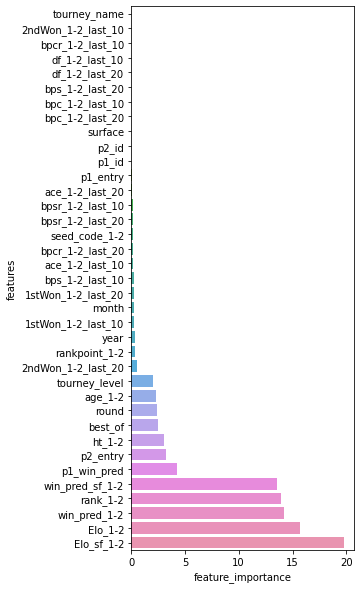

In [170]:
features = X_train.columns
feature_importance = catb_grid.best_estimator_.feature_importances_

featureimportance = pd.DataFrame()
featureimportance['features'] = features
featureimportance['feature_importance'] = feature_importance

featureimportance.sort_values(['feature_importance'],inplace=True)

plt.figure(figsize=(4,10))
sns.barplot(x ='feature_importance' ,y = 'features' ,data = featureimportance)

In [171]:

# calculate the accuracy on test set
y_test_pred = catb_grid.predict(X_test)
y_test_pred = 1*(y_test_pred>0.5)
acc_cat = accuracy_score(y_test, y_test_pred)
print('The accuracy of winner prediction using Catboost is: {}%'.format(round(acc_cat*100,3))) 

y_test_pred_elo = 1*(X_test['p1_win_pred']>0.5)
acc_cat_elo = accuracy_score(y_test, y_test_pred_elo)
print('The accuracy of winner prediction using elo alone is: {}%'.format(round(acc_cat_elo*100,3))) 


The accuracy of winner prediction using Catboost is: 65.319%
The accuracy of winner prediction using elo alone is: 64.243%


In [172]:
# calculate the accuracy on validation set
y_val_pred = catb_grid.predict(X_val)
y_val_pred = 1*(y_val_pred>0.5)
acc_cat = accuracy_score(y_val, y_val_pred)
print('The accuracy of winner prediction using Catboost is: {}%'.format(round(acc_cat*100,3))) 

y_val_pred_elo = 1*(X_val['p1_win_pred']>0.5)
acc_cat_elo = accuracy_score(y_val, y_val_pred_elo)
print('The accuracy of winner prediction using elo alone is: {}%'.format(round(acc_cat_elo*100,3))) 

The accuracy of winner prediction using Catboost is: 66.365%
The accuracy of winner prediction using elo alone is: 65.546%


* Neural network

In [ ]:
#to be added

 <a id='Insight'></a>
 ##  7. [Insight and Discussion](#Contents)